In [1]:
#Guide for Processing Sessions with Dreadds2 Class
#Imports & Setup
from myphdlib.interface.dreadds2 import Dreadds2Session
from myphdlib.interface.NR1KO import NR1Session
from myphdlib.interface.nope import NOPESession
from myphdlib.pipeline.prediction import predictSaccadeDirection
from myphdlib.pipeline.prediction import predictSaccadeEpochs
import matplotlib.pylab as plt
import os
import re
import numpy as np
from myphdlib.general.labjack import loadLabjackData
from felsen_analysis.toolkit.process import AnalysisObject
import felsen_analysis.toolkit.populations as pop
import felsen_analysis.toolkit.plots as pl

In [3]:
#session = NOPESession('/media/jbhunt/EPHYS-01/6-18-25/testNOPE')
session = NOPESession('/media/jbhunt/EPHYS-01/nopetangential/9-10-2025/ChR2GAD3')

In [5]:
matrix = session.load('labjack/matrix')
opto = matrix[:, 11]
#probe = matrix[:, 9]

In [6]:
optoIndices = np.where(np.diff(opto) == 1)[0]
optoTimes = session.computeTimestamps(optoIndices)
#probeIndices = np.where(np.diff(probe) == 1)[0]
#p#robeTimesPre = session.computeTimestamps(probeIndices)
#probeFilter = np.where(probeTimesPre > np.min(optoTimes))[0]
#probeTimes = probeTimesPre[probeFilter]

In [5]:
optoTimes

array([1236.579, 1237.589, 1238.599, ..., 3388.135, 3389.145, 3390.155])

In [22]:
tmp_clusters = []
for unit in session.population:
    tmp_clusters.append(unit.cluster)

In [13]:
from toolkit.process import AnalysisObject
sessionZ = AnalysisObject('/media/jbhunt/EPHYS-01/6-18-25/testNOPE/outputzerosoffset.hdf')
sessionL = AnalysisObject('/media/jbhunt/EPHYS-01/6-18-25/testNOPE/output.hdf')
qualityZ = sessionZ.load('metrics/ql')
qualityL = sessionL.load('metrics/ql')
print(qualityL)

ModuleNotFoundError: No module named 'toolkit'

In [7]:
ampCutoff = session.load('metrics/ac')
presenceRatio = session.load('metrics/pr')
firingRate = session.load('metrics/fr')
isiViol = session.load('metrics/rpvr')
qualityLabels = session.load('metrics/ql')
goodUnits = list()
for index, unit in enumerate(session.population):
    if qualityLabels is not None and qualityLabels[index] in (0, 1):
        continue
    if ampCutoff[index] <= 0.1:
        if presenceRatio[index] >= 0.9:
            if firingRate[index] >= 0.2:
                if isiViol[index] <= 0.5:
                    goodUnits.append(unit.cluster)

IndexError: index 556 is out of bounds for axis 0 with size 556

Text(0, 0.5, 'FR (spikes/sec)')

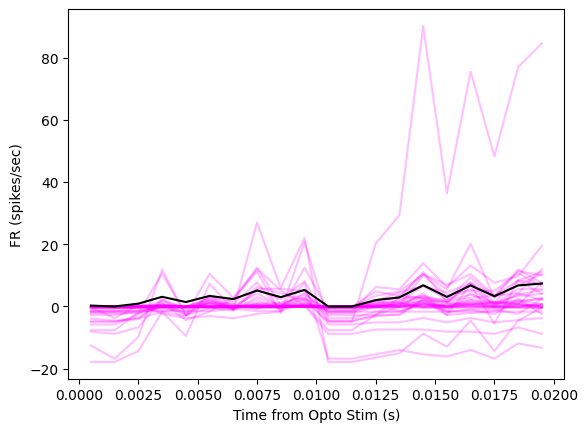

In [15]:
%matplotlib inline
fig, ax = plt.subplots()
frList = list()
for unit in session.population:
    if unit.cluster not in goodUnits:
        continue
    spikeTimes = unit.timestamps
    t, fr = unit.peth(optoTimes, (0, 0.02), 0.001)
    baseline = np.mean(fr[0:10])
    corrected = fr - baseline
    plt.plot(t, corrected, color='magenta', alpha=0.25)
    frList.append(fr)
frAvg = np.mean(frList, axis=0)
plt.plot(t, frAvg, color='k')
#plt.ylim(-50, 50)
plt.xlabel('Time from Opto Stim (s)')
plt.ylabel('FR (spikes/sec)')

Text(0, 0.5, 'Neuron')

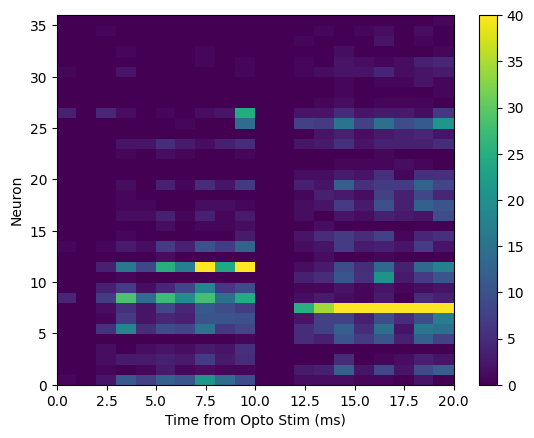

In [16]:
plt.pcolor(frList, vmax=40)
plt.colorbar()
plt.xlabel('Time from Opto Stim (ms)')
plt.ylabel('Neuron')

/tmp/ipykernel_689635/1070799648.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  L1 = np.array(L)


18


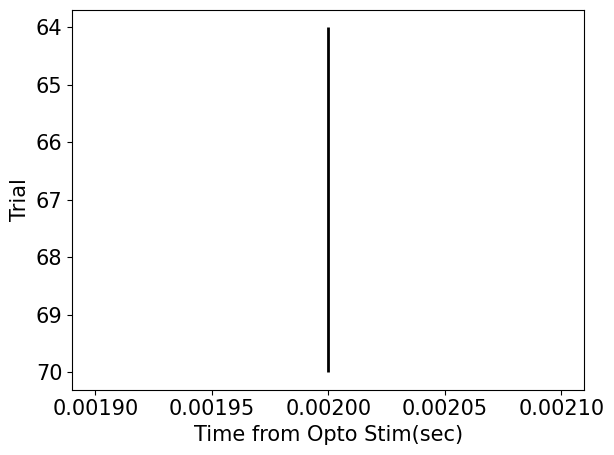

19


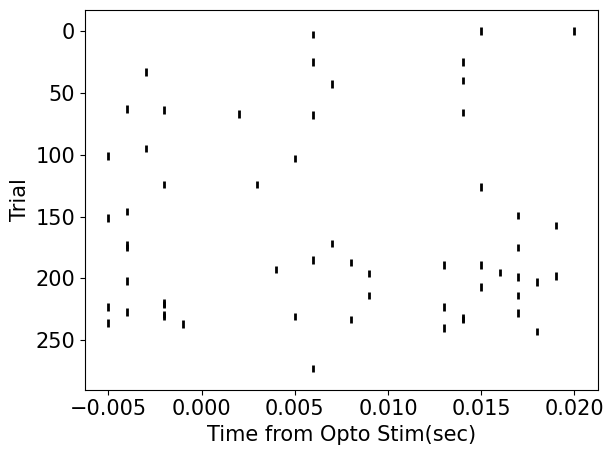

26


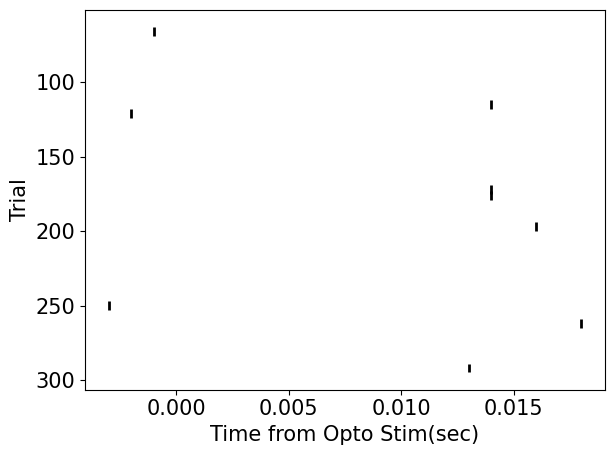

37


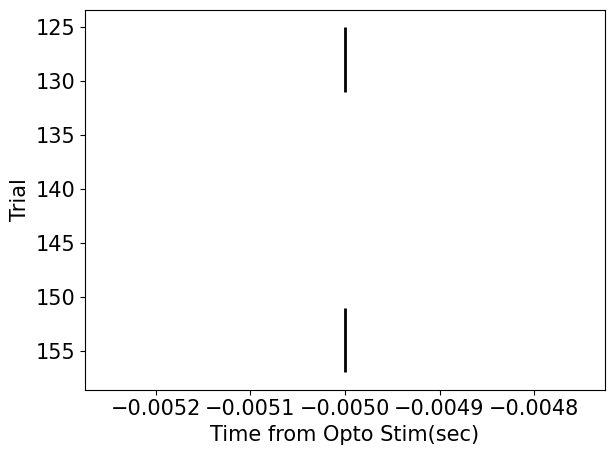

43


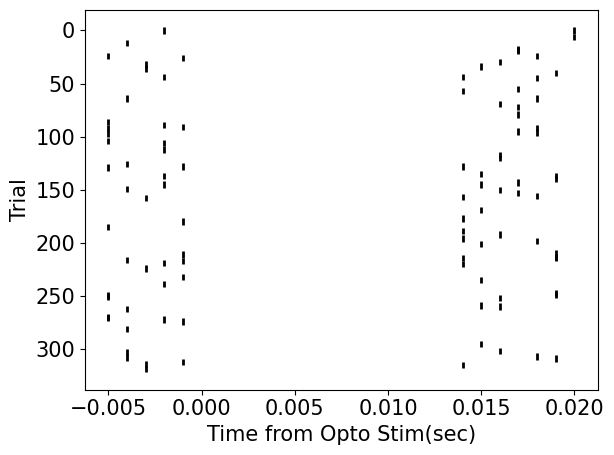

48


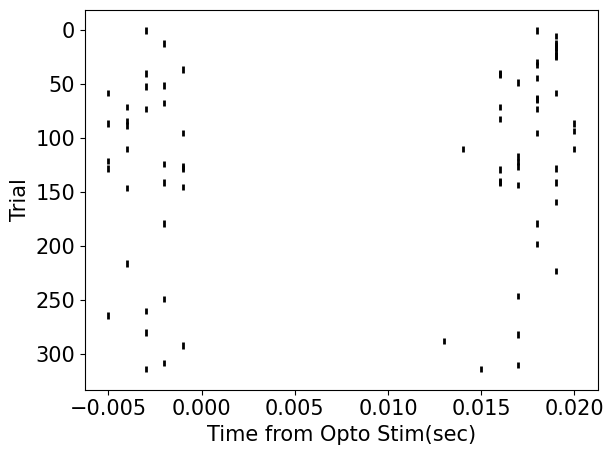

51


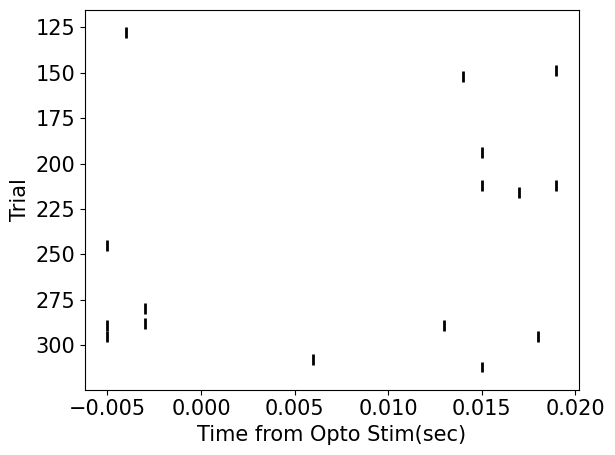

53


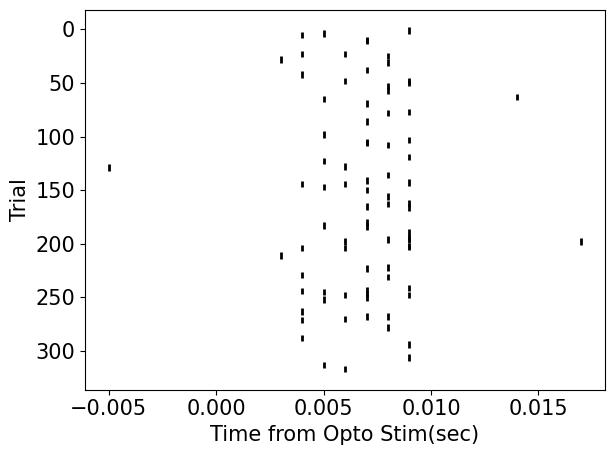

60


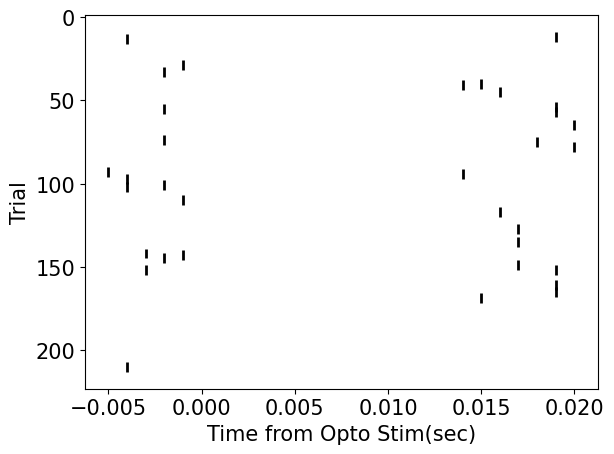

76


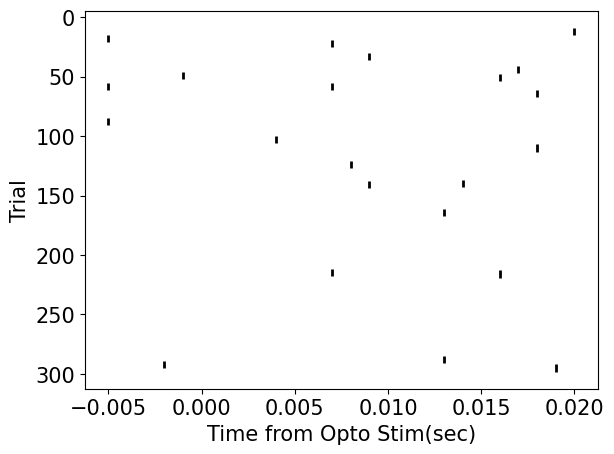

94


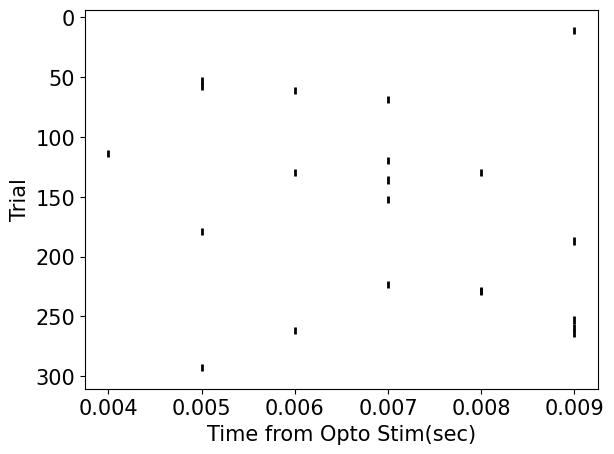

97


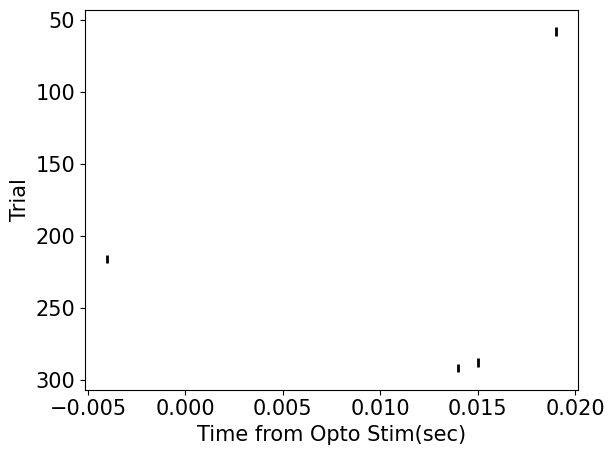

98


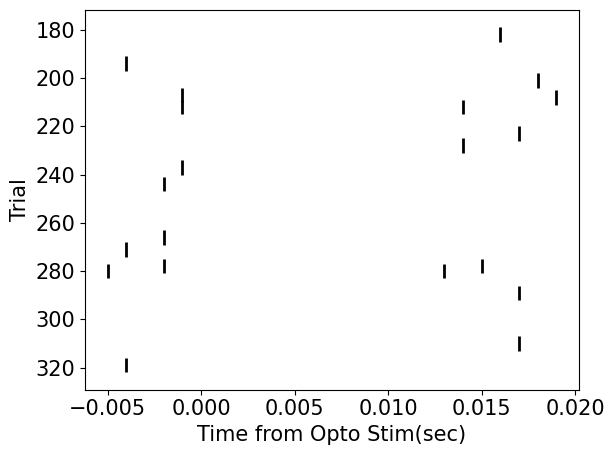

110


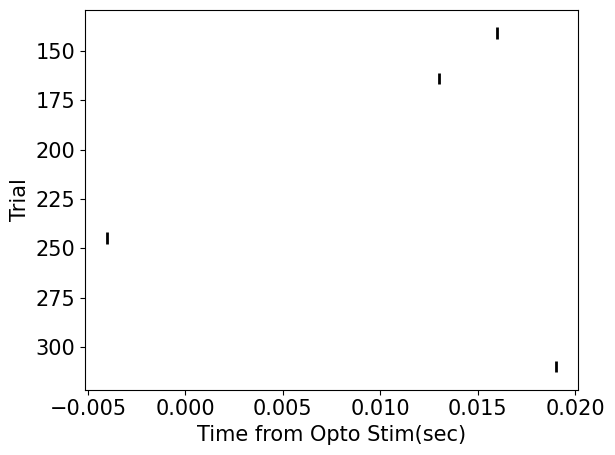

113


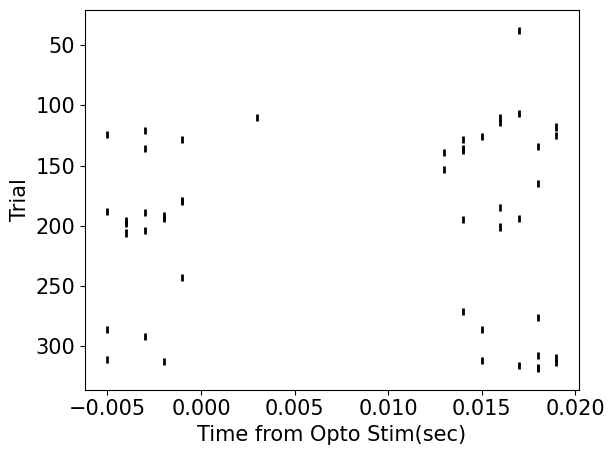

116


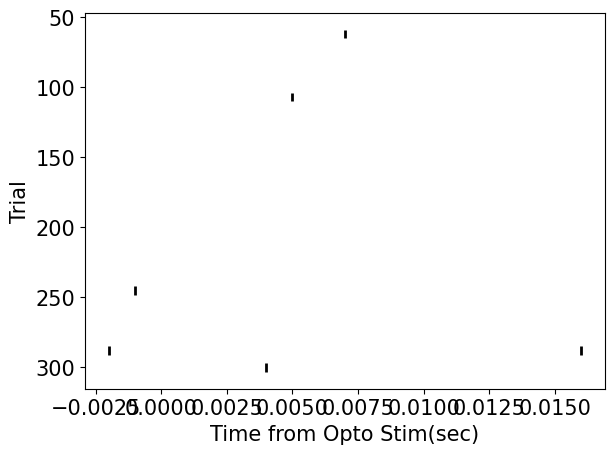

162


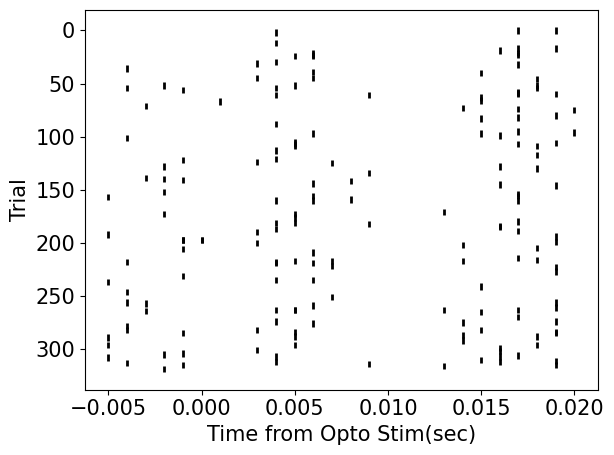

167


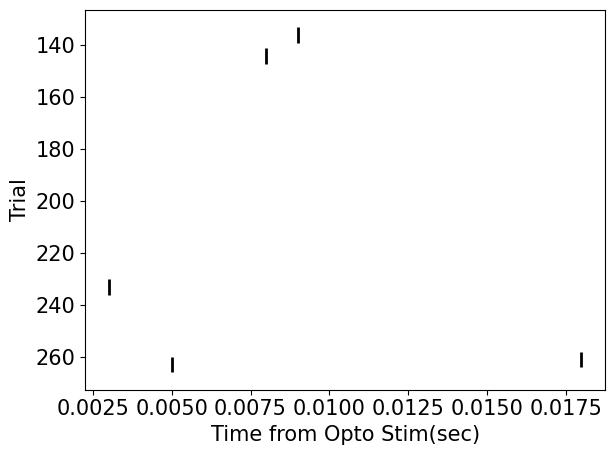

In [20]:
window = (-0.005, 0.02)
%matplotlib inline
sessionList = ['/media/jbhunt/EPHYS-01-BACKUP/opto/9-10-25/ChR2GAD3',
              '/media/jbhunt/EPHYS-01-BACKUP/opto/9-11-25/ChR2GAD3',
              '/media/jbhunt/EPHYS-01-BACKUP/opto/9-12-25/ChR2GAD3',
              '/media/jbhunt/EPHYS-01-BACKUP/opto/9-15-25/ChR2GAD3',
              '/media/jbhunt/EPHYS-01-BACKUP/opto/9-16-25/ChR2GAD3',
              '/media/jbhunt/EPHYS-01-BACKUP/opto/9-17-25/ChR2GAD3']
path = sessionList[5]
h5file = os.path.join(path, 'output.hdf')
#h5file = '/media/jbhunt/EPHYS-01/nopetangential/9-11-2025/ChR2GAD3/output.hdf'
session = AnalysisObject(h5file)
clusterFile = os.path.join(path, 'ephys/sorting/manual/spike_clusters.npy')
uniqueSpikeClusters = np.unique(np.load(clusterFile))
qualityUnits = pop.defineQualityUnits(h5file, clusterFile)
session2 = NOPESession(path)
matrix = session2.load('labjack/matrix')
opto = matrix[:, 14]
optoIndices = np.where(np.diff(opto) == 1)[0]
optoTimes = session2.computeTimestamps(optoIndices)
for unit in session._population():
    index = np.where(uniqueSpikeClusters == unit.cluster)[0].item()
    if unit.cluster in qualityUnits:
        L = list()
        #if index in premotorUnits[str(session.date)]:
            #fig, axs = plt.subplots()
        for probe in optoTimes:
            spikeTimestamps = unit.timestamps
            if not np.all(np.isfinite(spikeTimestamps)):
                print(f"[ERROR] Non-finite timestamps in unit {unit.cluster}")
            b1 = probe + window[0]
            b2 = probe + window[1]
            maskB = np.logical_and(spikeTimestamps >= b1, spikeTimestamps < b2)
            b = spikeTimestamps[maskB] - probe
            if not np.all(np.isfinite(b)):
                print(f"[ERROR] Non-finite values in trial {i} for unit {unit.cluster}: {b}")
            L.append(b)
        L1 = np.array(L)
        print(unit.cluster)
        fig, ax = plt.subplots()
        font = {'size' : 15}
        plt.rc('font', **font)
        plt.gca().invert_yaxis()
        for rowIndex, row in enumerate(L1):
            x = row
            y0 = rowIndex - 3
            y1 = rowIndex + 3
            ax.vlines(x, y0, y1, color='k', lw=2)
        ax.set_ylabel('Trial')
        ax.set_xlabel('Time from Opto Stim(sec)')
        #fig.set_figheight(10)
       # fig.set_figwidth(6)
        #ax.text(0, 0, str(unit.cluster))
        plt.tight_layout()
        plt.show()
        plt.close(fig)

In [57]:
session0list = [44, 49, 416, 454]
session1list = [275, 279]
session2list = [80, 139, 140, 141, 199, 223, 232, 242]
session3list = [26, 49, 58, 102, 106, 117, 132, 256]
session4list = [3, 15, 67, 82, 113, 150]
session5list = [53]


0.013


In [5]:
len(optoTimes)

640

In [80]:
timespace = session.load('labjack/timespace')
print(np.where(timespace == np.min(timeList))[0])
print(timespace)

[26]
[0.0000000e+00 5.0000000e-04 1.0000000e-03 ... 3.4059985e+03 3.4059990e+03
 3.4059995e+03]


In [83]:
times = session.load('spikes/clusters')
times[0:20]

array([244, 525, 250, 410,  68,  85,  85,  55,  58, 526,  68, 526, 331,
       410,  32, 526, 101, 113, 526,  68], dtype=int32)

In [8]:
h5file = '/media/jbhunt/EPHYS-01/nopetangential/9-10-2025/ChR2GAD3/output.hdf'
basePath = '/media/jbhunt/EPHYS-01/nopetangential/2025-09-10_09-29-10'
clusterFile = '/media/jbhunt/EPHYS-01/nopetangential/9-10-2025/ChR2GAD3/ephys/continuous/Neuropix-PXI-100.ProbeA-AP/kilosort4/spike_clusters.npy'
session2 = NOPESession('/media/jbhunt/EPHYS-01/nopetangential/9-10-2025/ChR2GAD3')
matrix = session2.load('labjack/matrix')
opto = matrix[:, 14]
optoIndices = np.where(np.diff(opto) == 1)[0]
optoTimes = session2.computeTimestamps(optoIndices)
#clusterList, pList = defineOptoPopulationTTest(h5file, clusterFile, optoTimes)

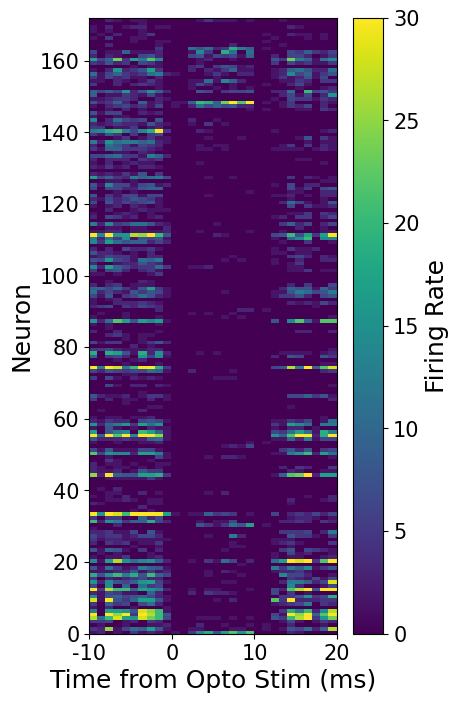

In [20]:
fig, ax = plt.subplots(figsize=(4, 8))
h5file = '/media/jbhunt/EPHYS-01/nopetangential/9-10-2025/ChR2GAD3/output.hdf'
session = AnalysisObject(h5file)
clusterFile = '/media/jbhunt/EPHYS-01/nopetangential/9-10-2025/ChR2GAD3/ephys/sorting/manual/spike_clusters.npy'
qualityUnits = pop.defineQualityUnits(h5file, clusterFile)
#sacTimes = session.load('saccades/predicted/left/timestamps')[:, 0]
frList = list()
for unit in session._population():
    if unit.cluster not in qualityUnits:
        continue
    spikeTimes = unit.timestamps
    t, fr = unit.peth(optoTimes, (-0.01, 0.02), 0.001)
    baseline = np.mean(fr[0:10])
    corrected = fr - baseline
    #plt.plot(t, corrected, color='magenta', alpha=0.25)
    frList.append(fr)
p = ax.pcolor(frList, vmax=30)
cbar = fig.colorbar(p, ax=ax)
cbar.set_label('Firing Rate', fontsize=18)
cbar.ax.tick_params(labelsize=15)
ax.set_xlabel('Time from Opto Stim (ms)', fontsize=18)
ax.set_ylabel('Neuron', fontsize=18)
ax.set_xticks([0, 10, 20, 30], ['-10', '0', '10', '20'], fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

/home/jbhunt/anaconda3/envs/sandbox/lib/python3.10/site-packages/felsen_analysis/toolkit/plots.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  L1 = np.array(L)
/home/jbhunt/anaconda3/envs/sandbox/lib/python3.10/site-packages/felsen_analysis/toolkit/plots.py:134: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


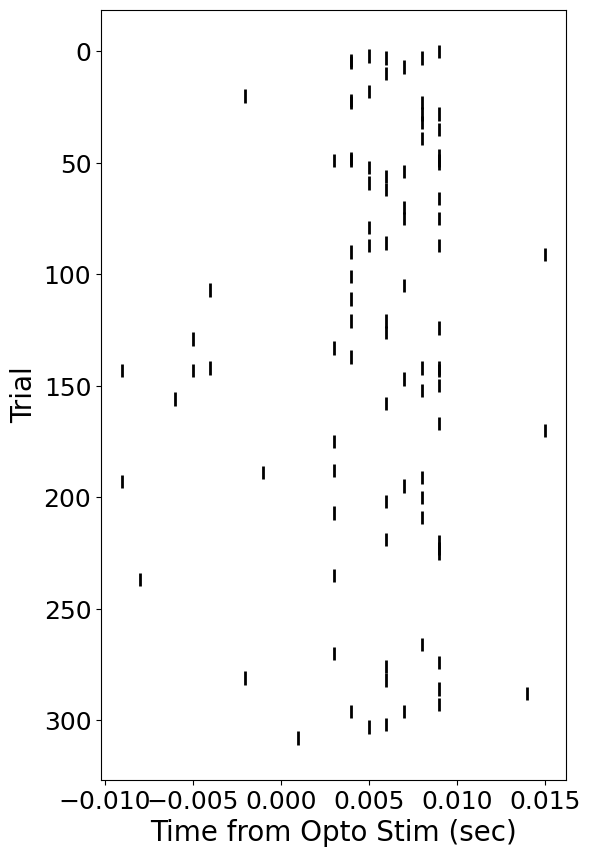

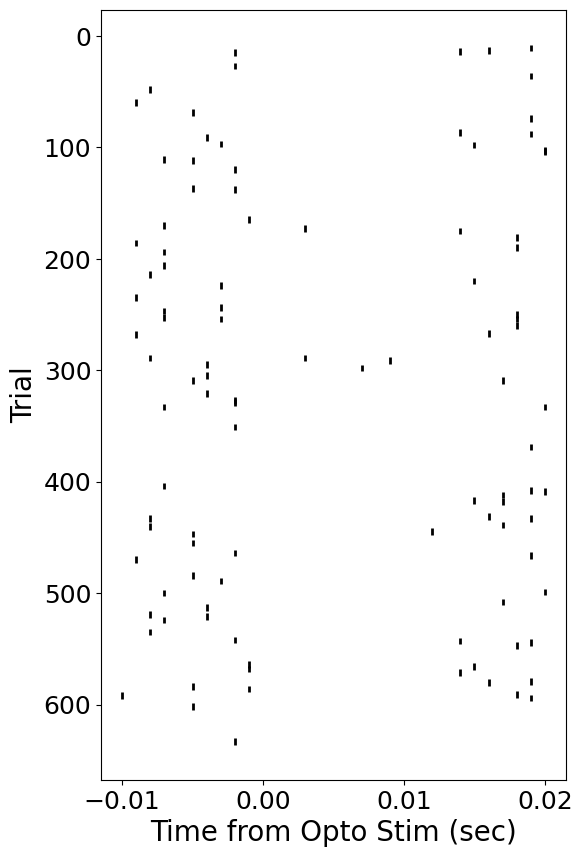

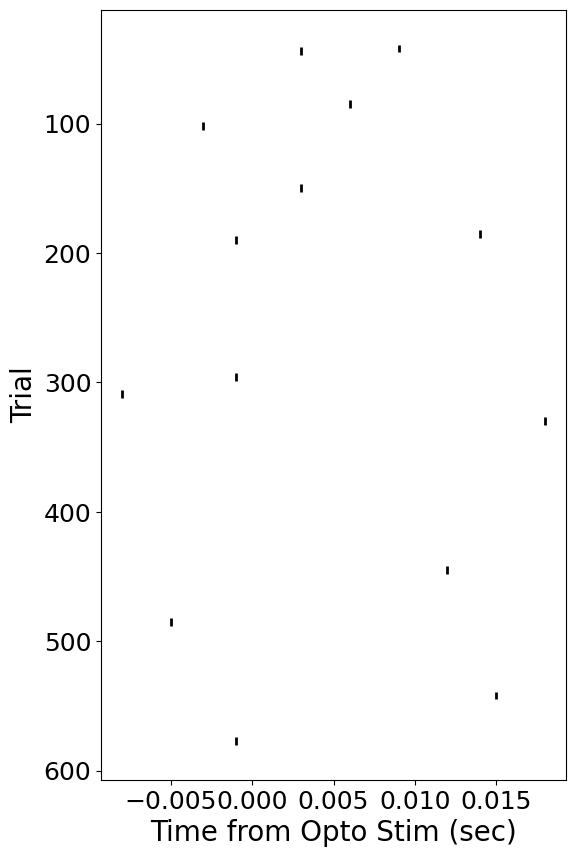

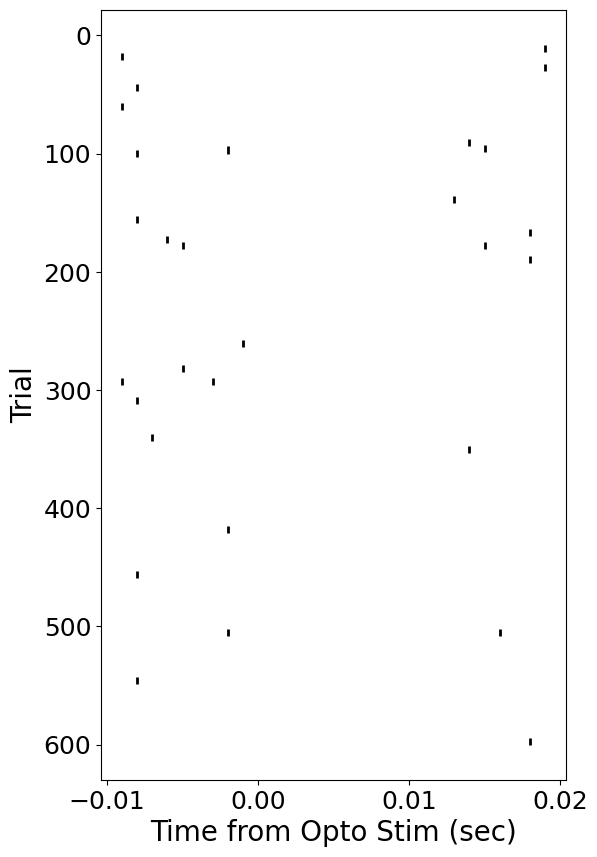

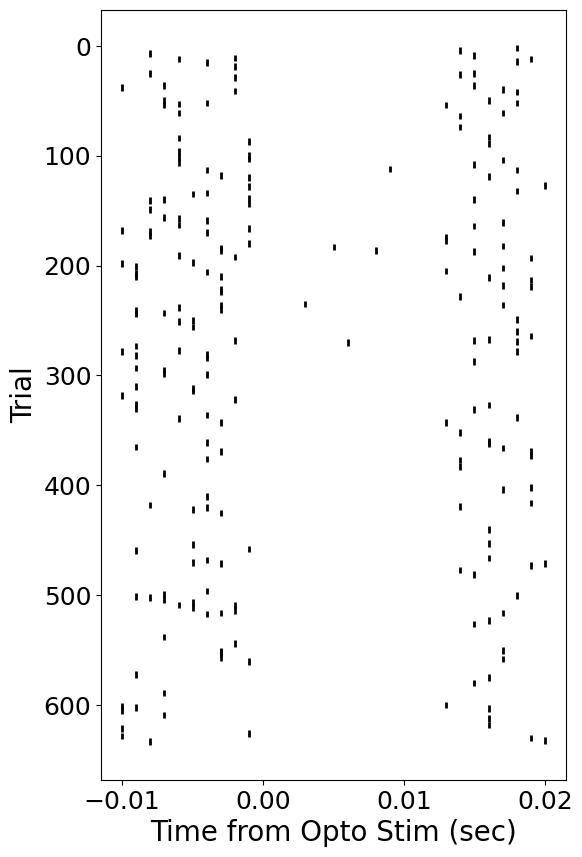

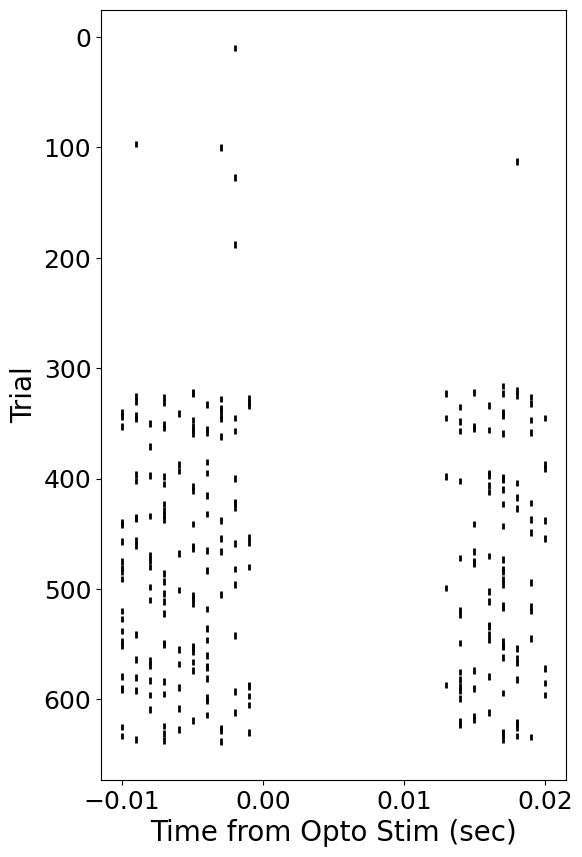

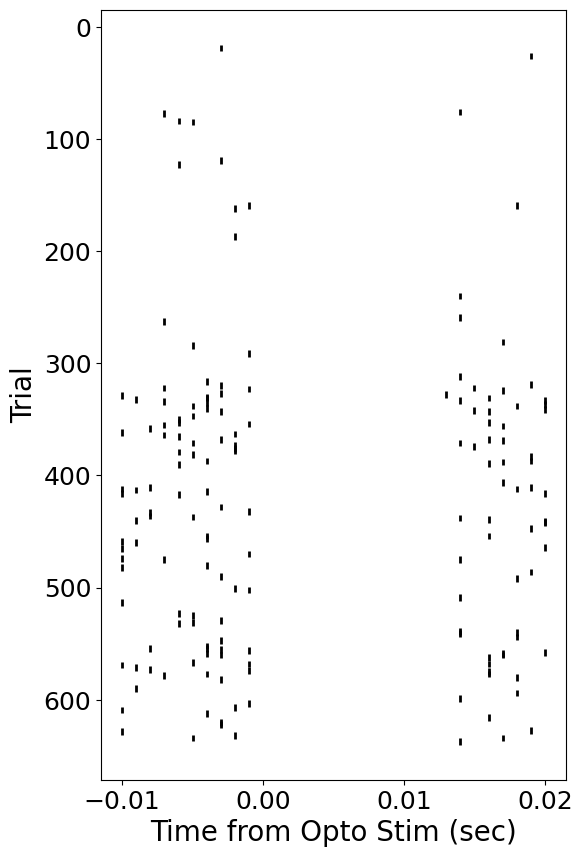

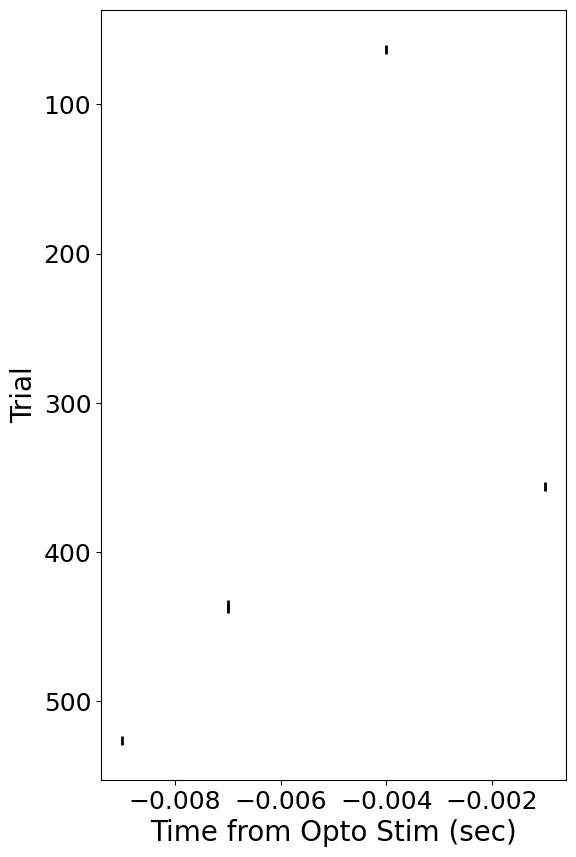

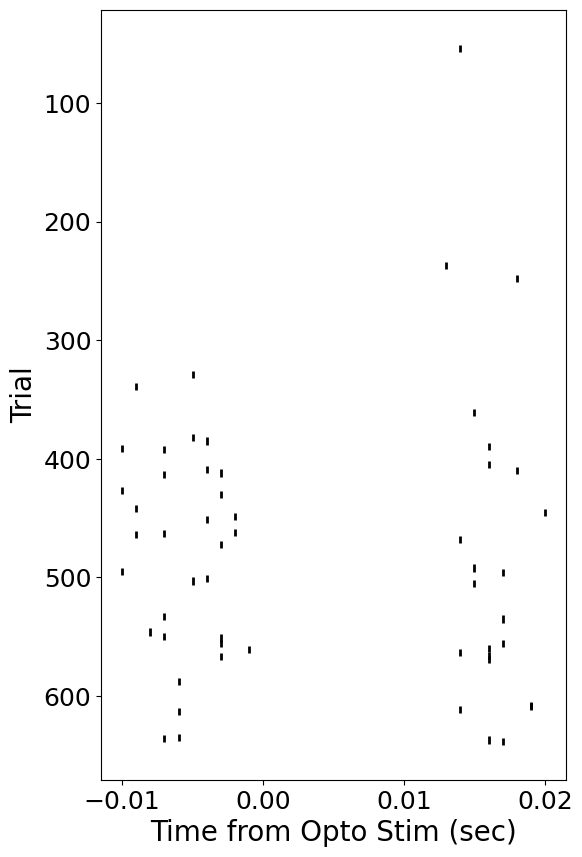

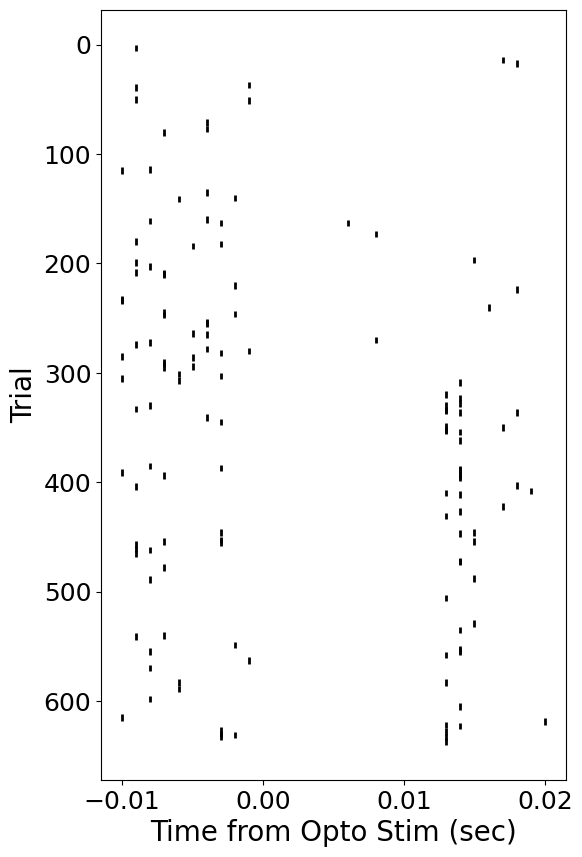

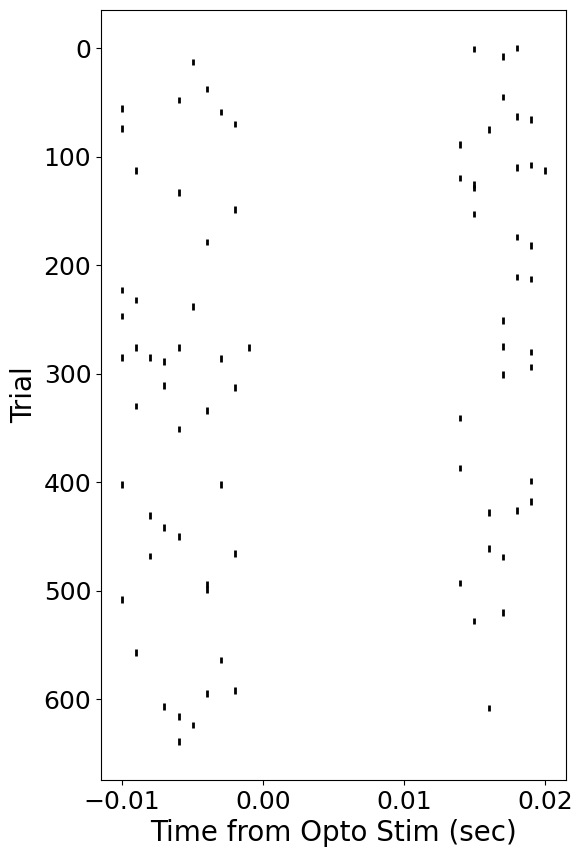

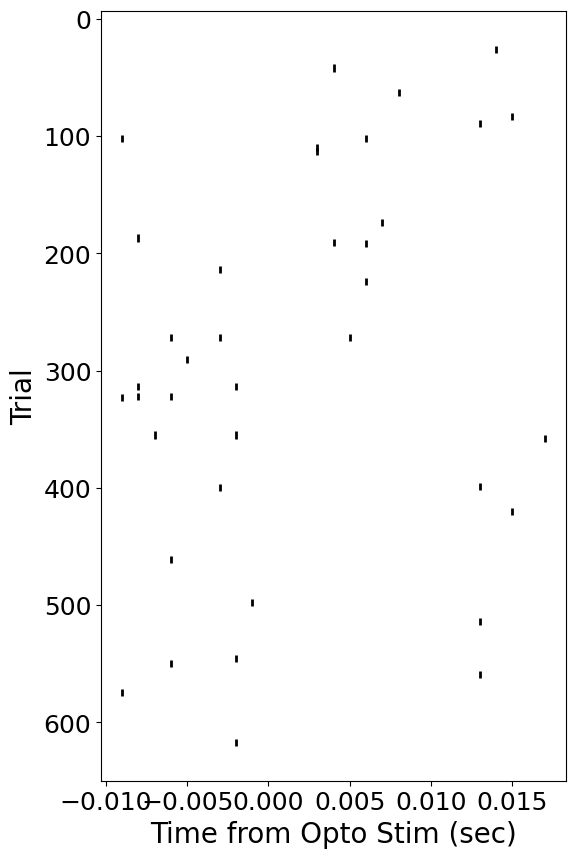

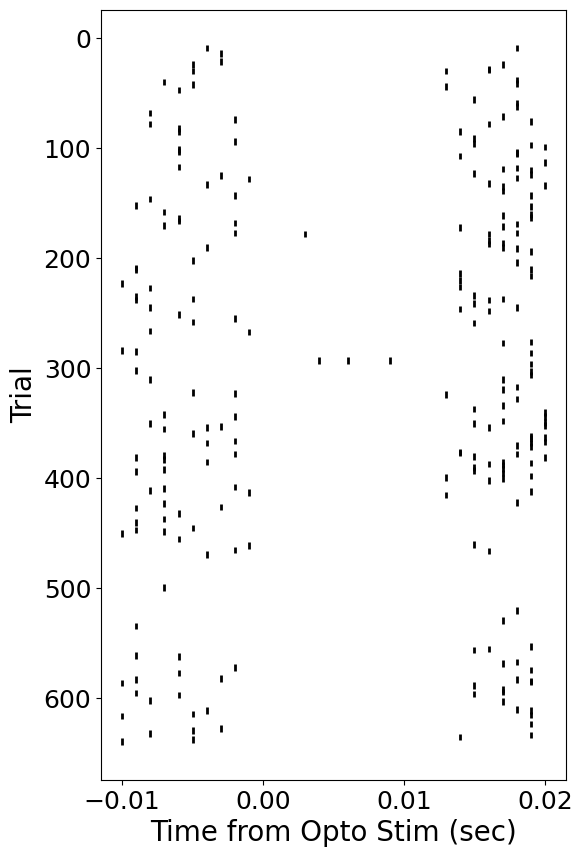

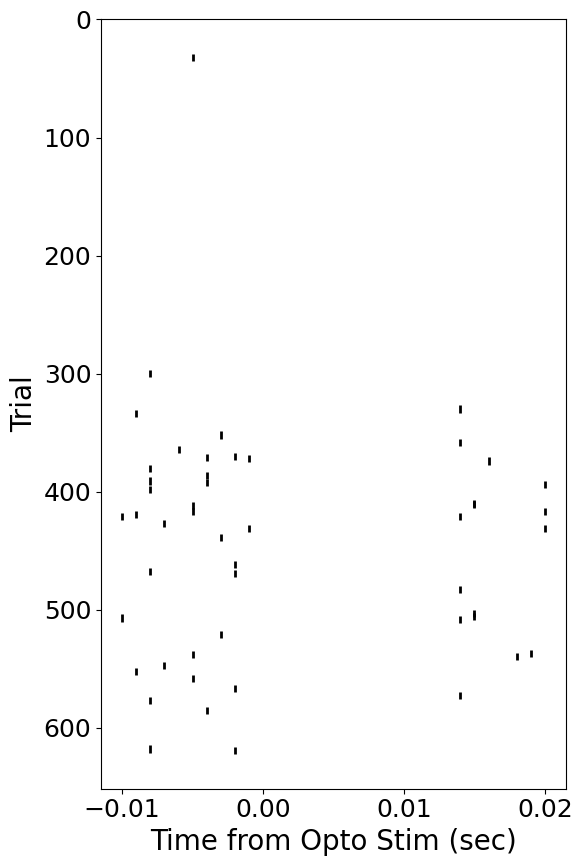

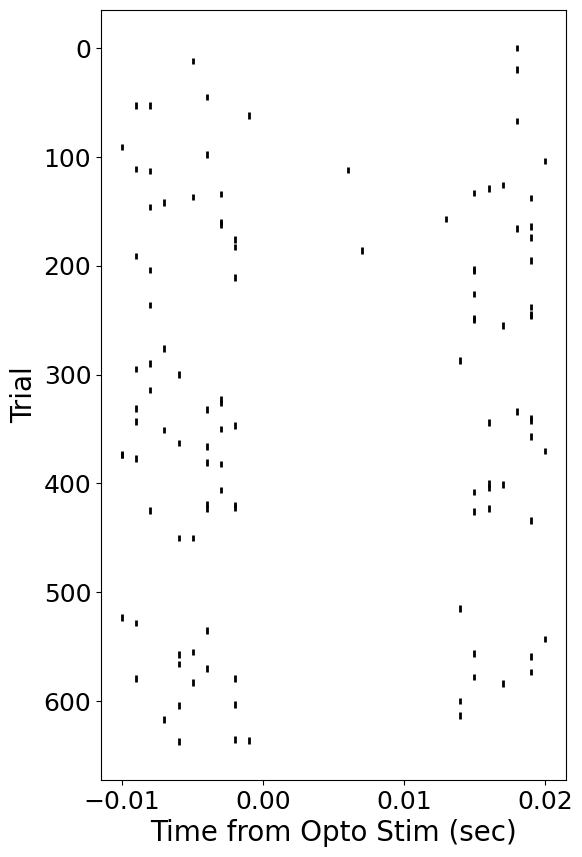

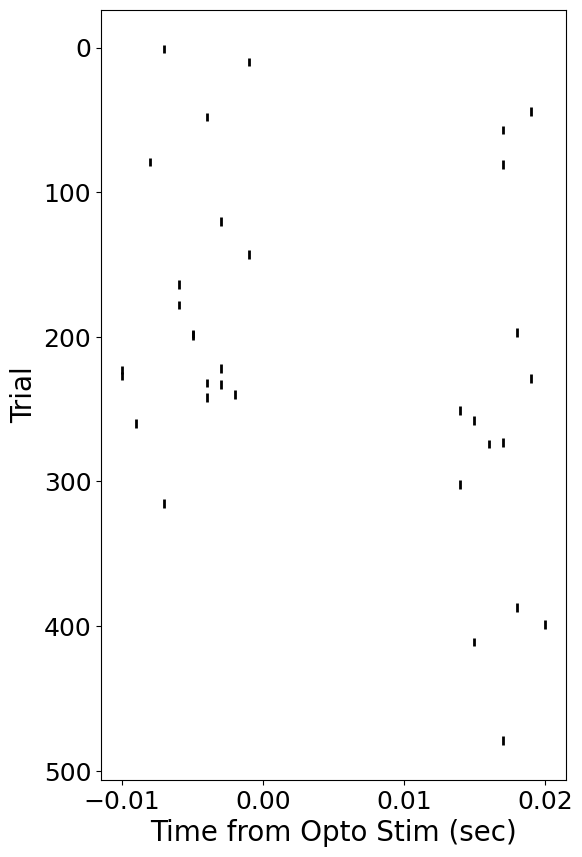

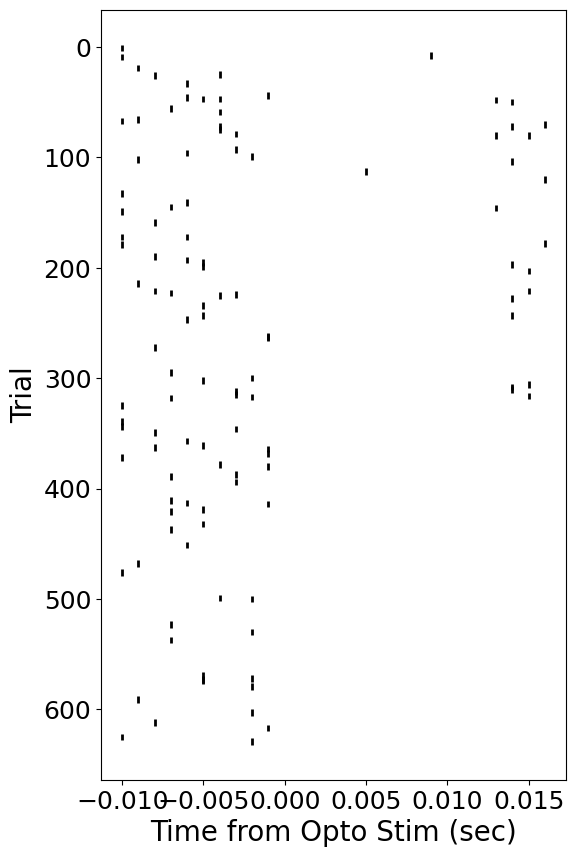

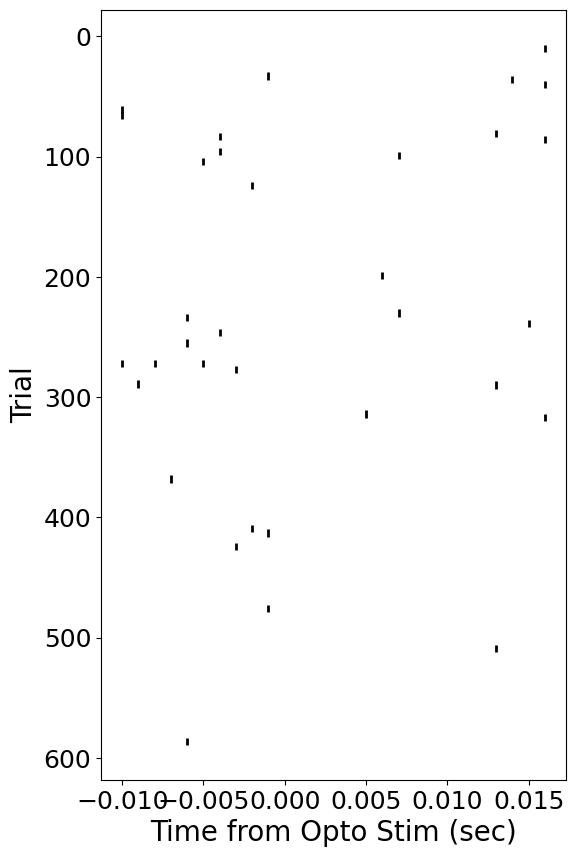

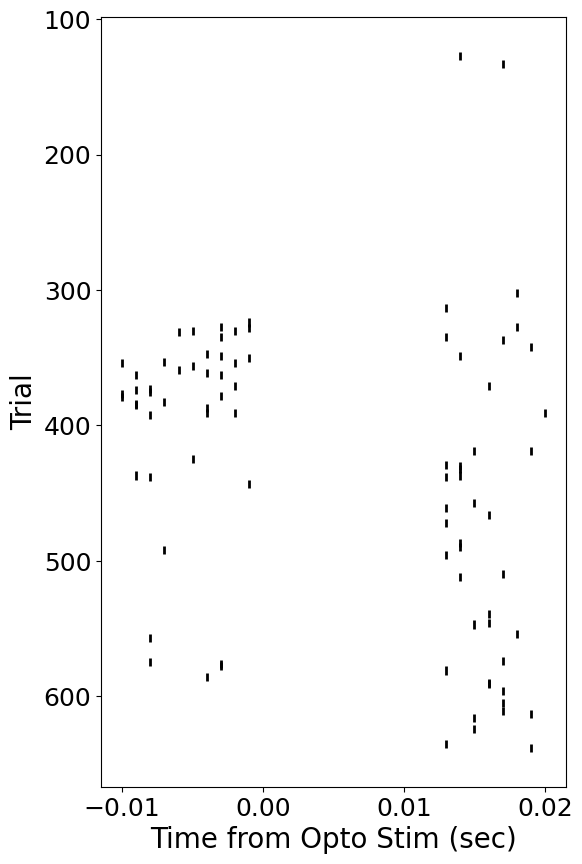

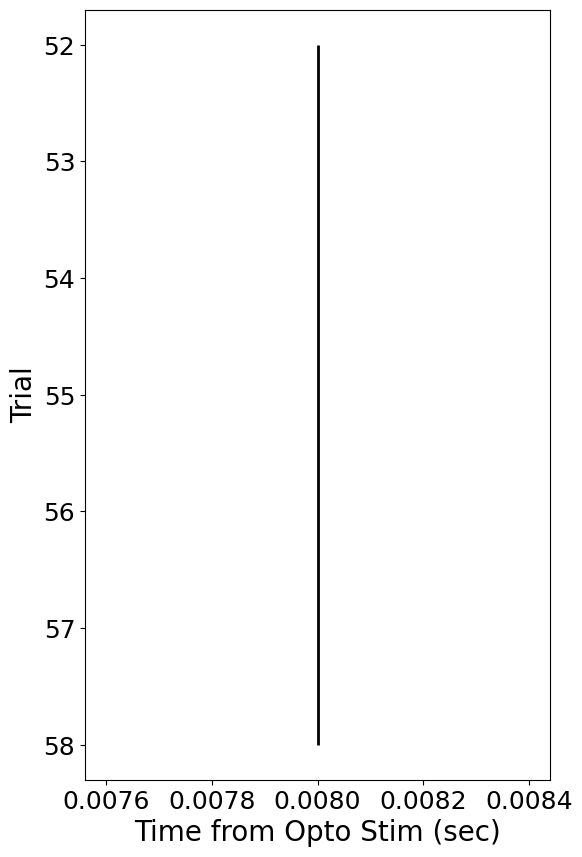

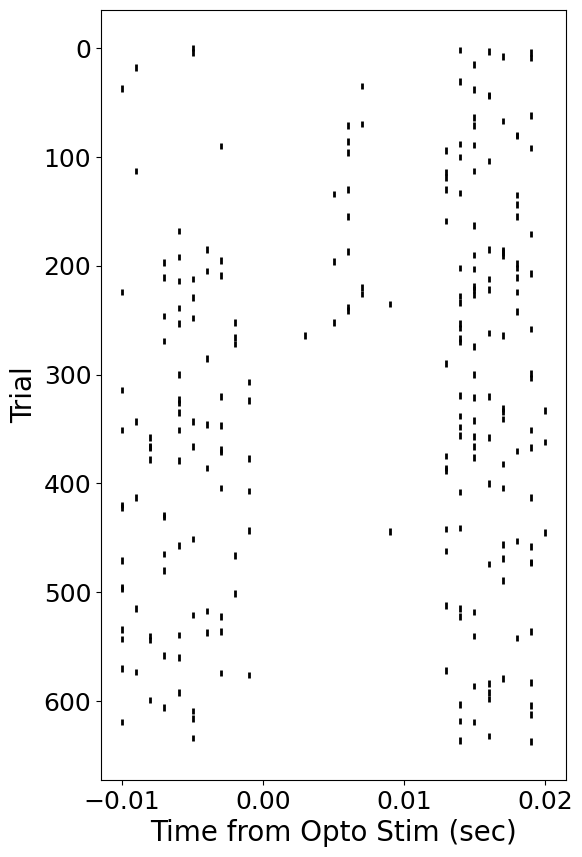

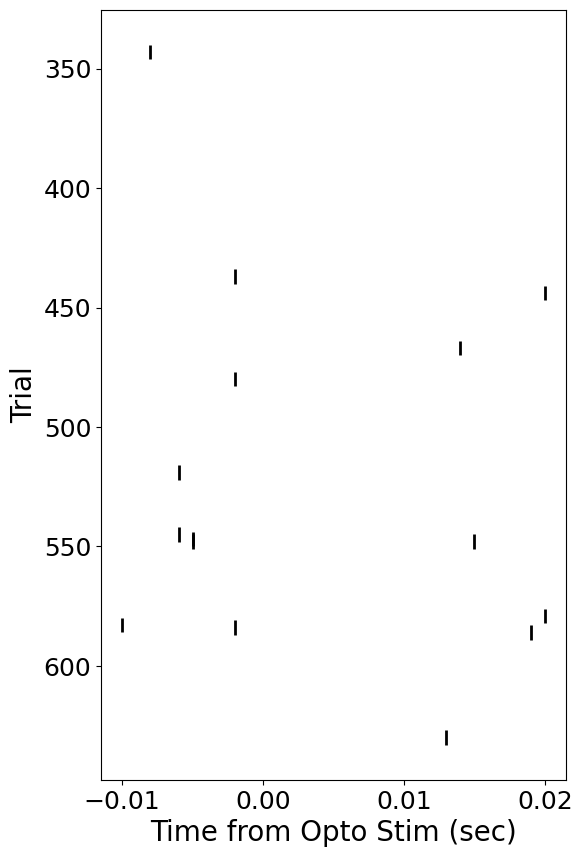

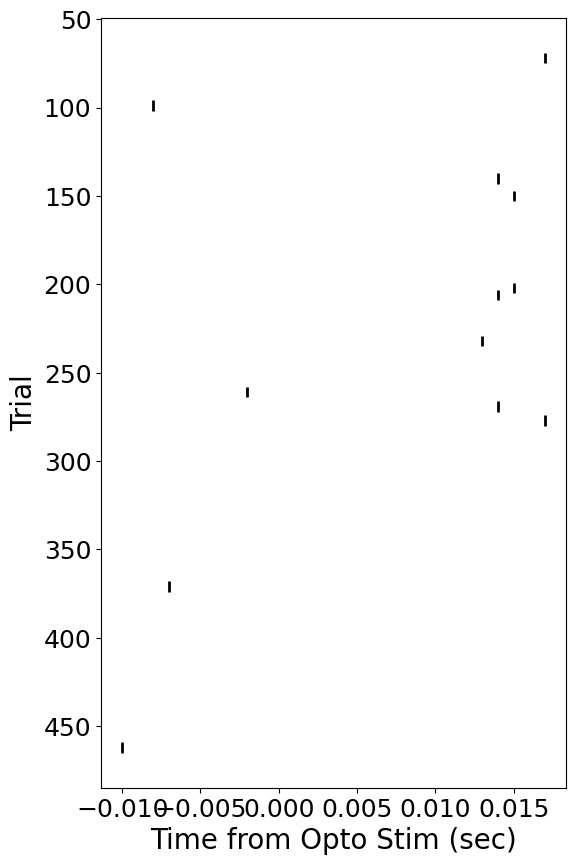

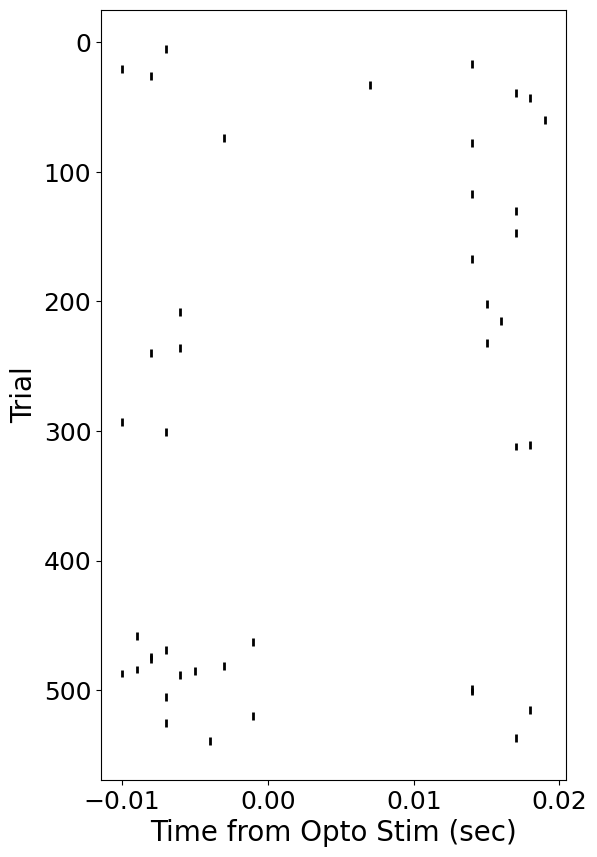

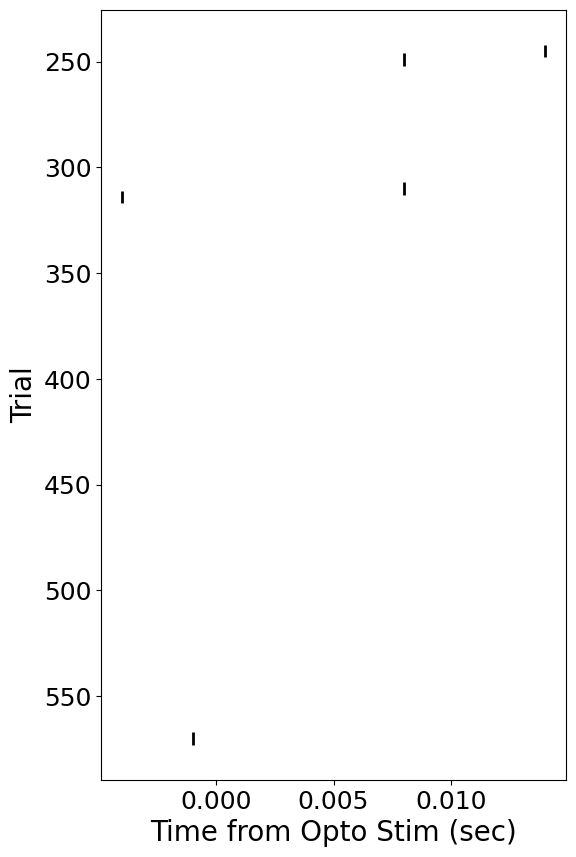

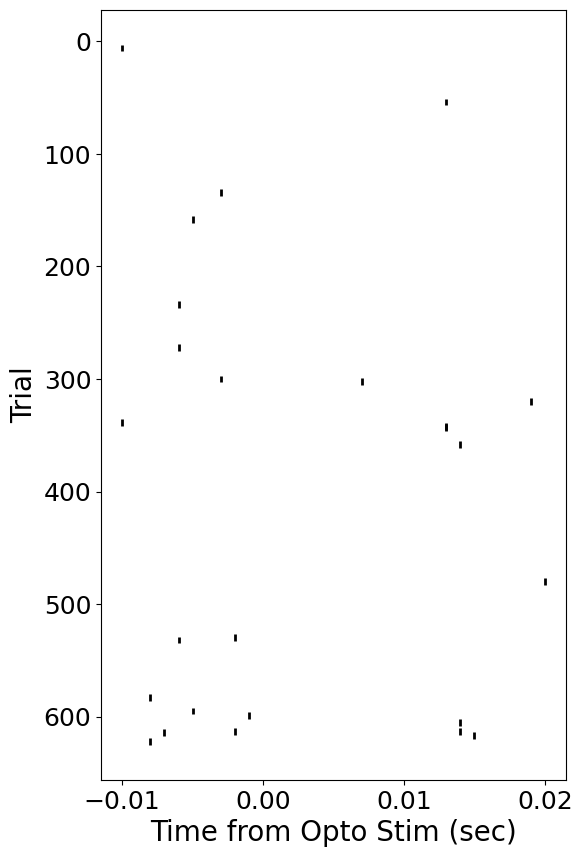

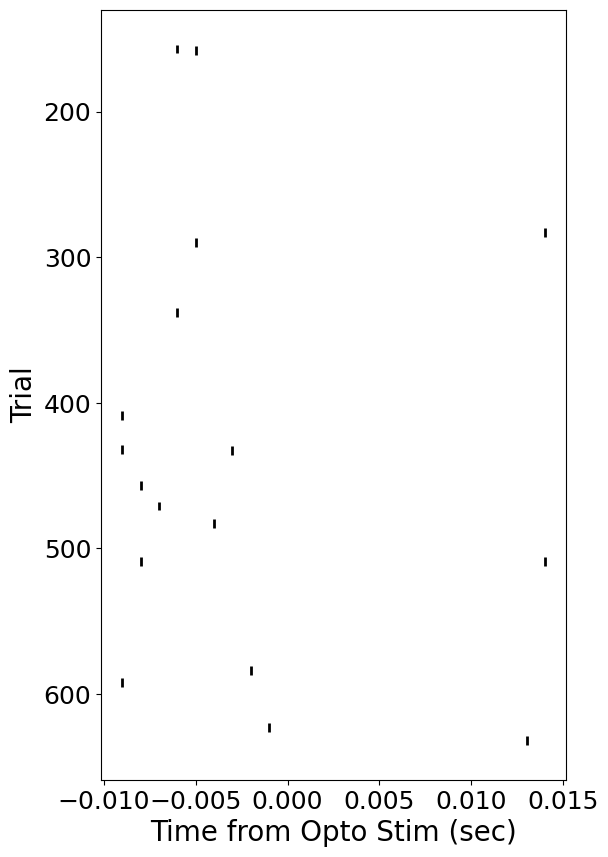

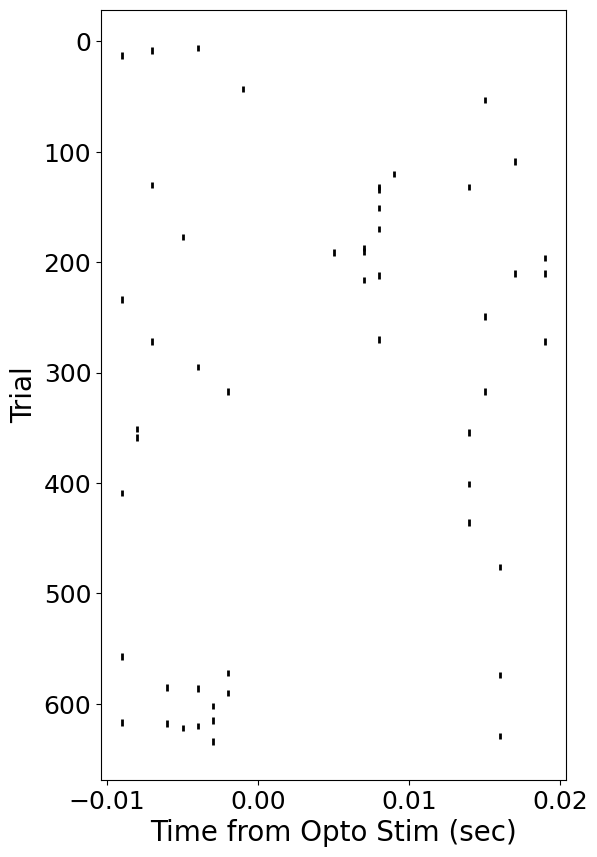

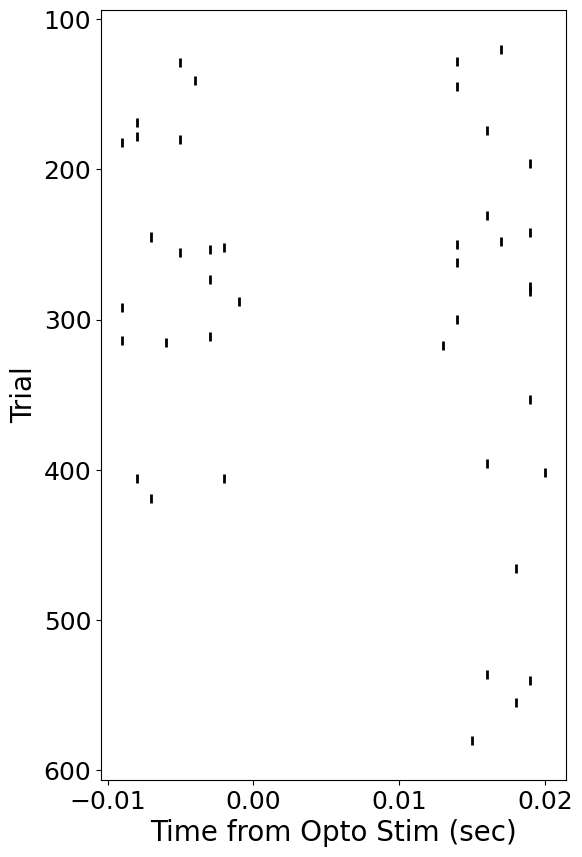

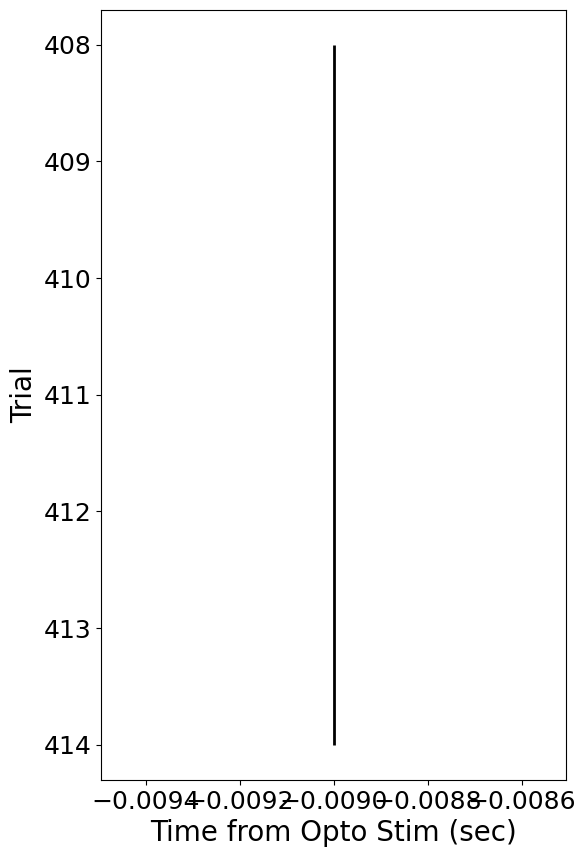

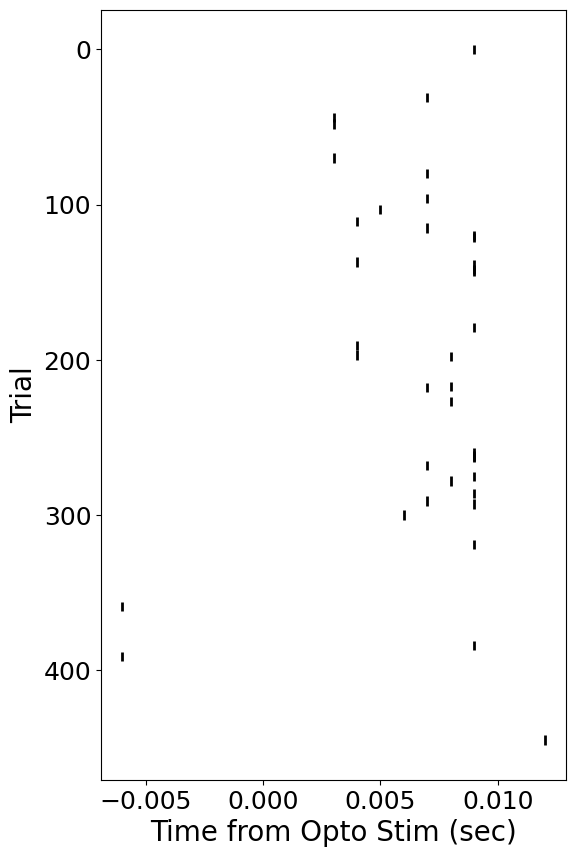

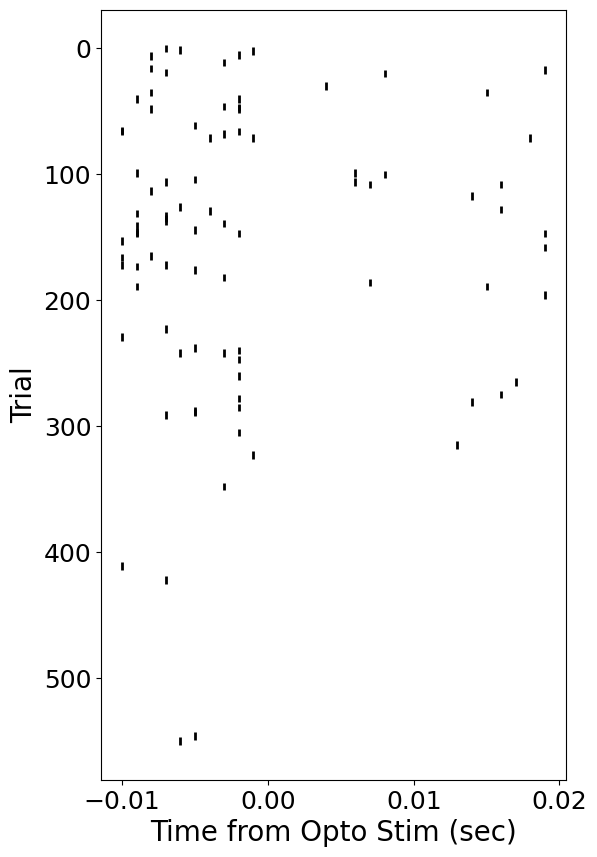

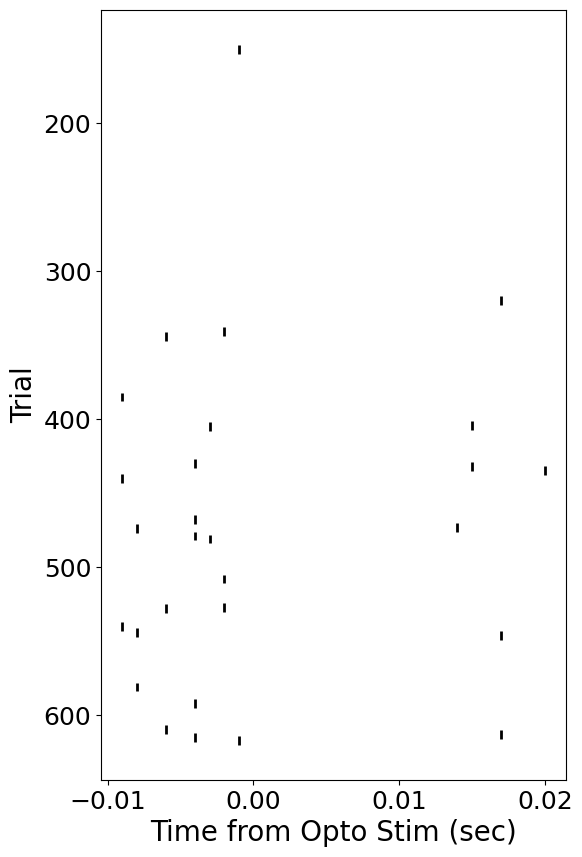

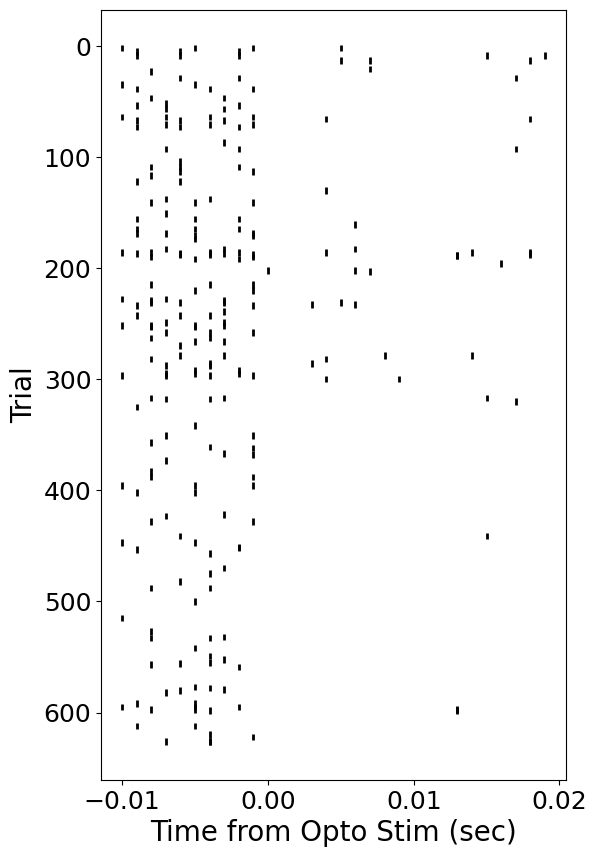

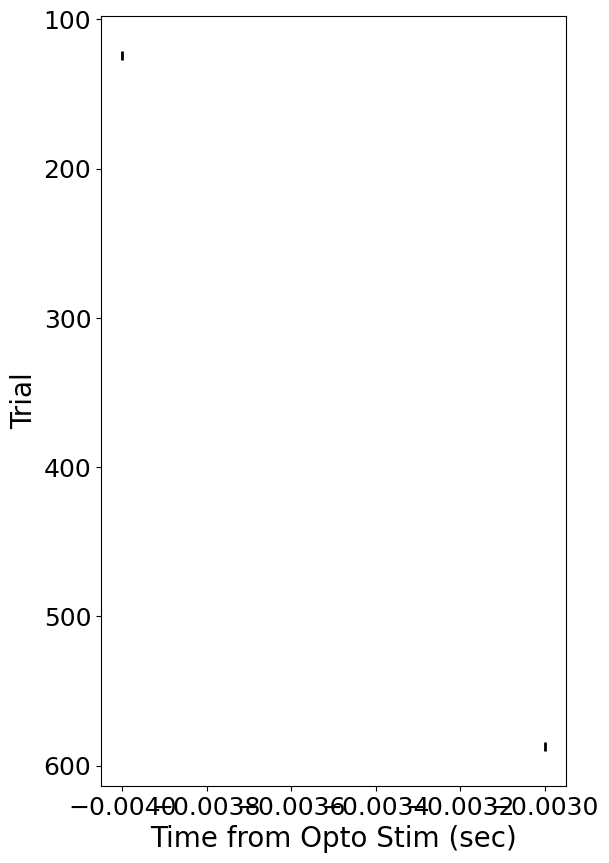

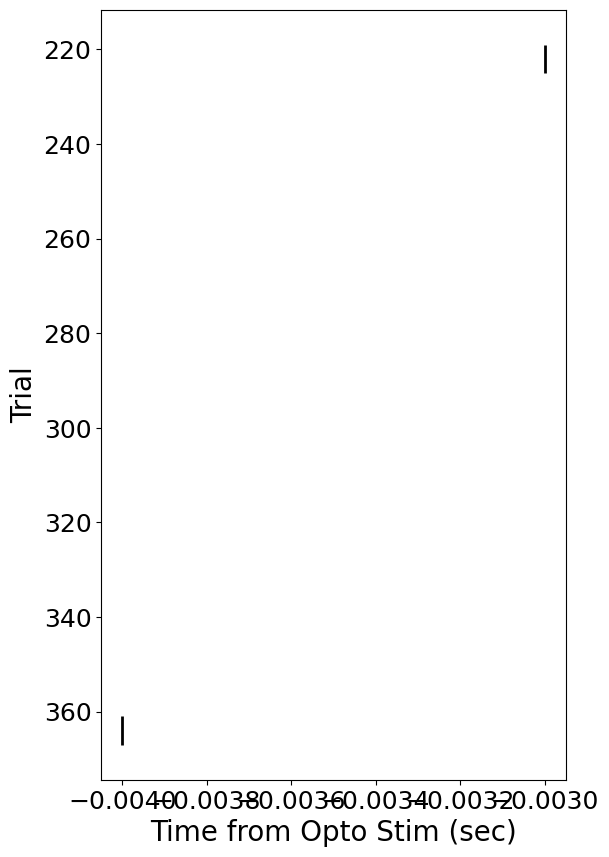

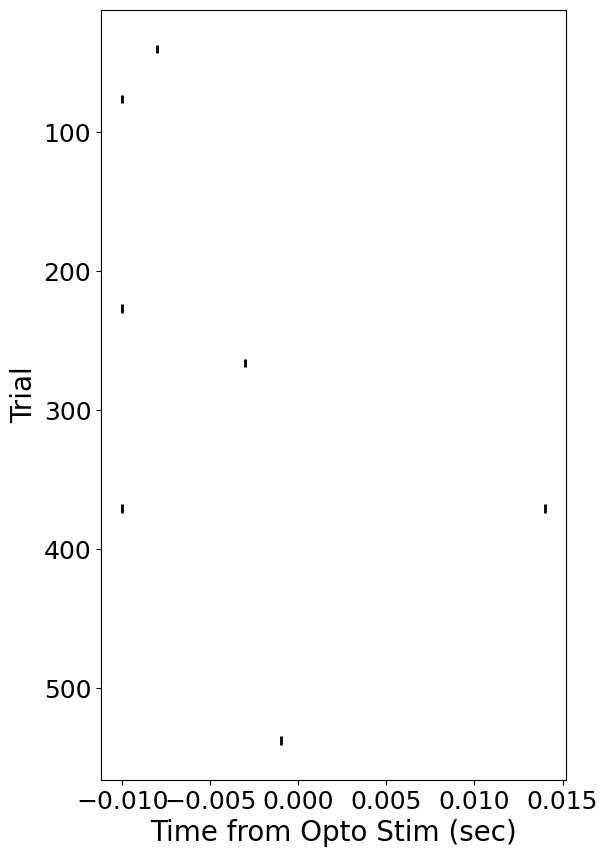

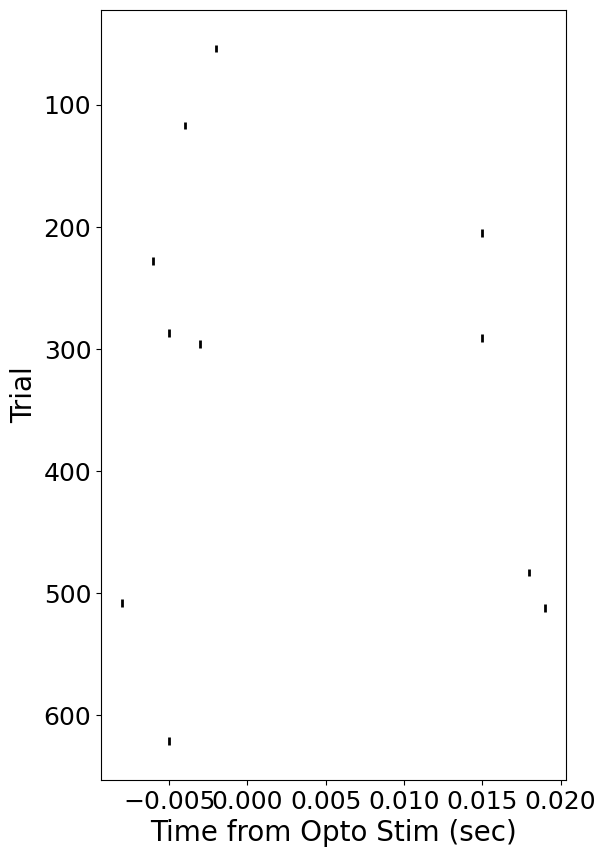

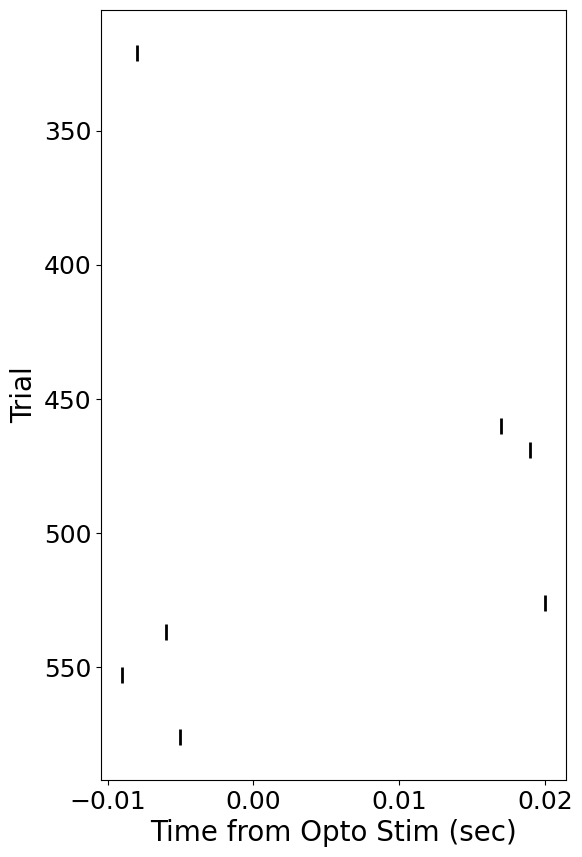

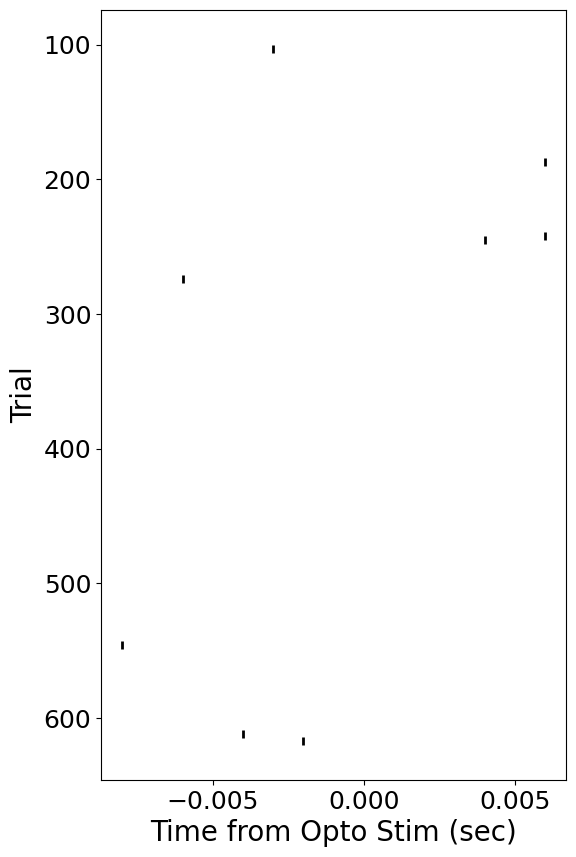

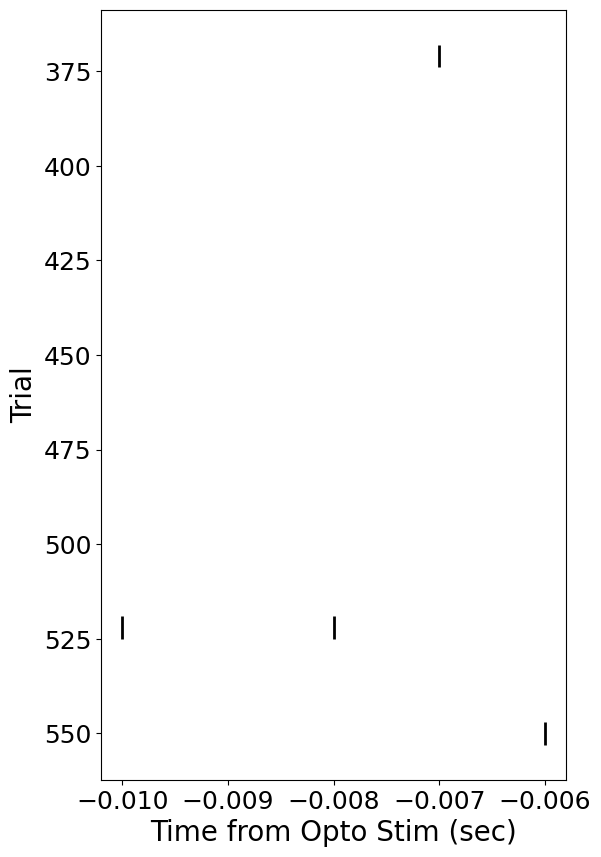

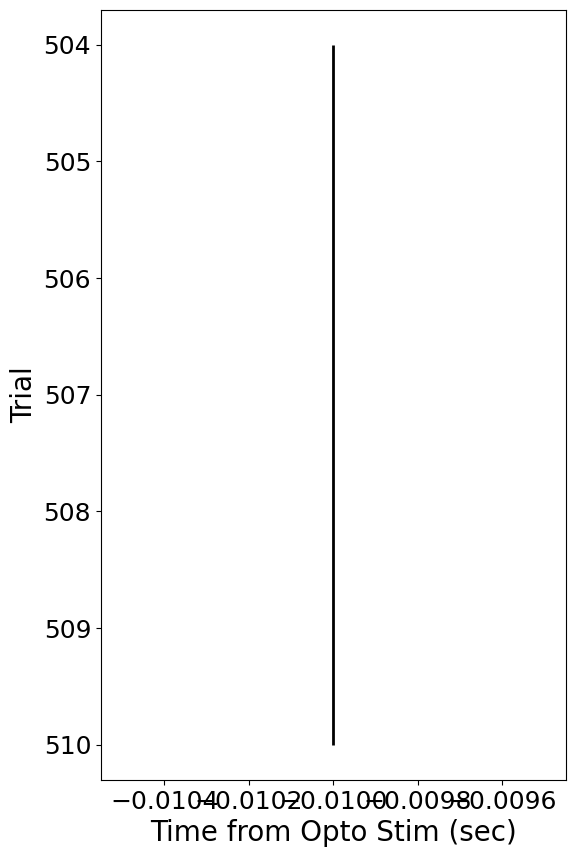

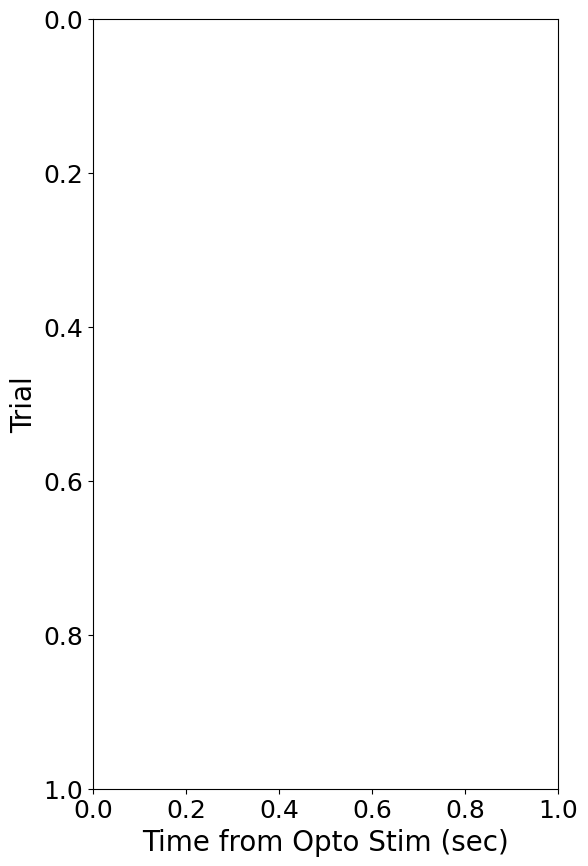

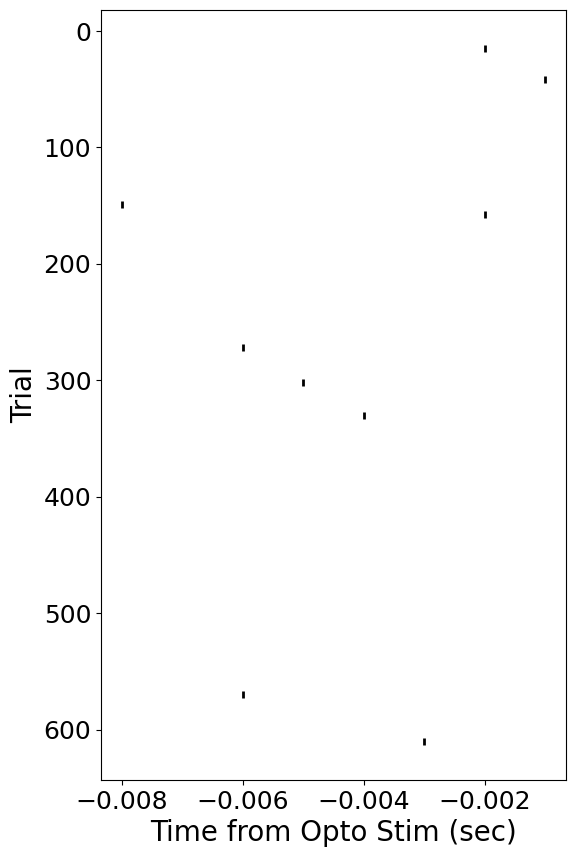

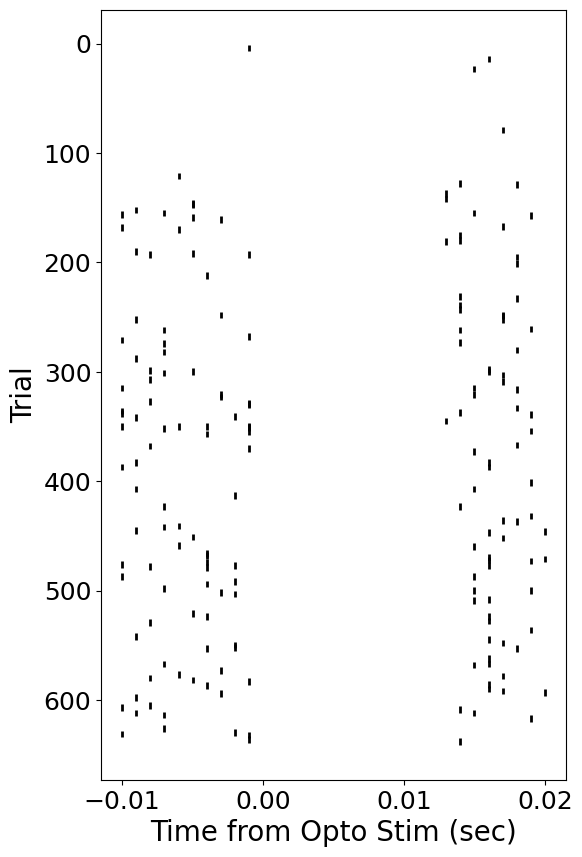

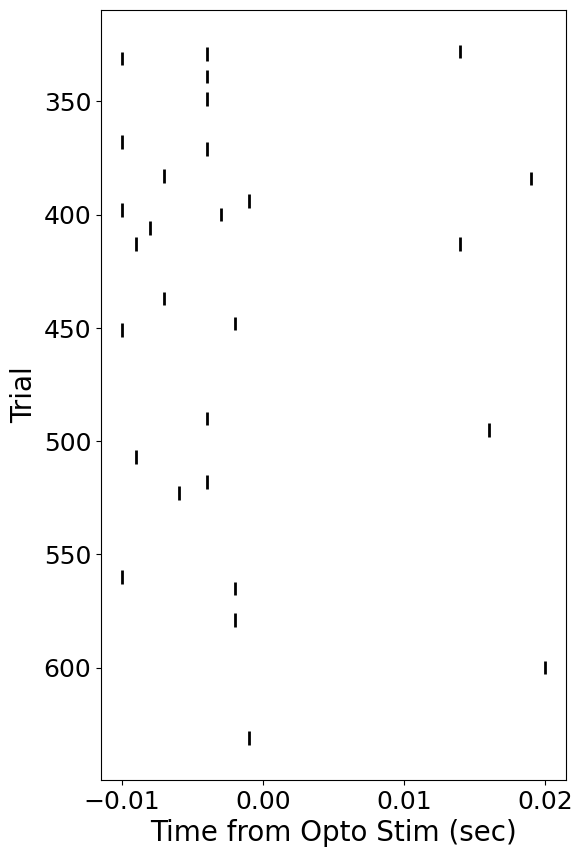

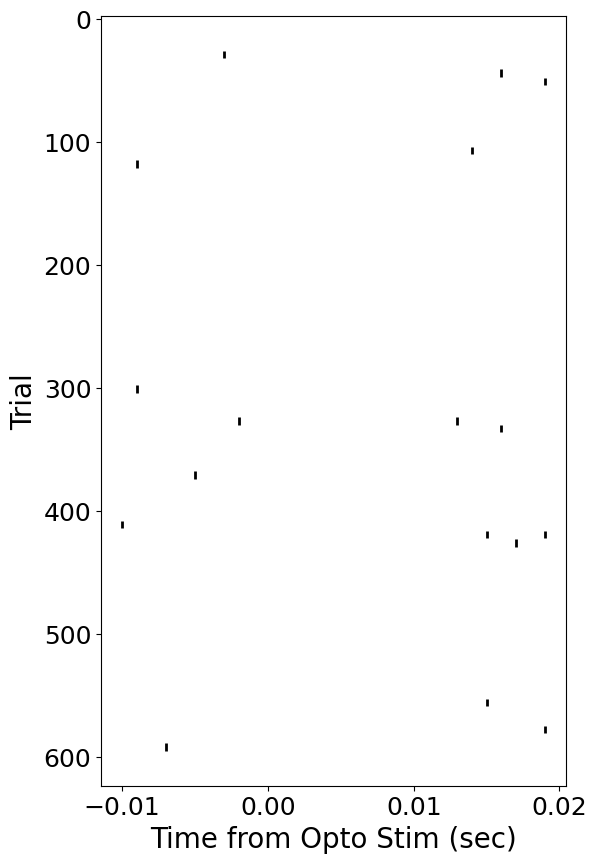

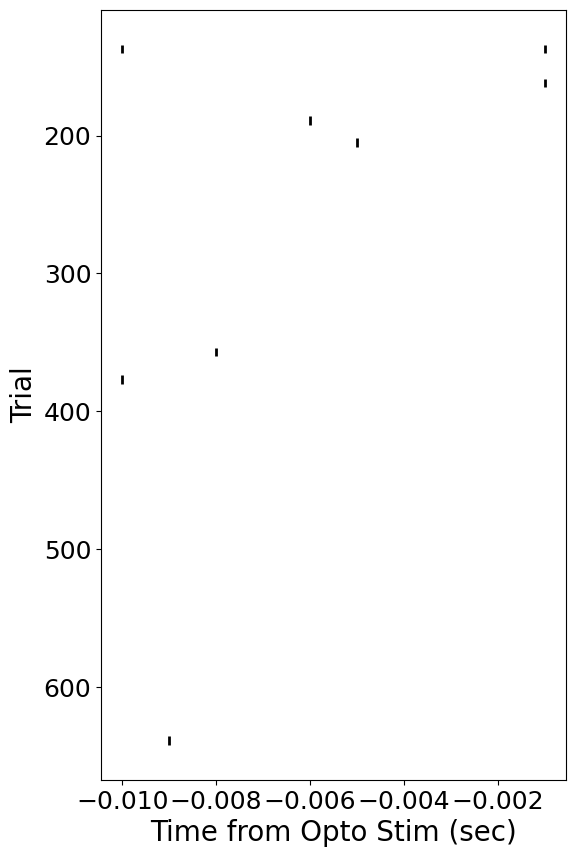

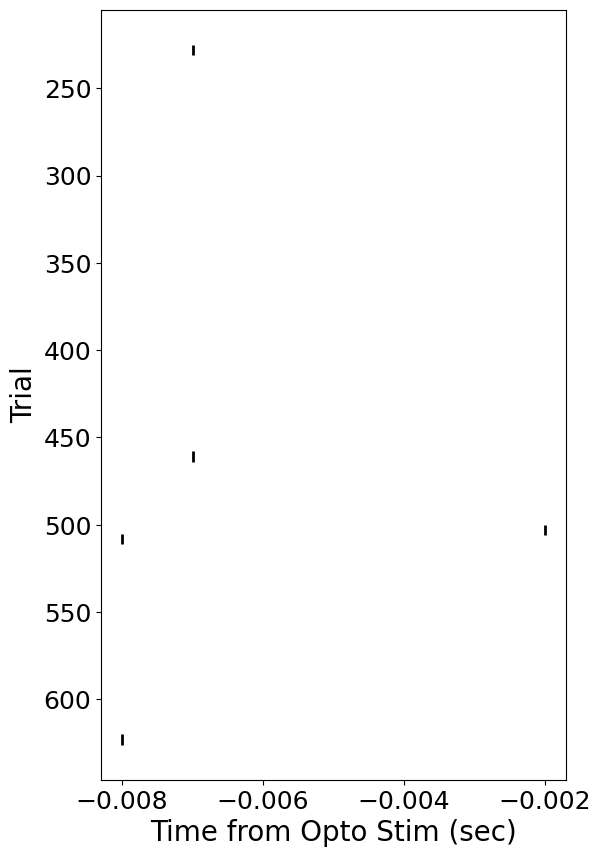

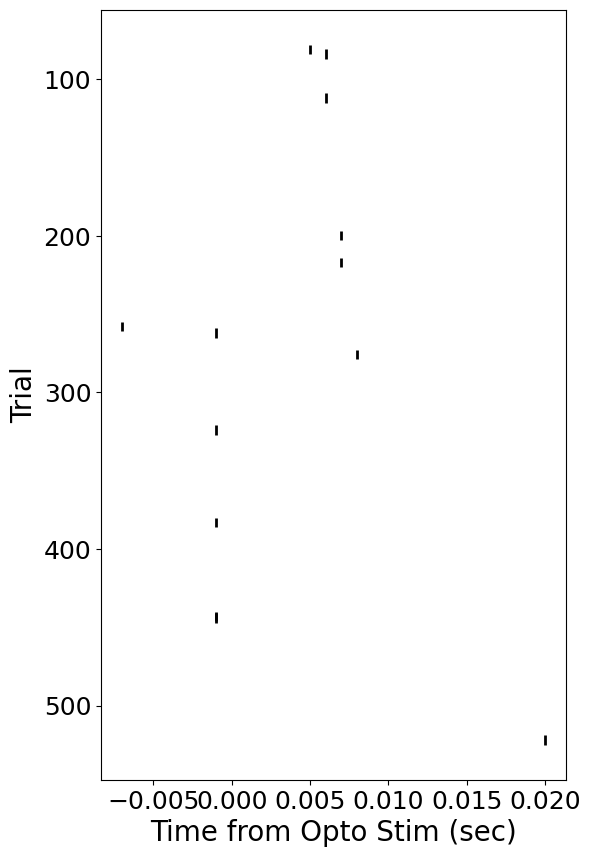

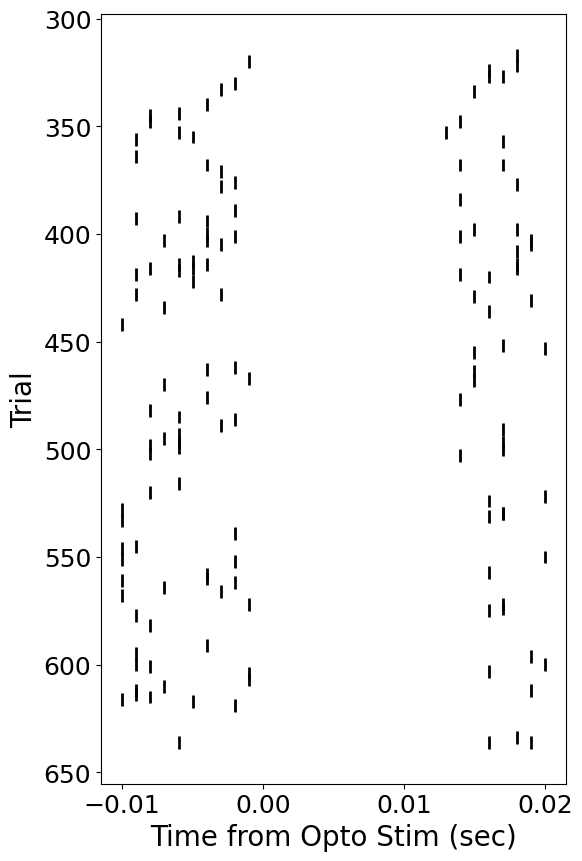

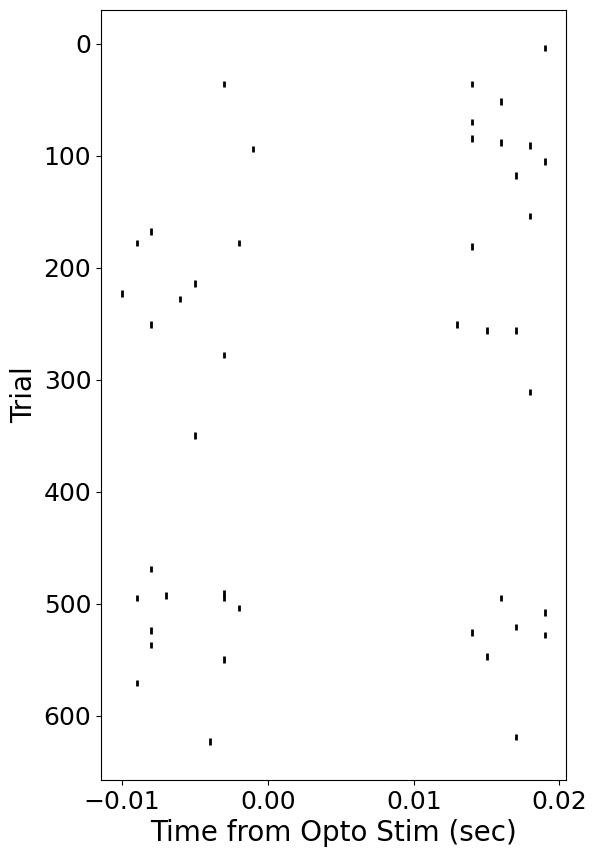

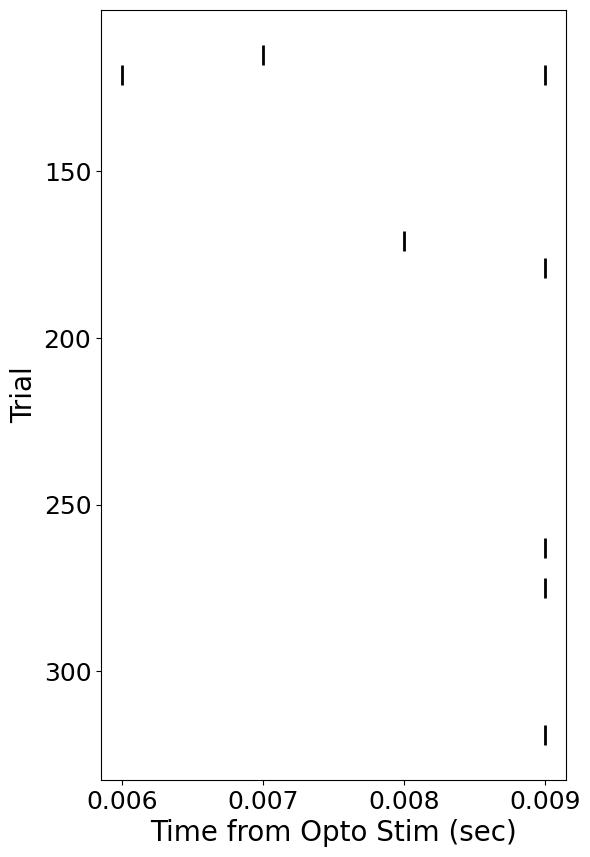

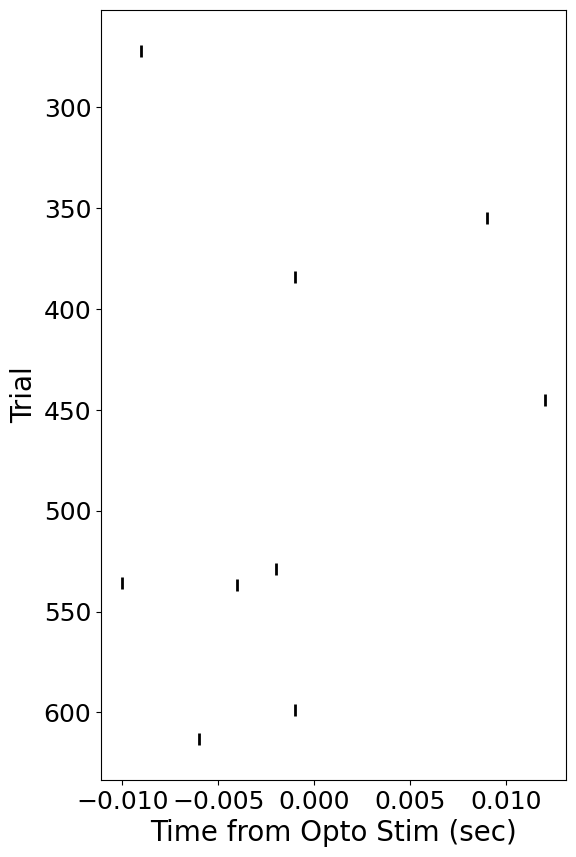

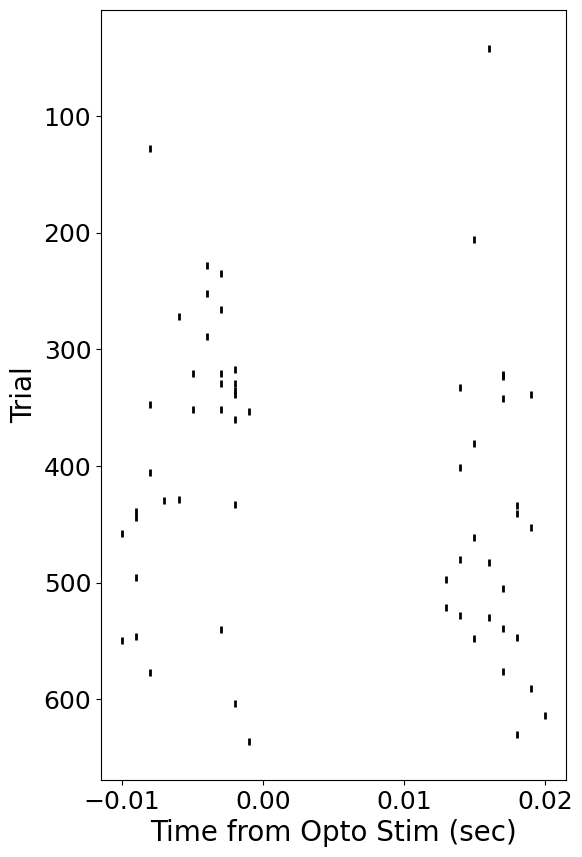

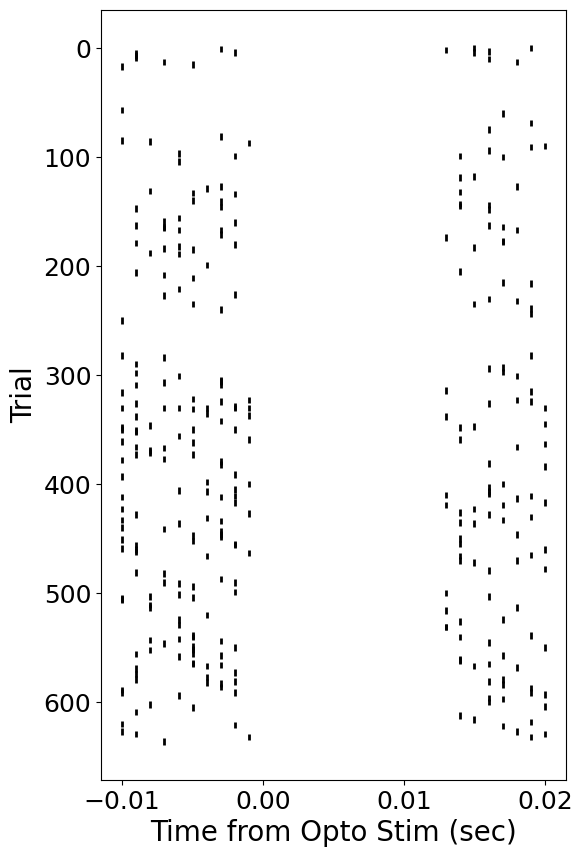

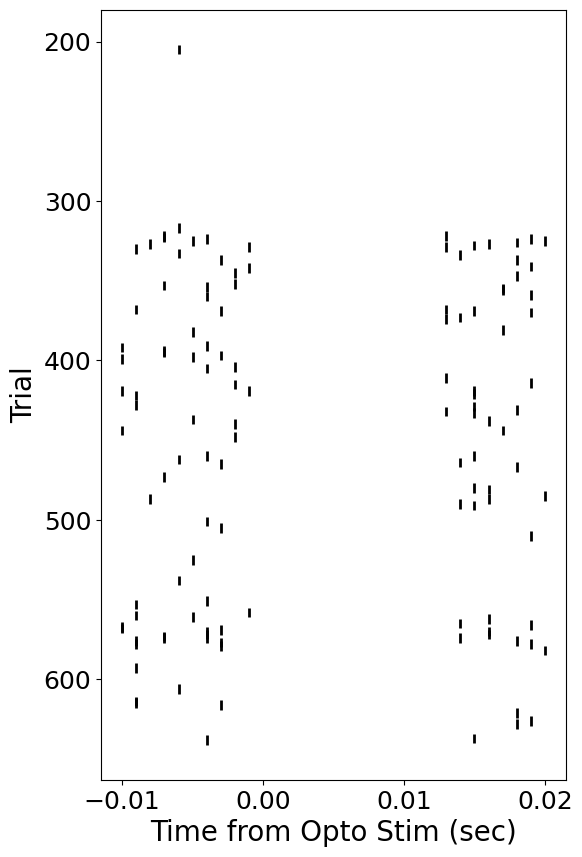

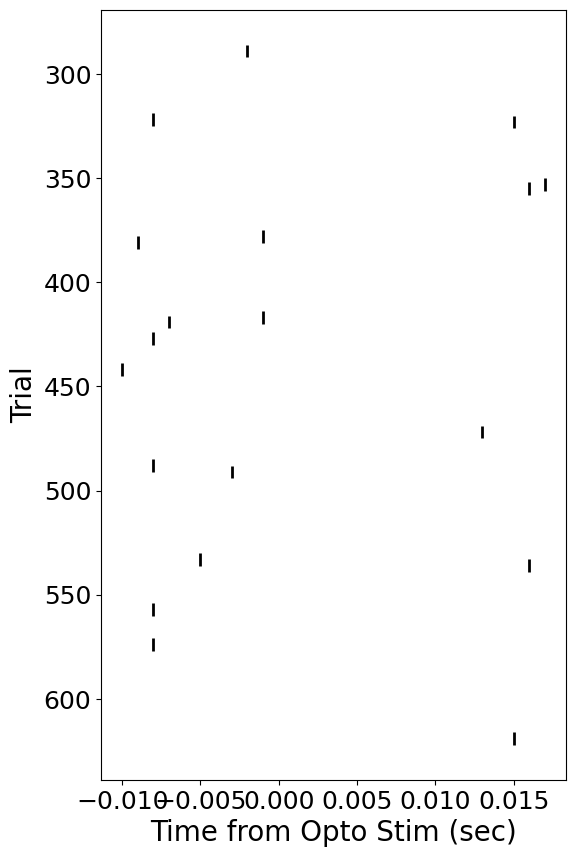

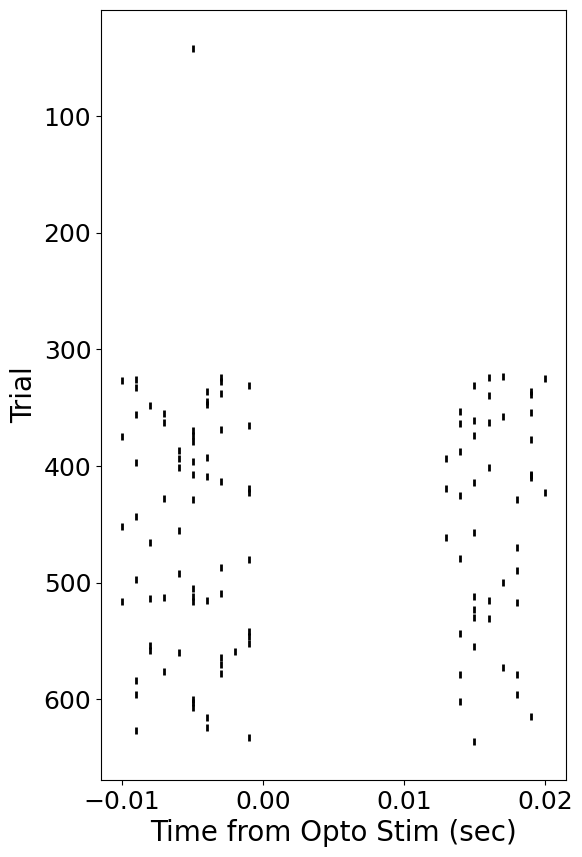

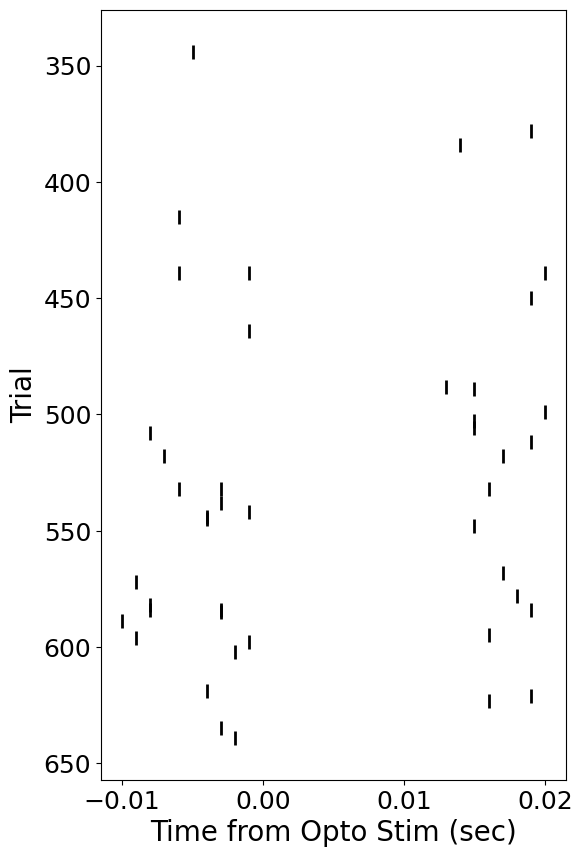

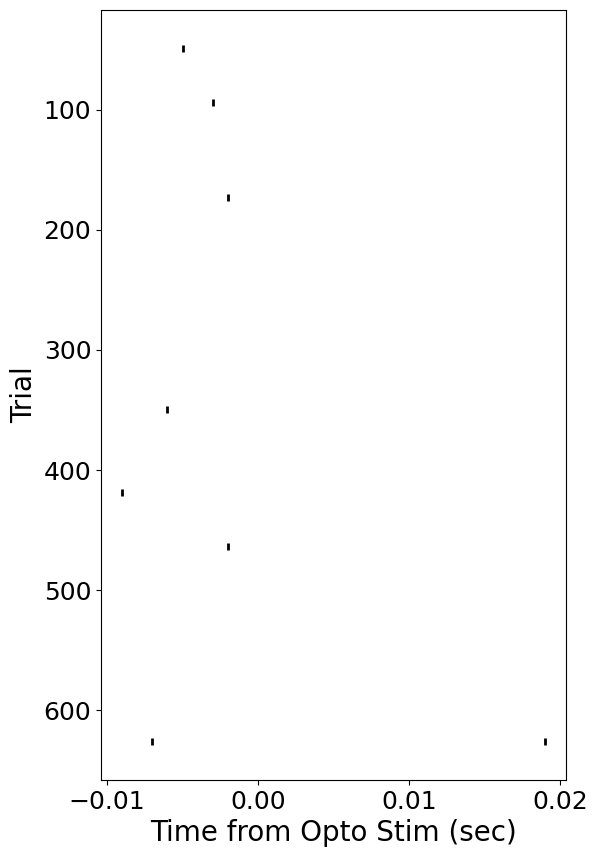

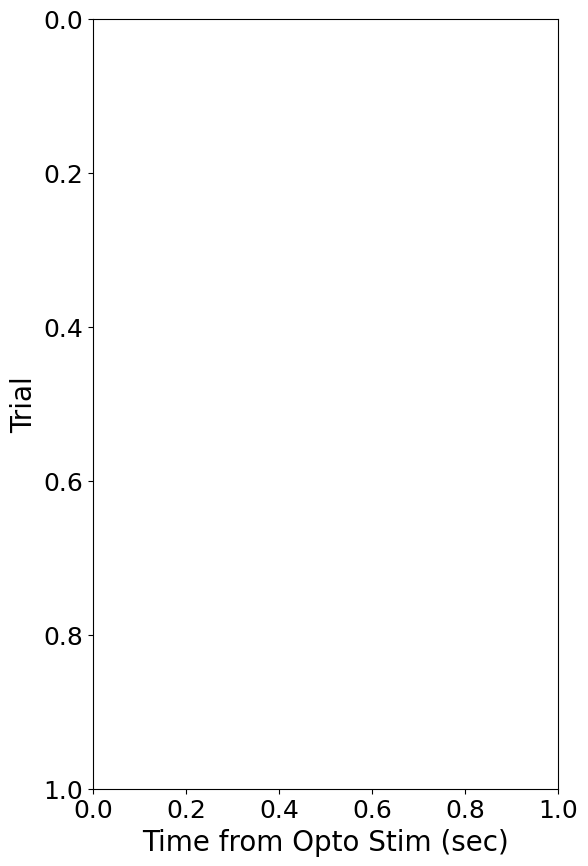

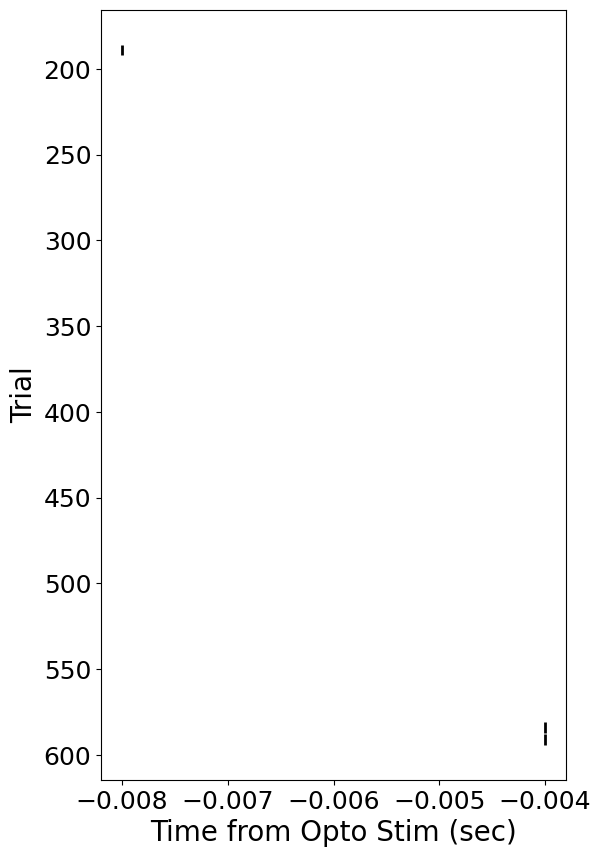

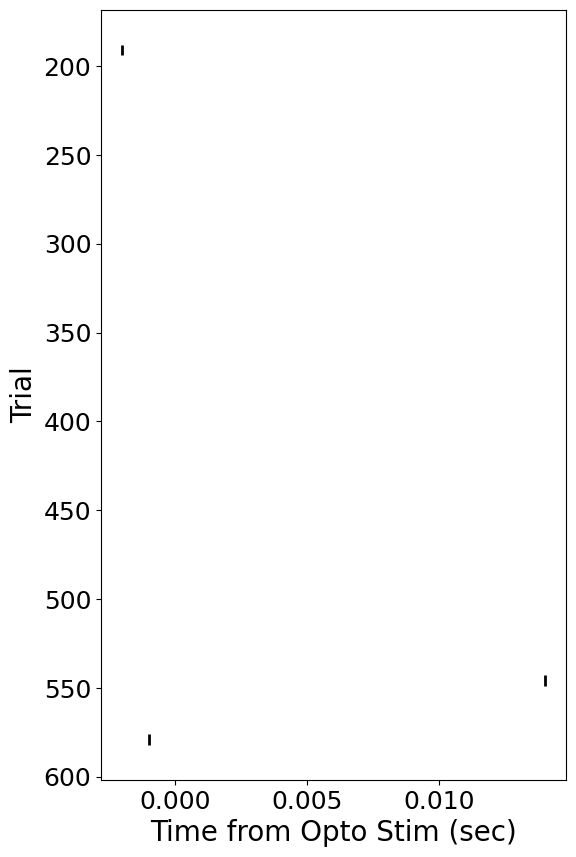

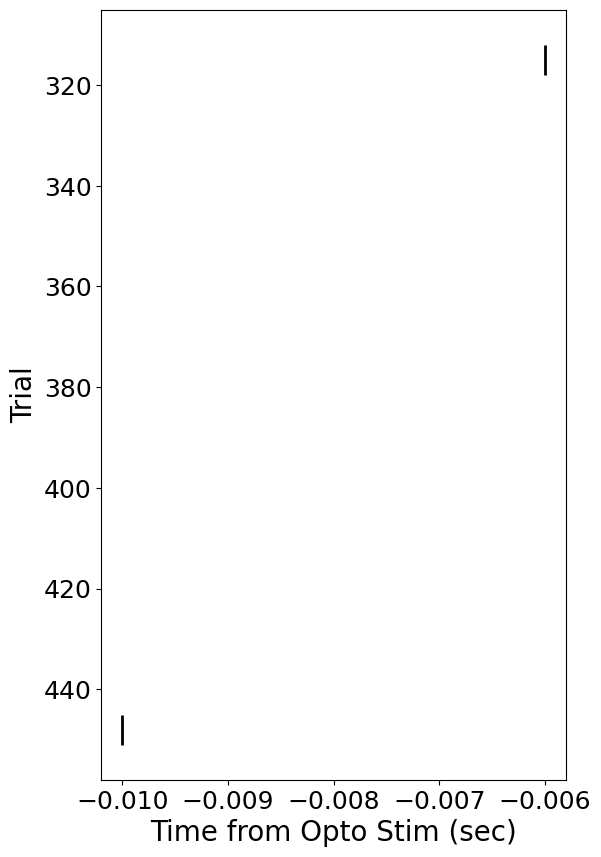

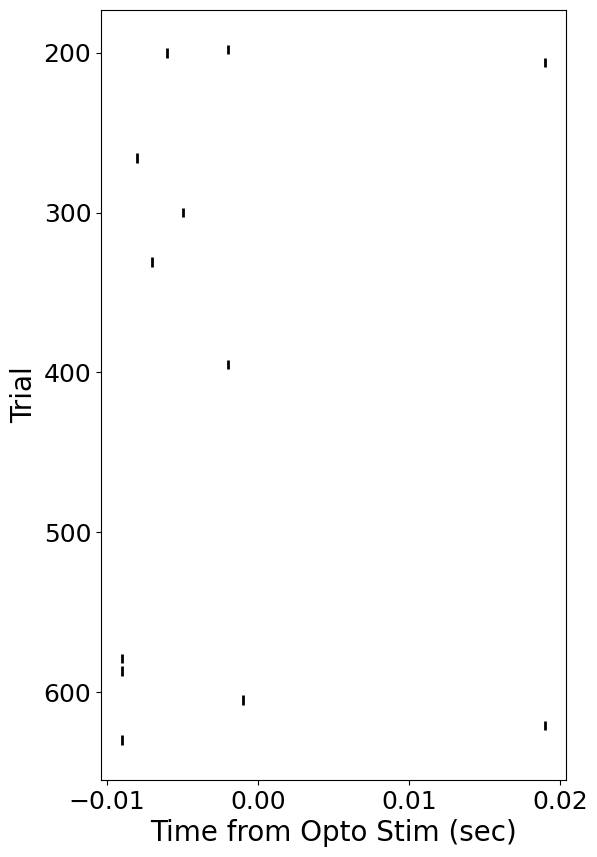

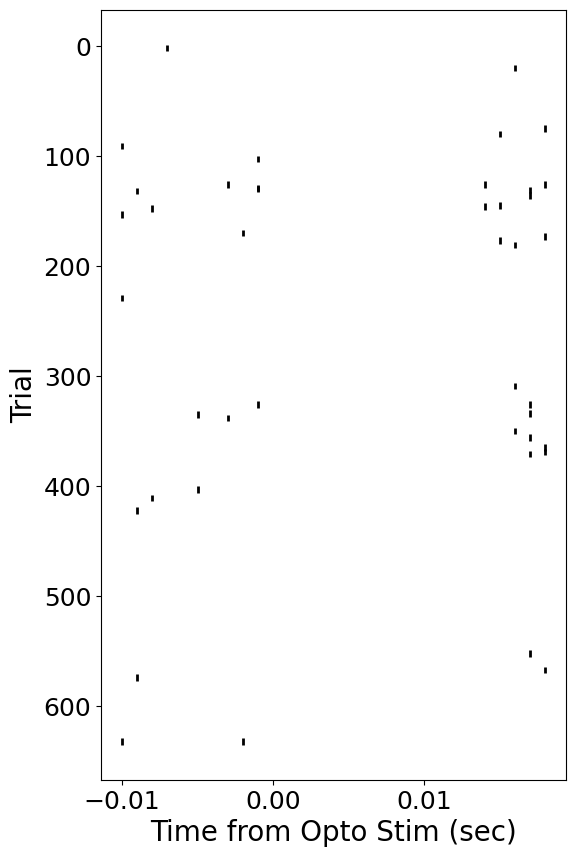

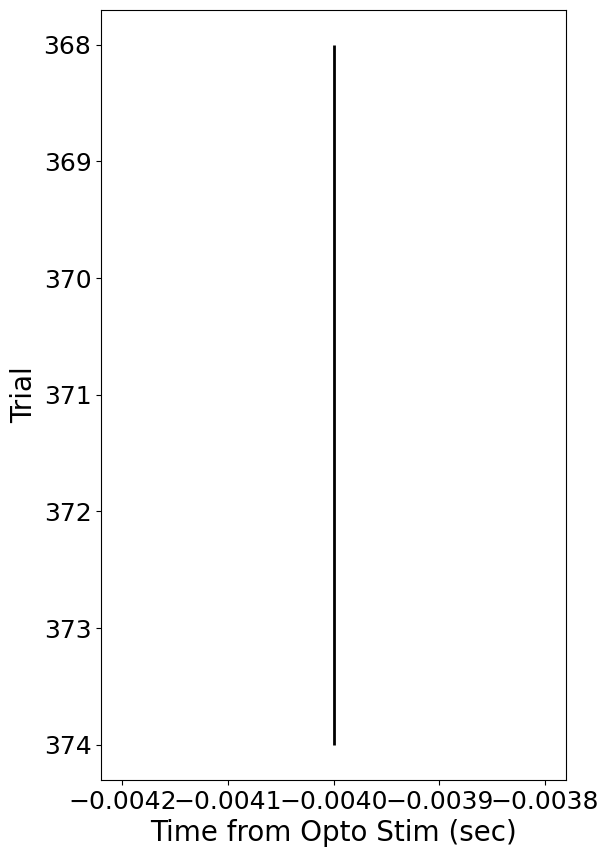

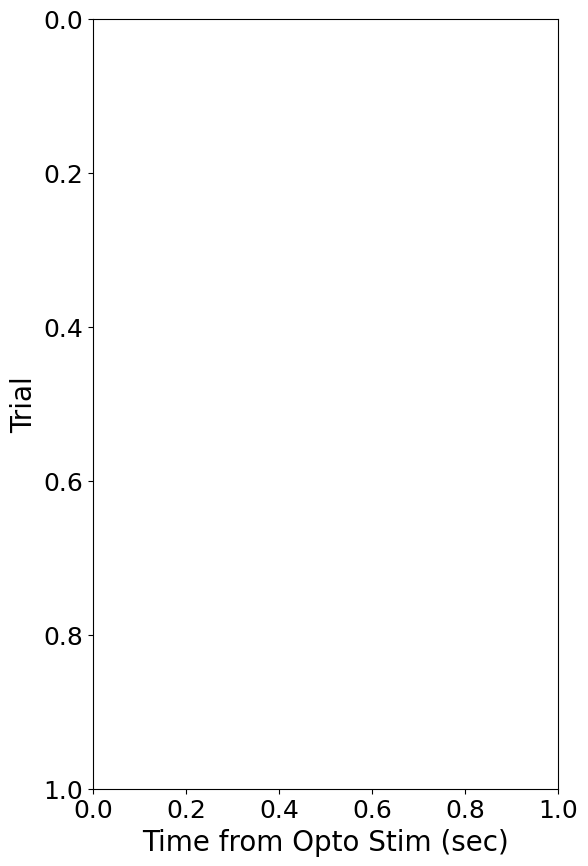

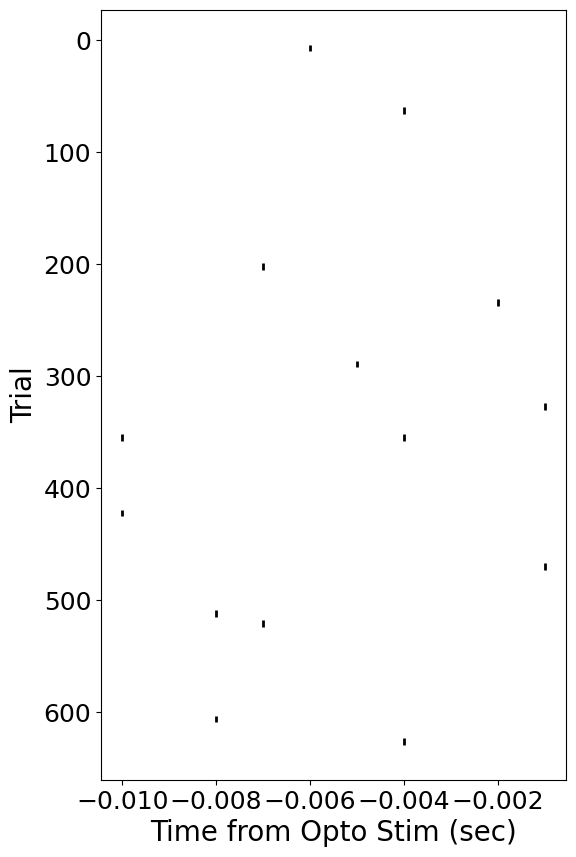

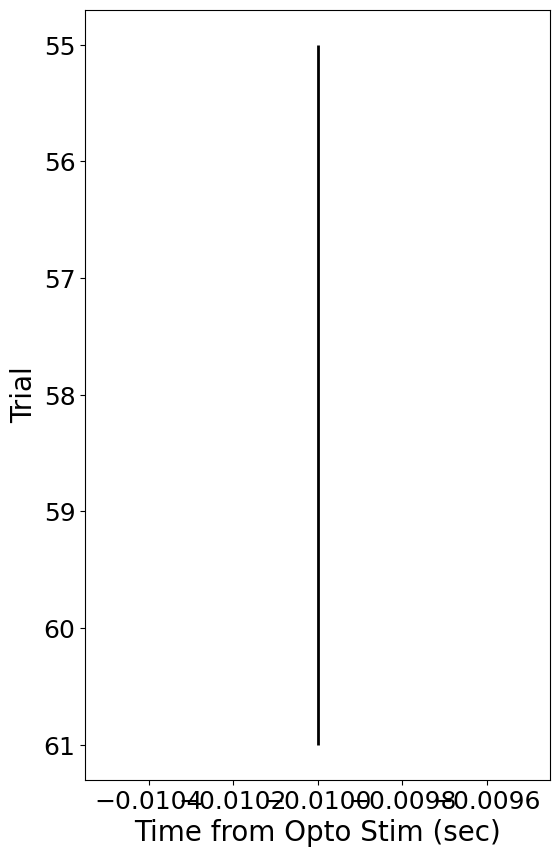

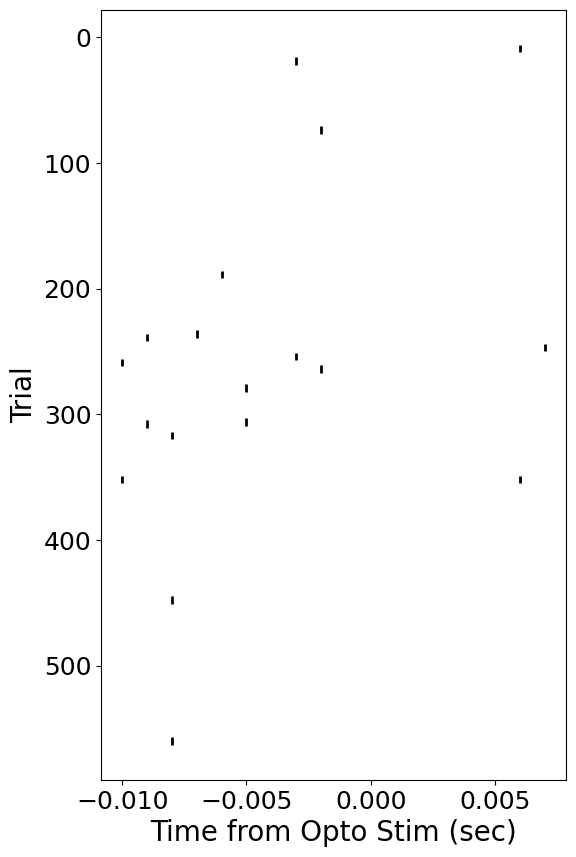

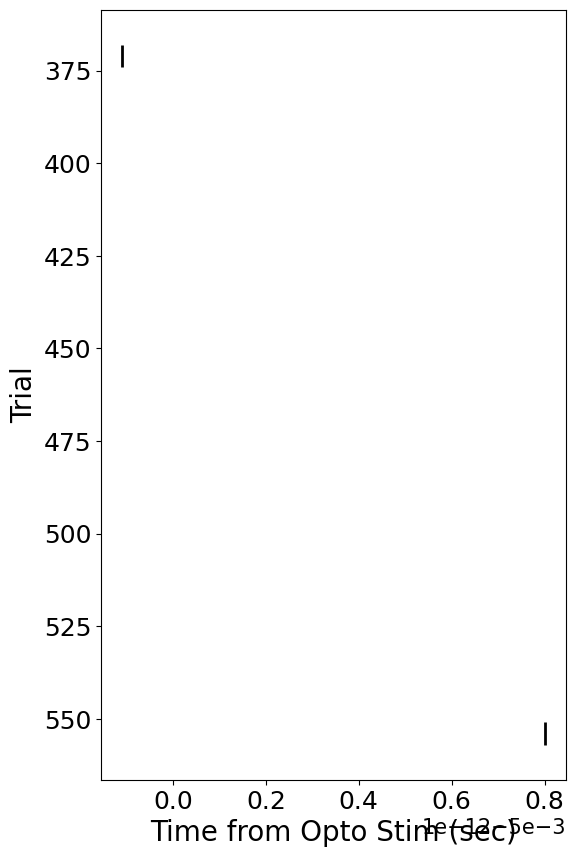

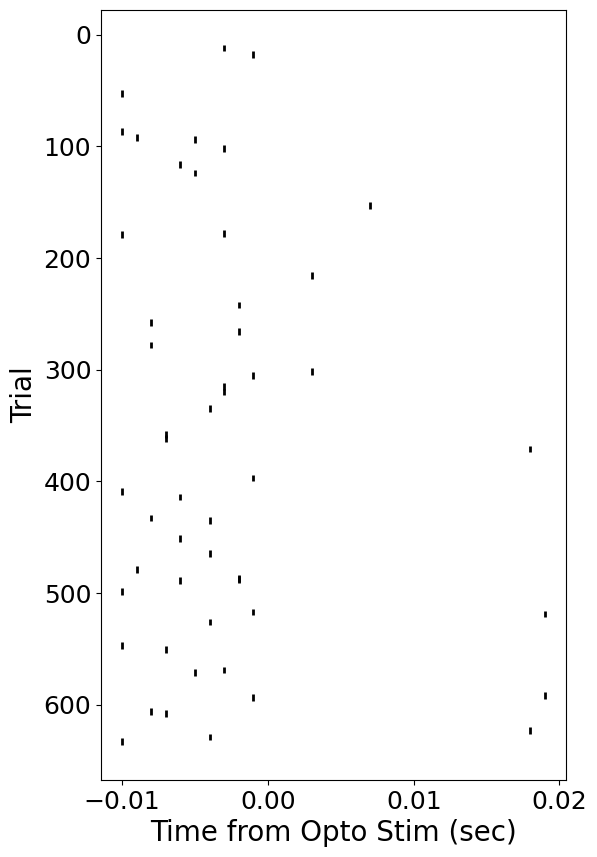

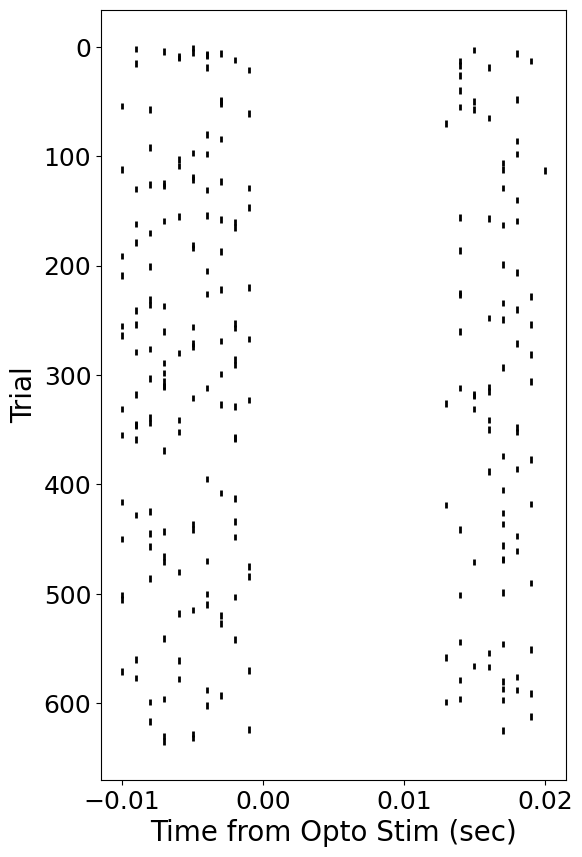

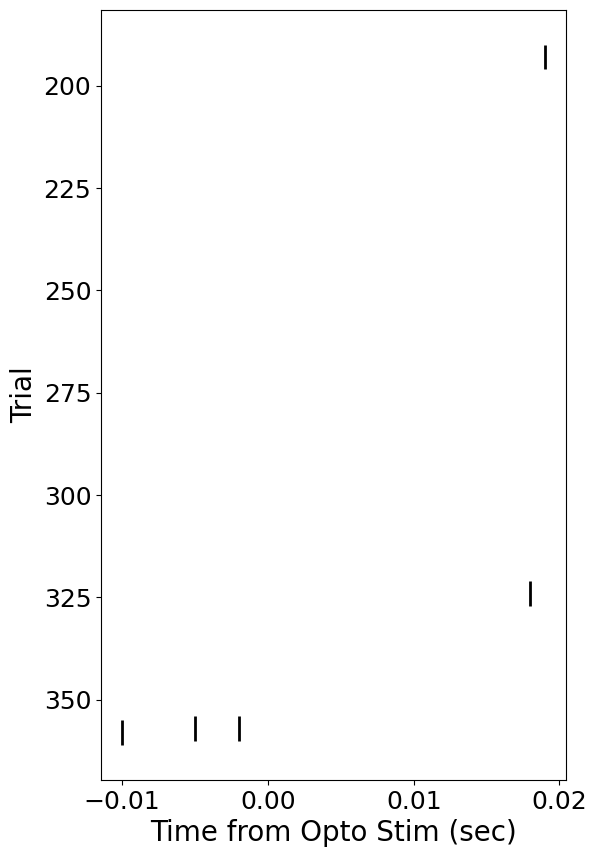

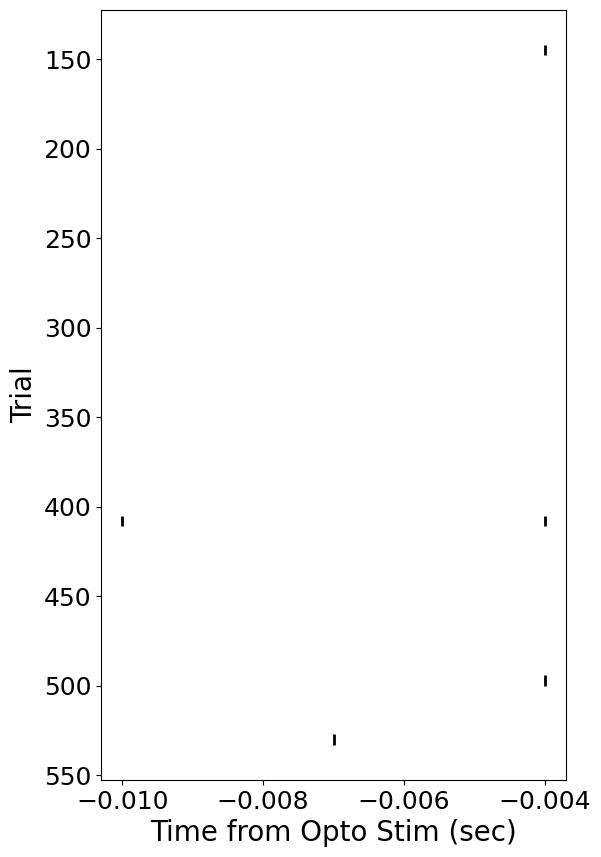

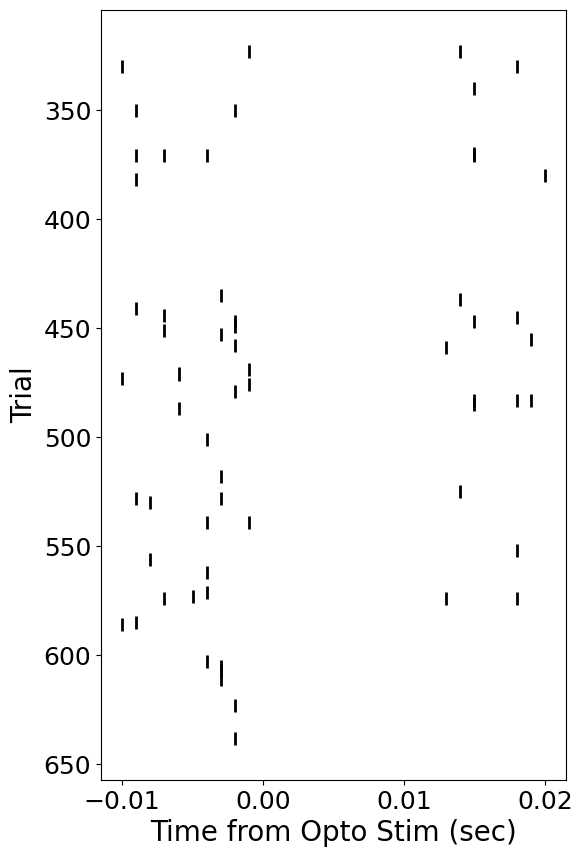

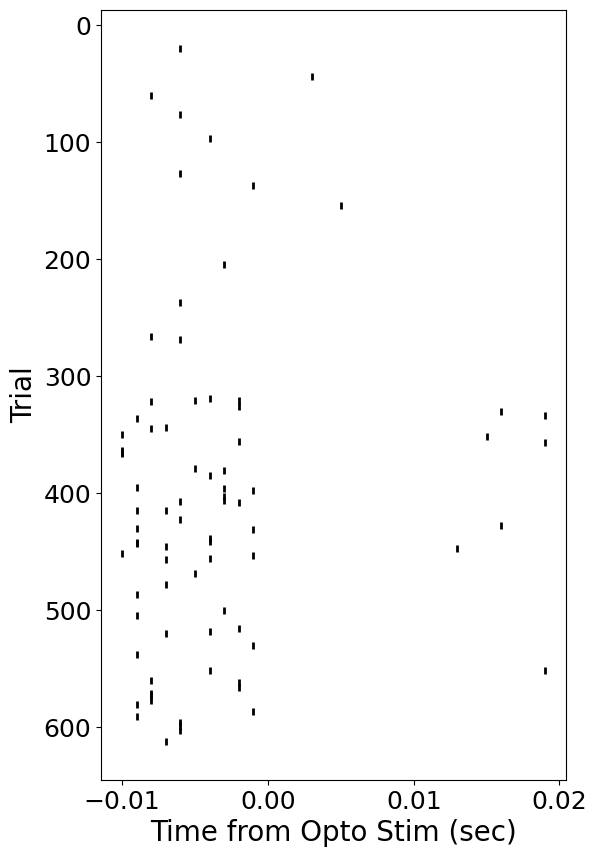

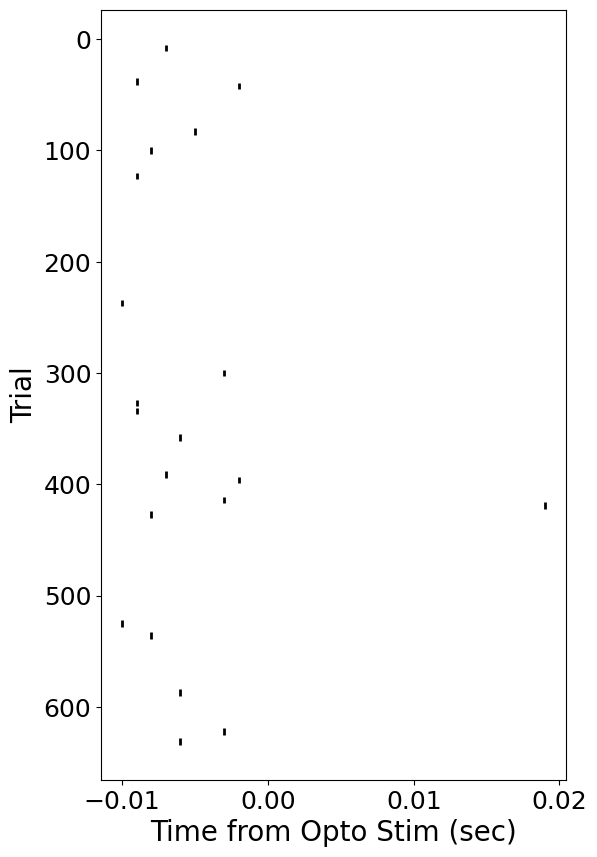

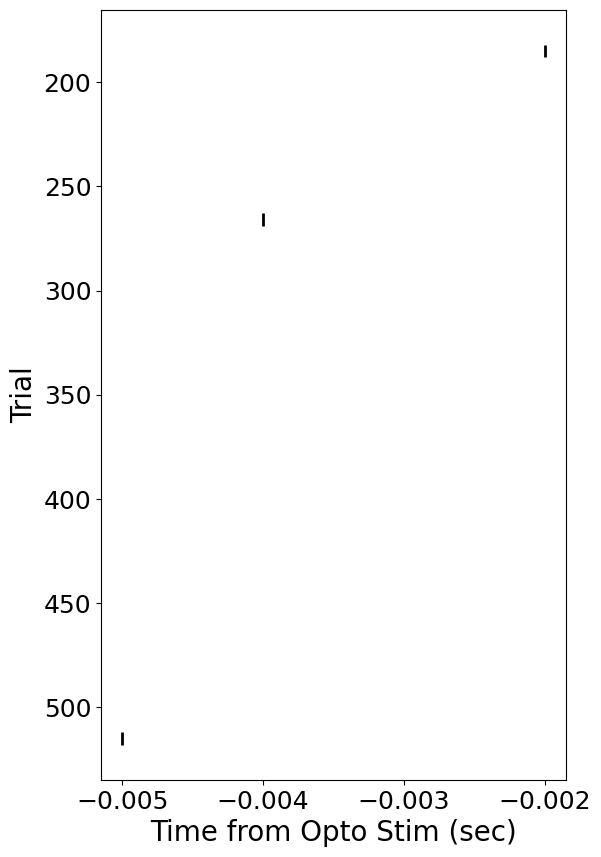

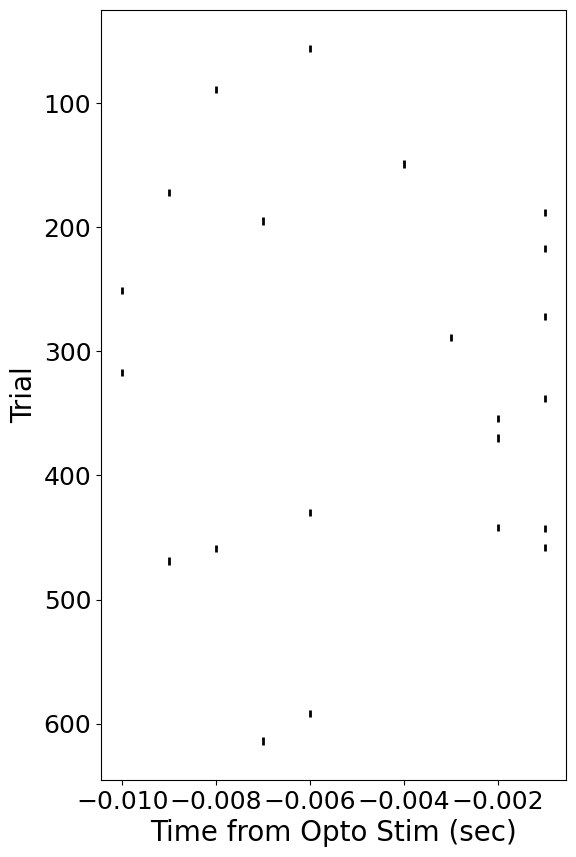

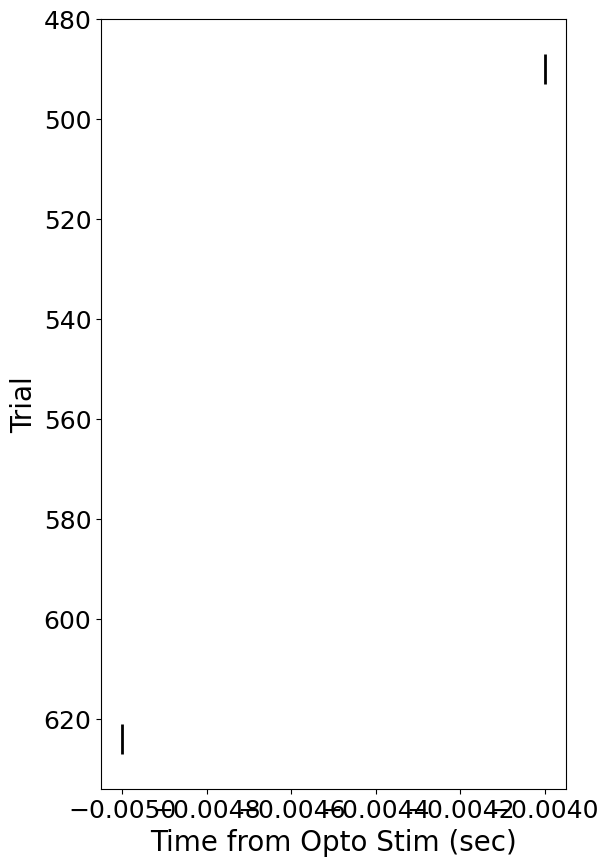

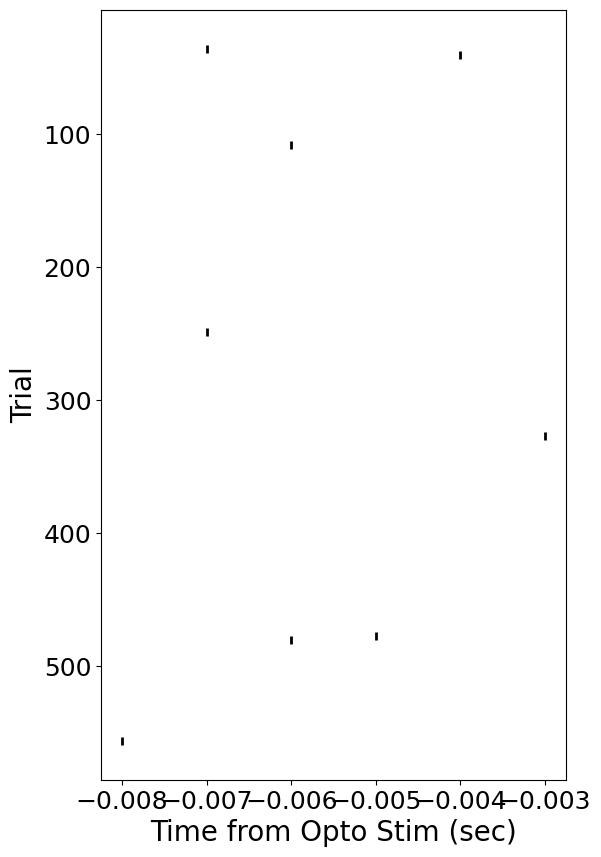

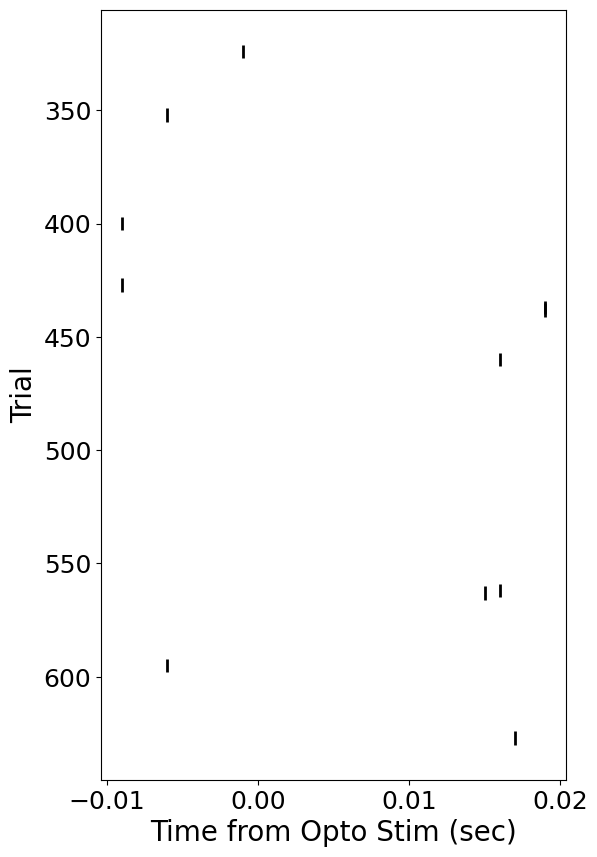

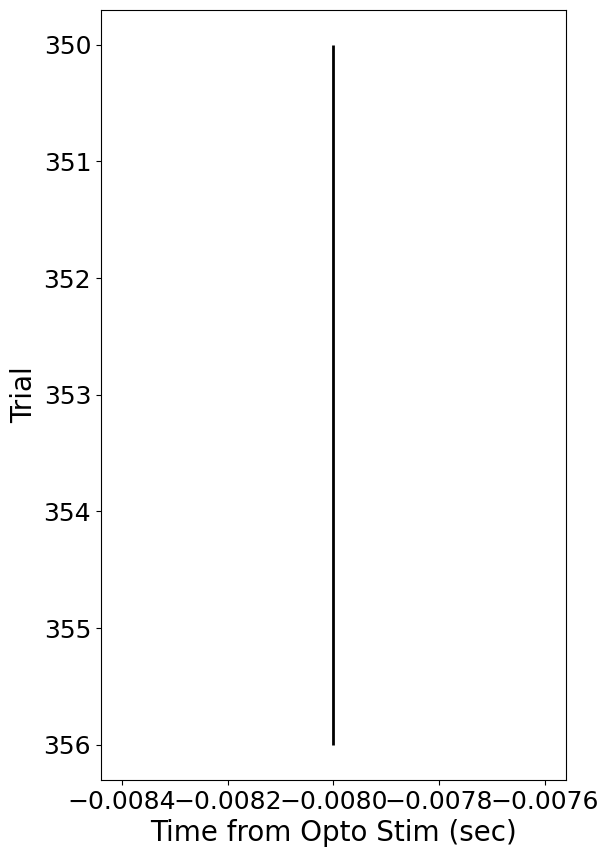

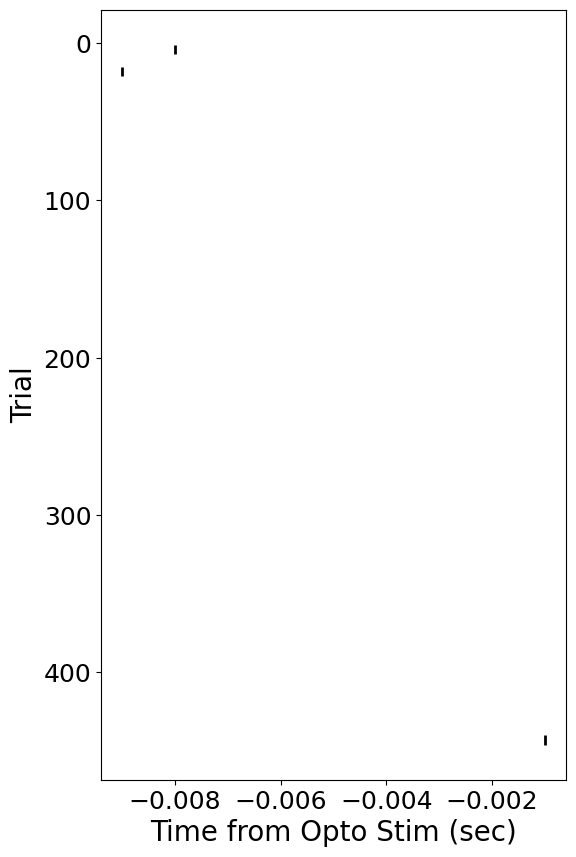

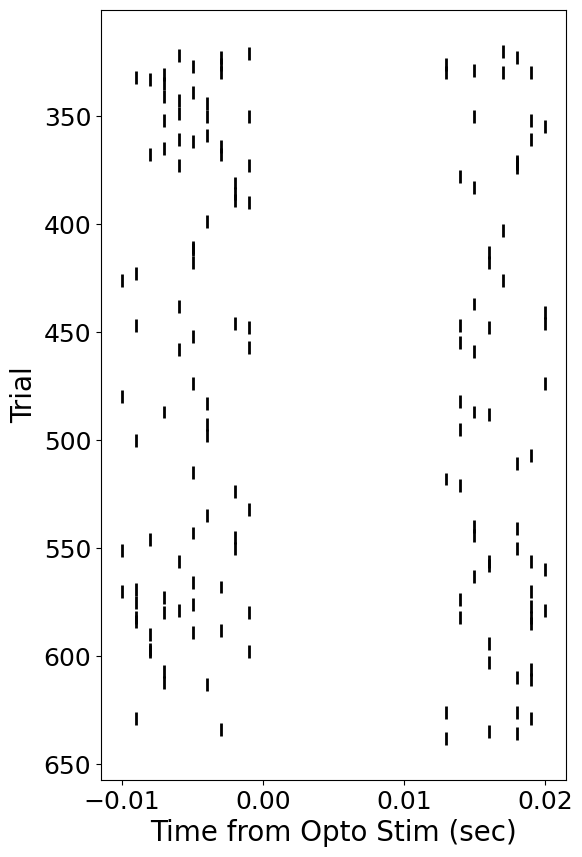

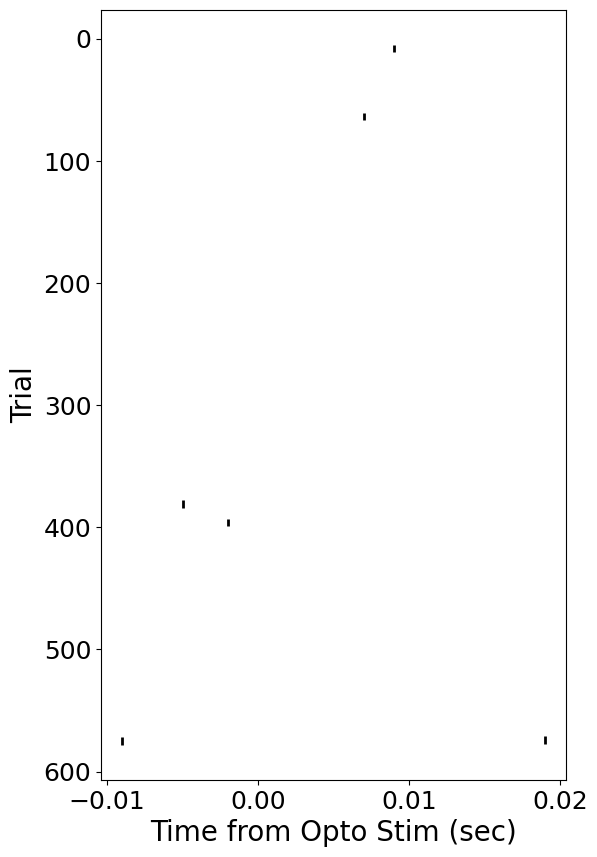

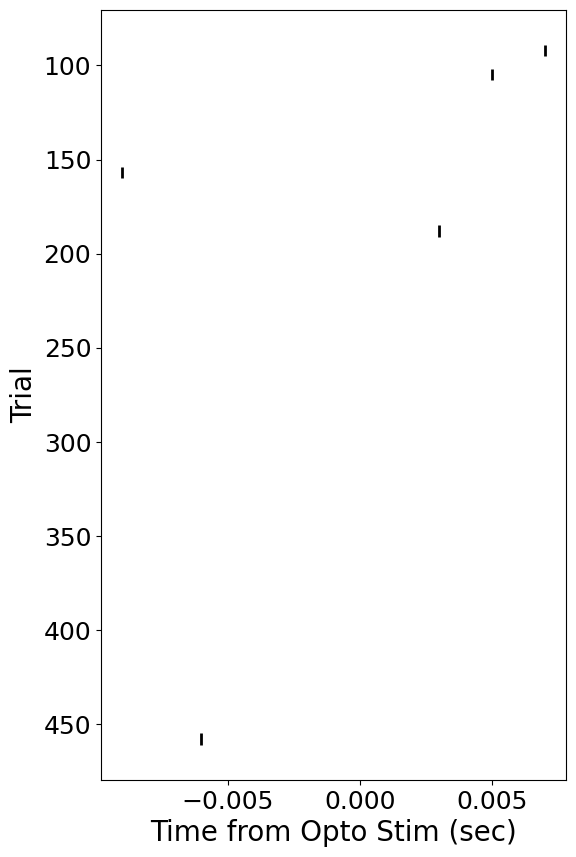

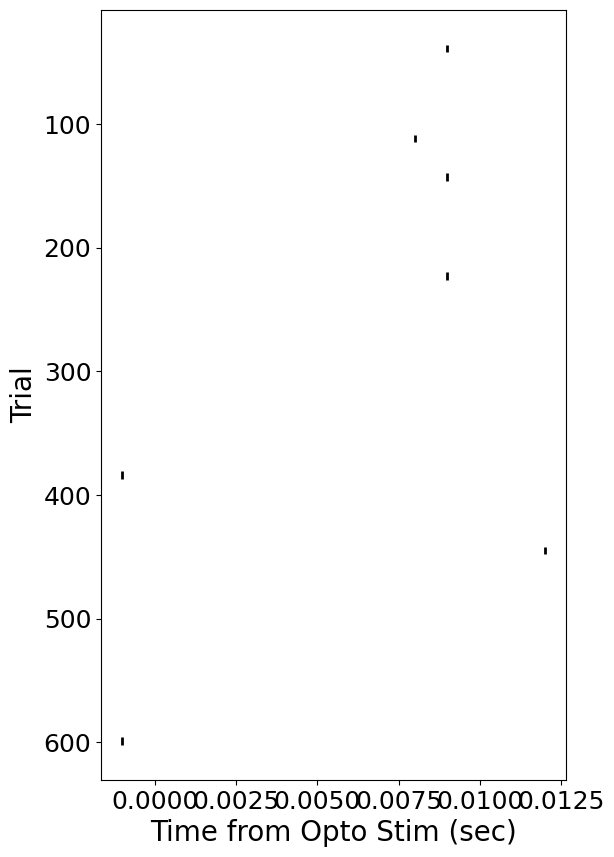

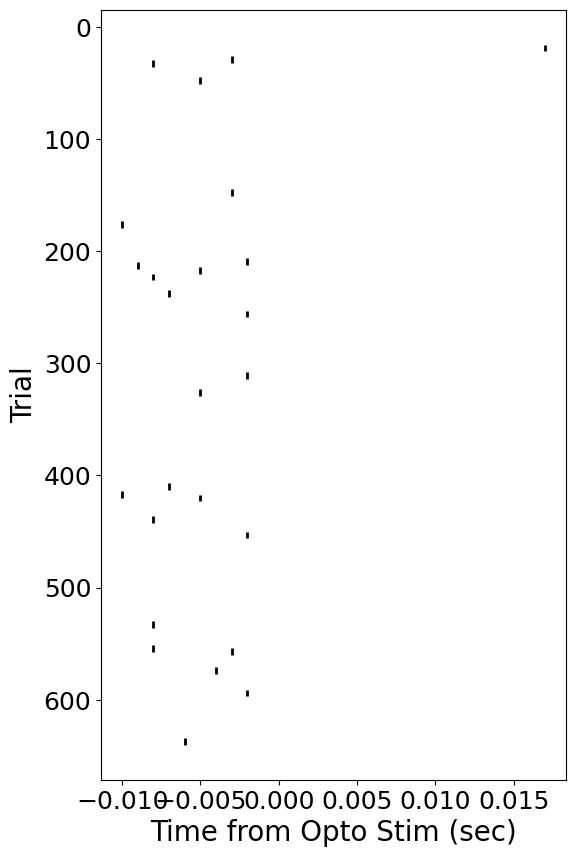

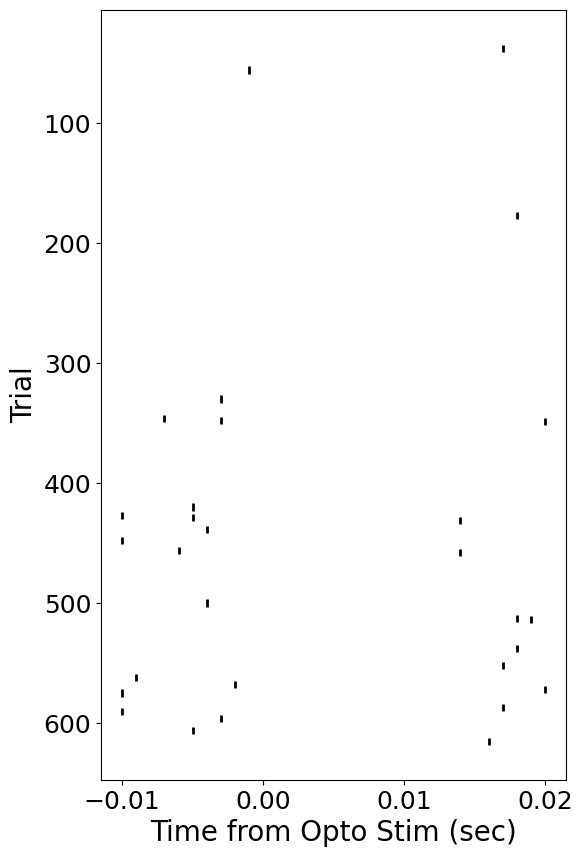

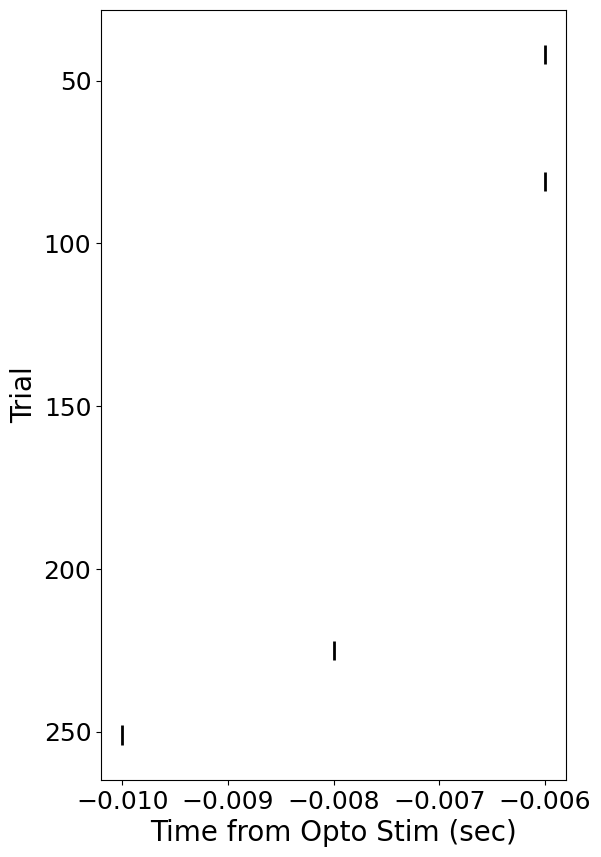

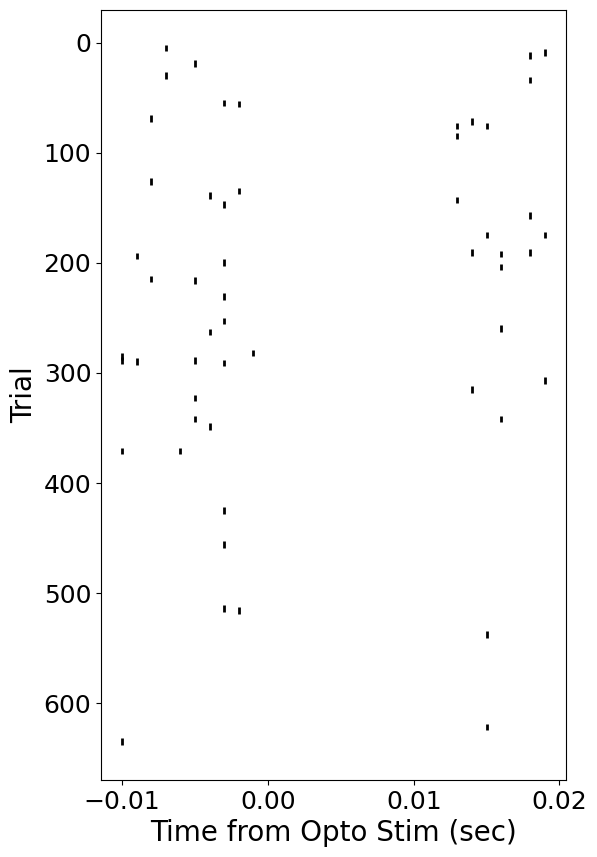

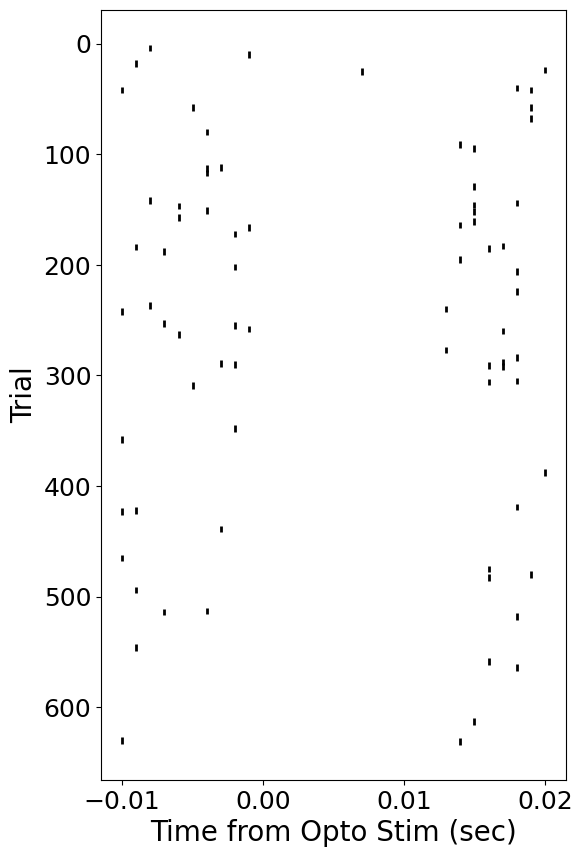

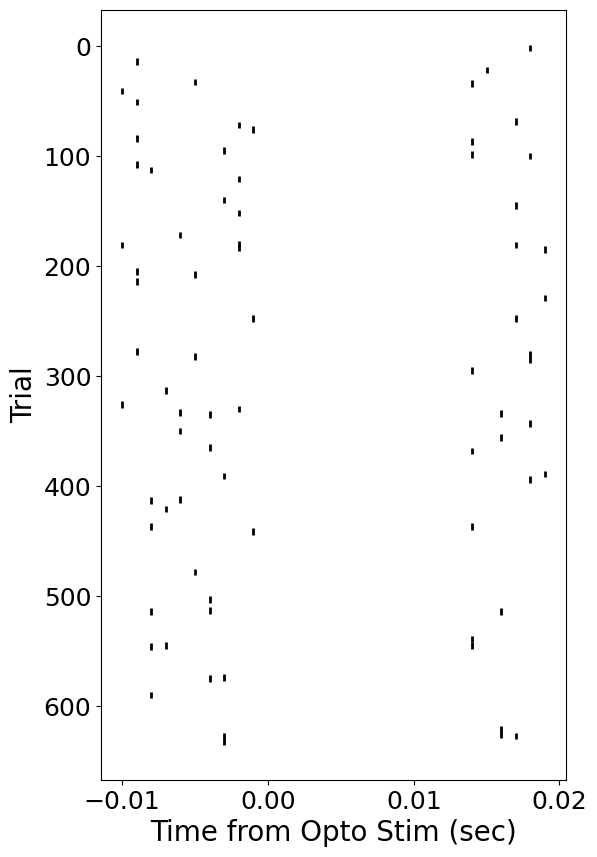

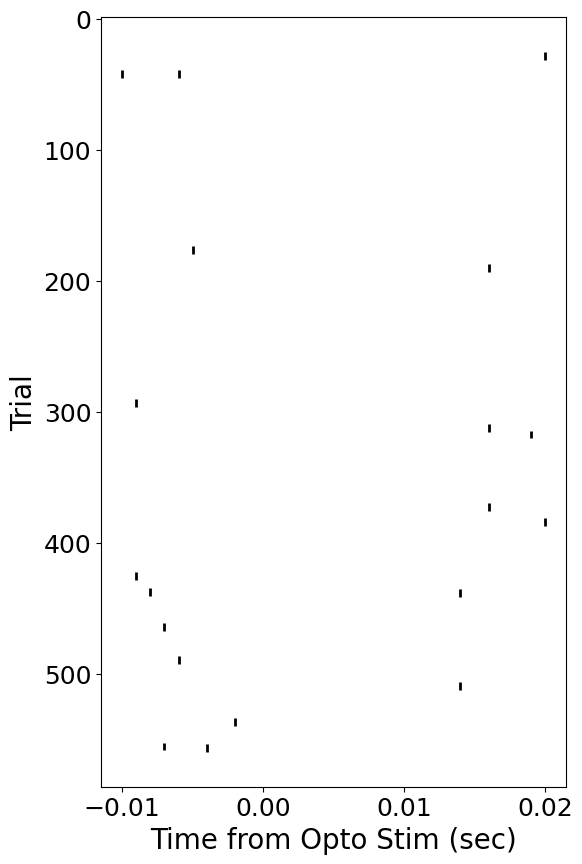

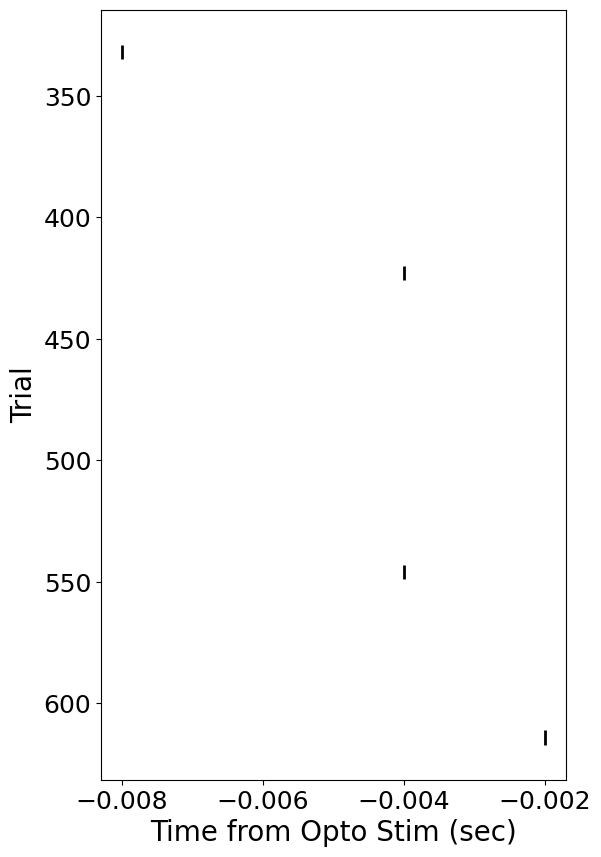

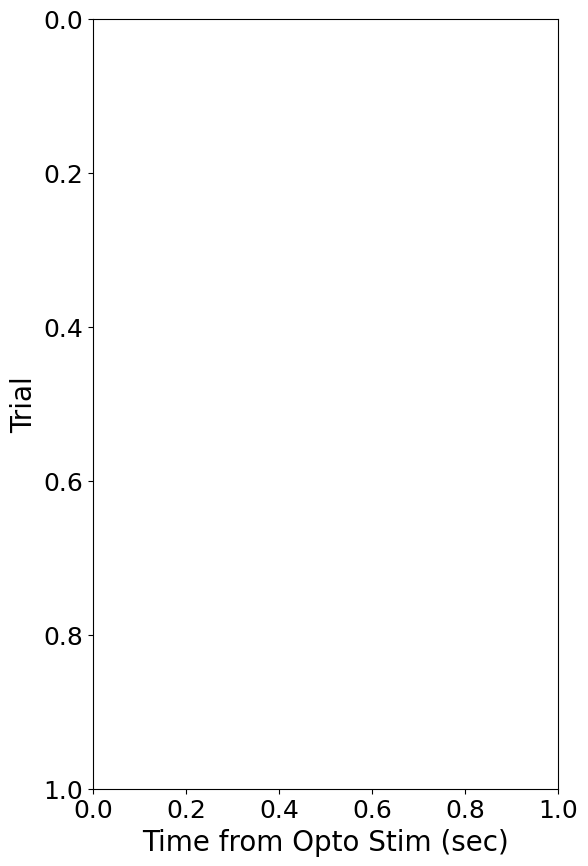

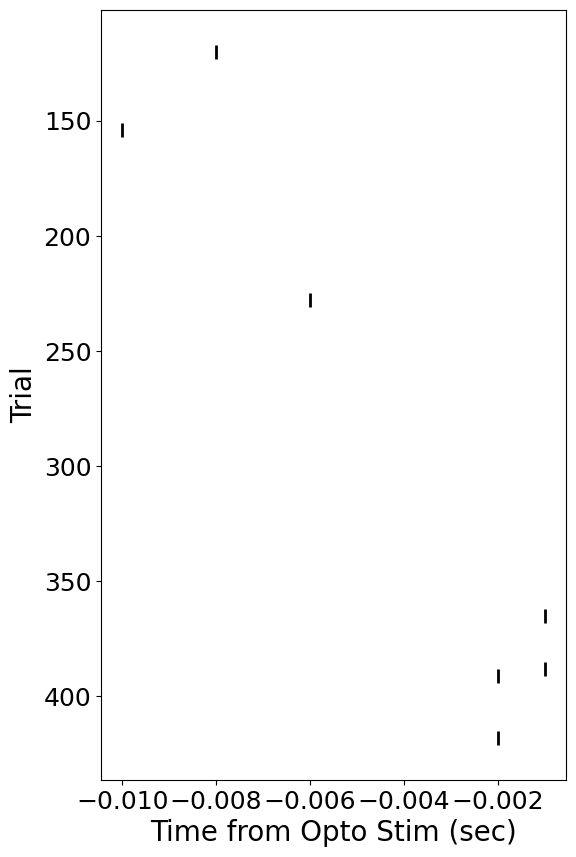

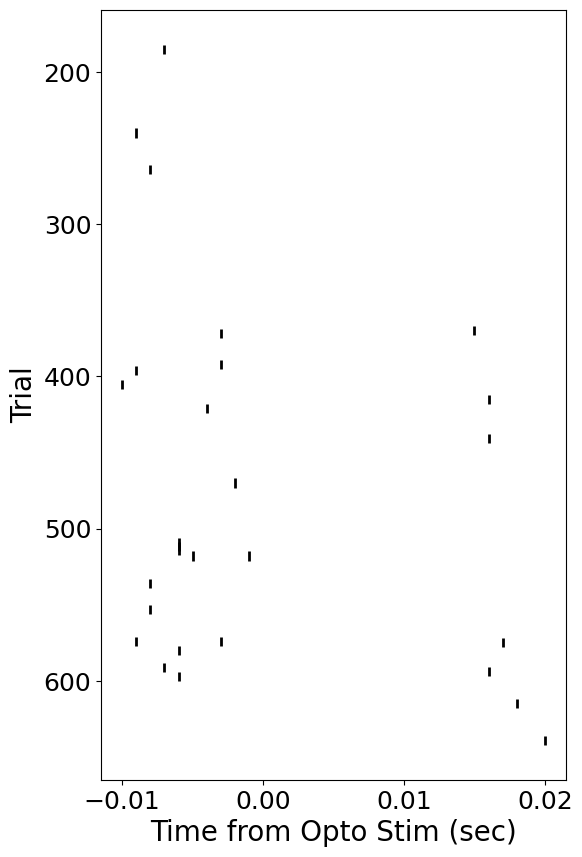

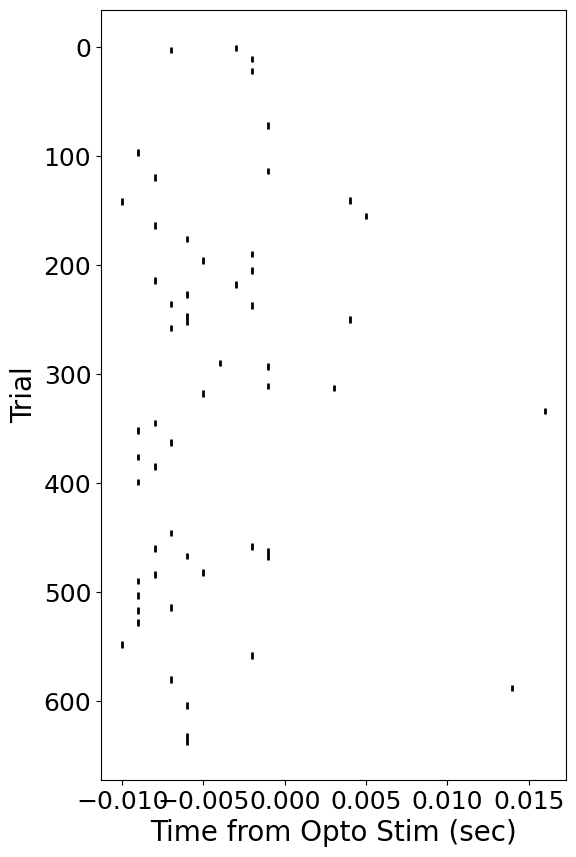

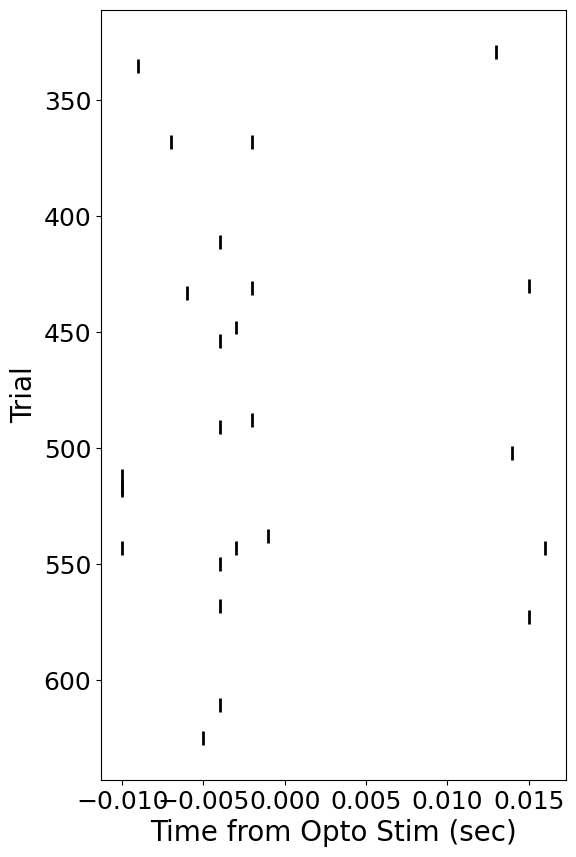

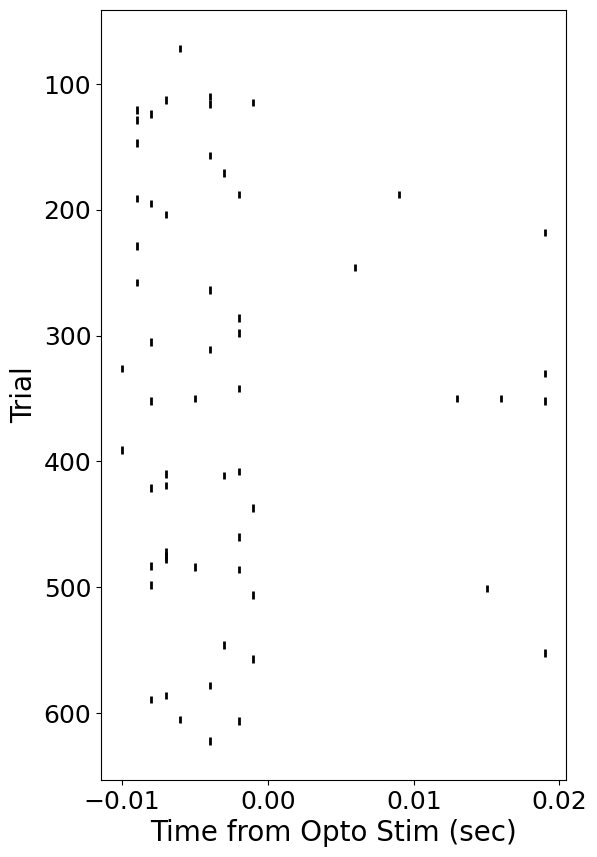

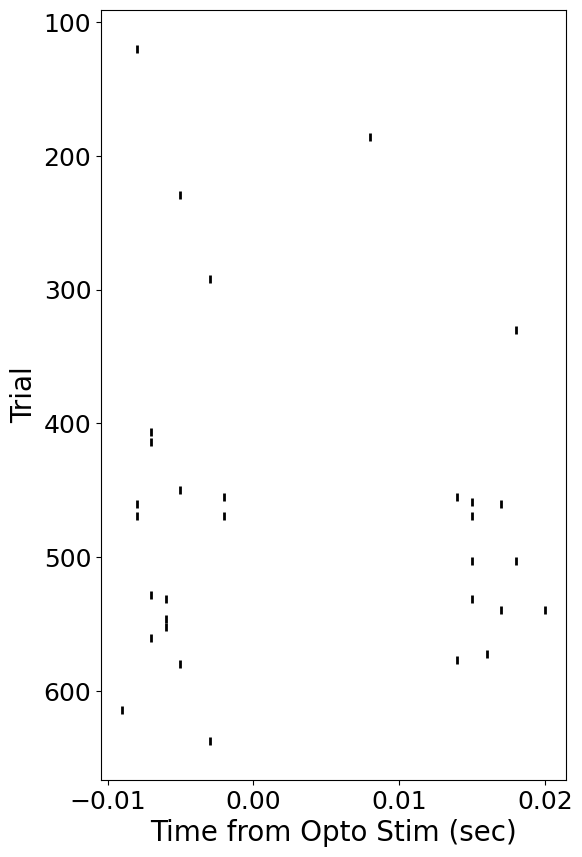

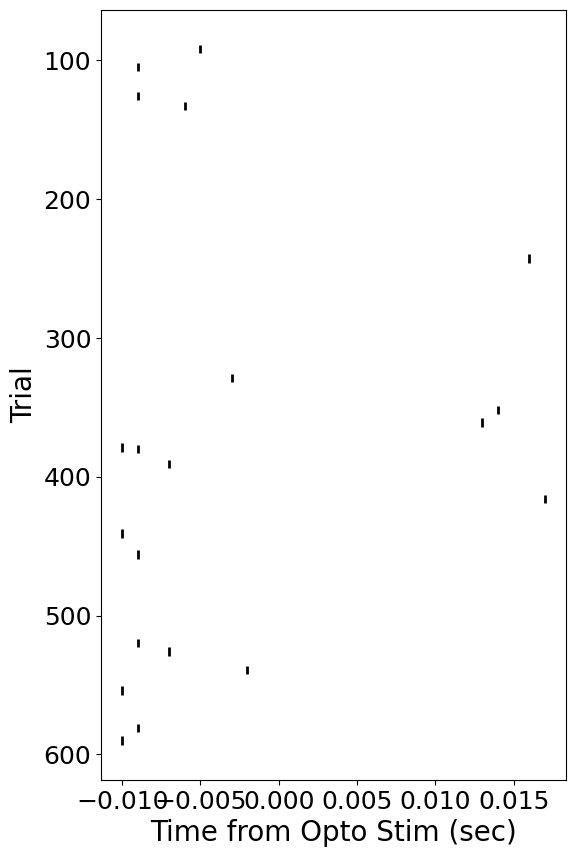

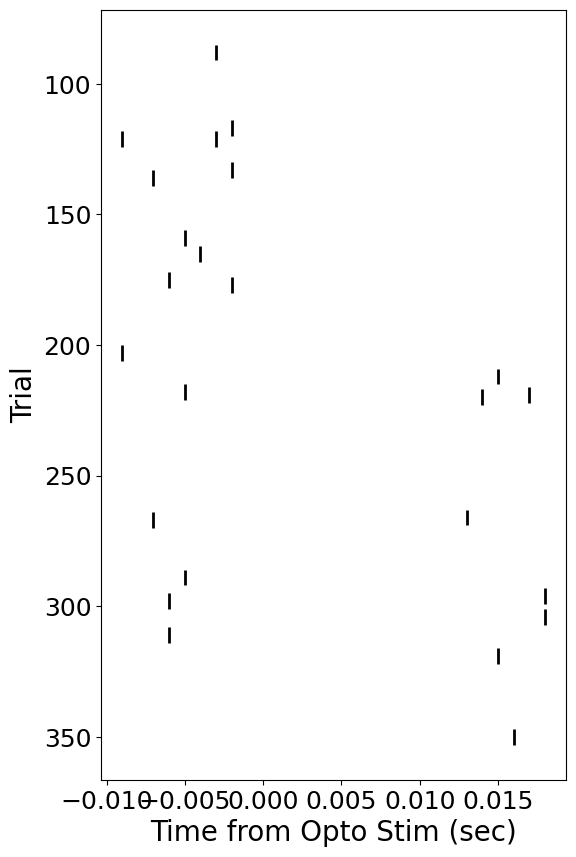

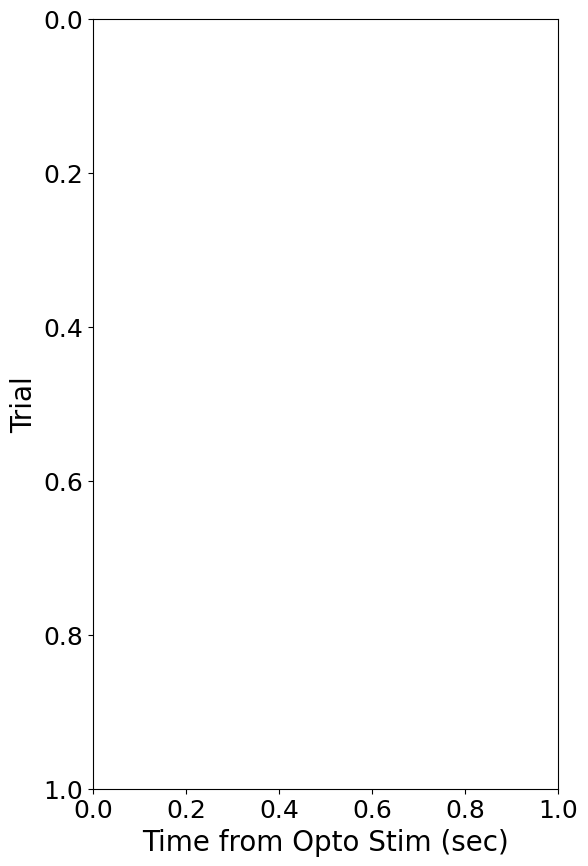

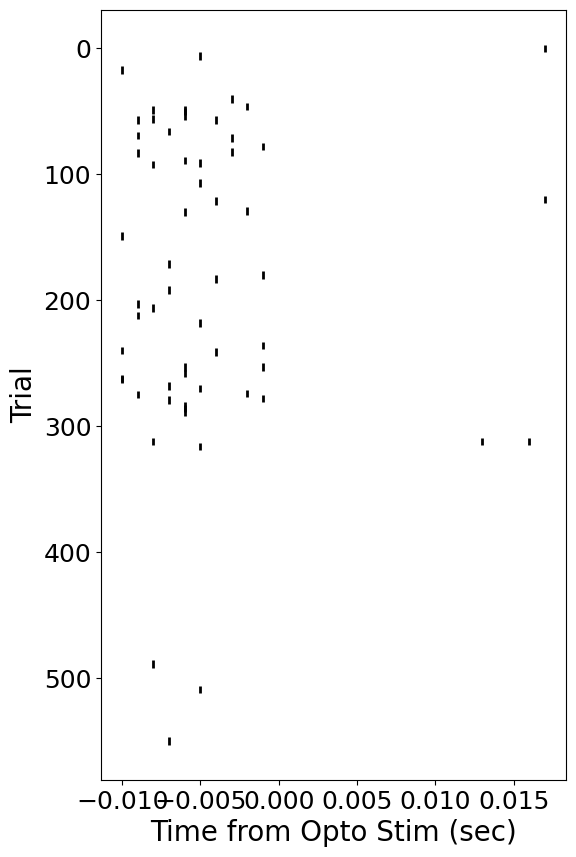

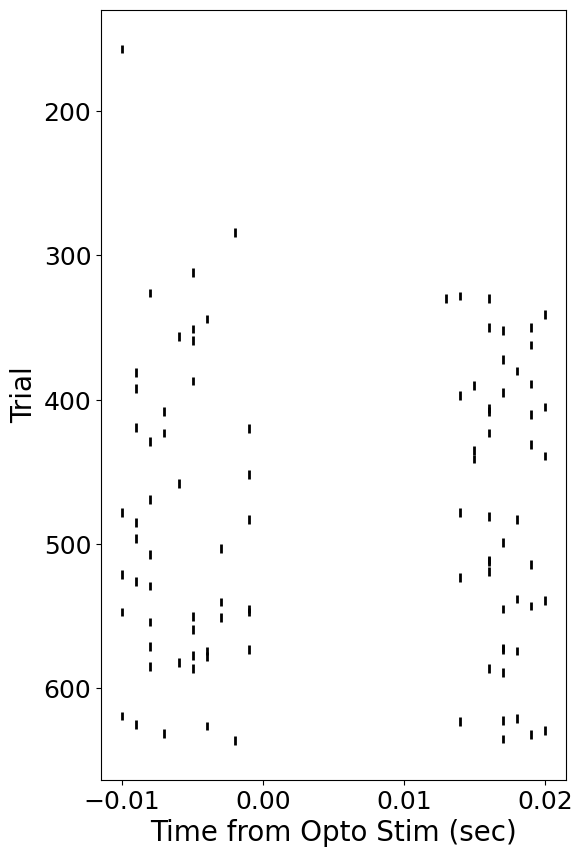

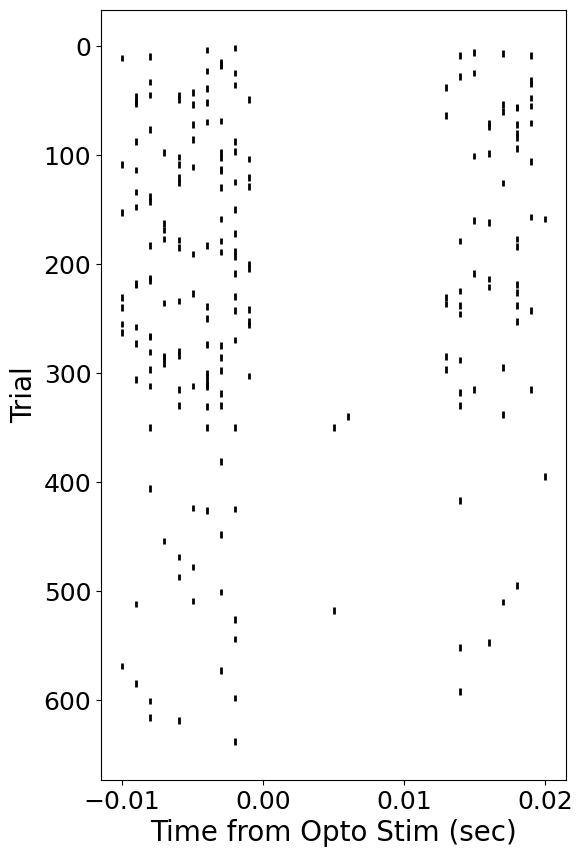

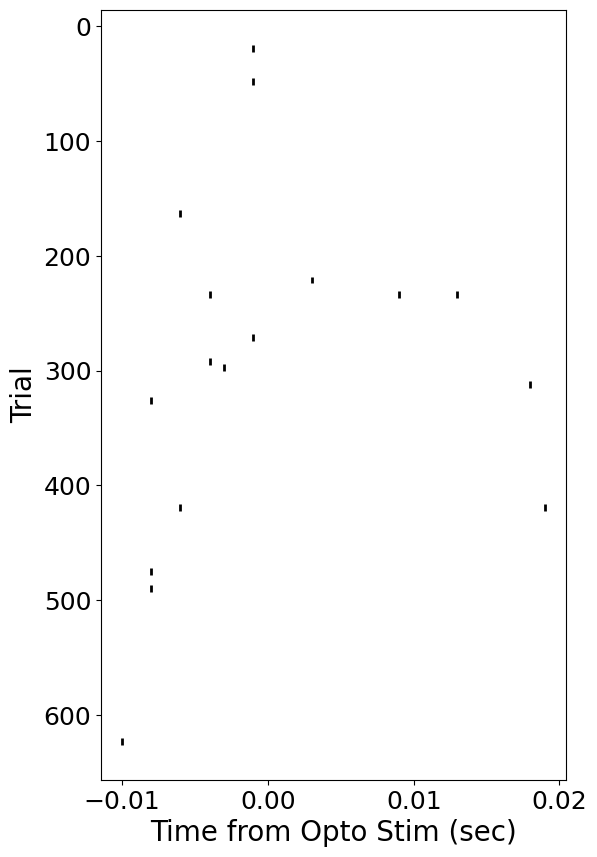

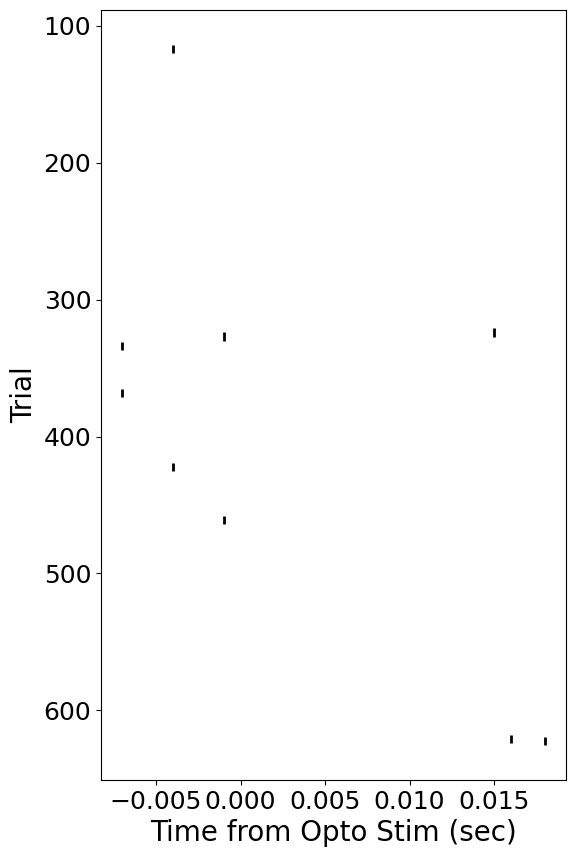

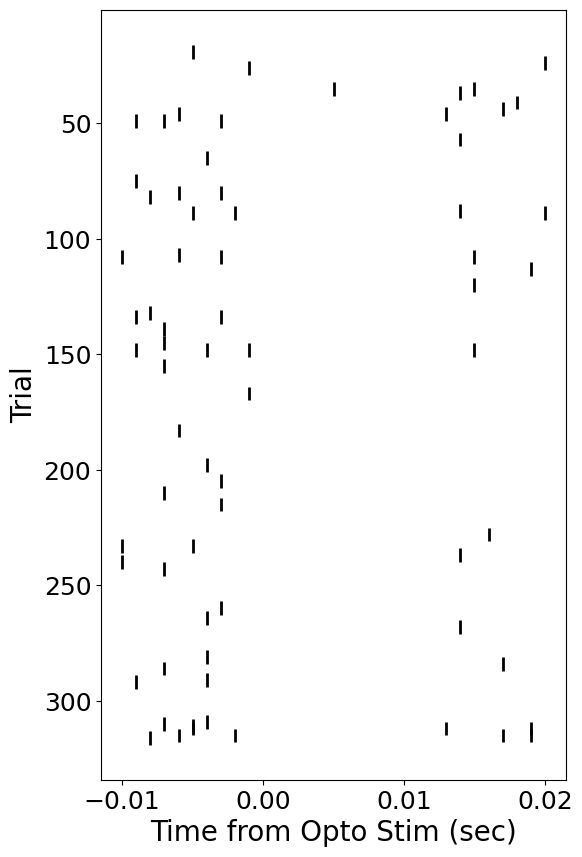

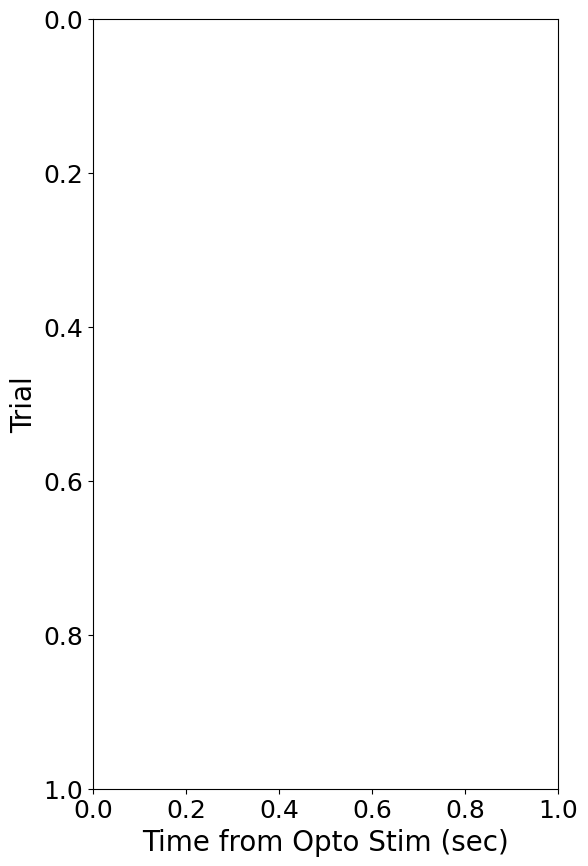

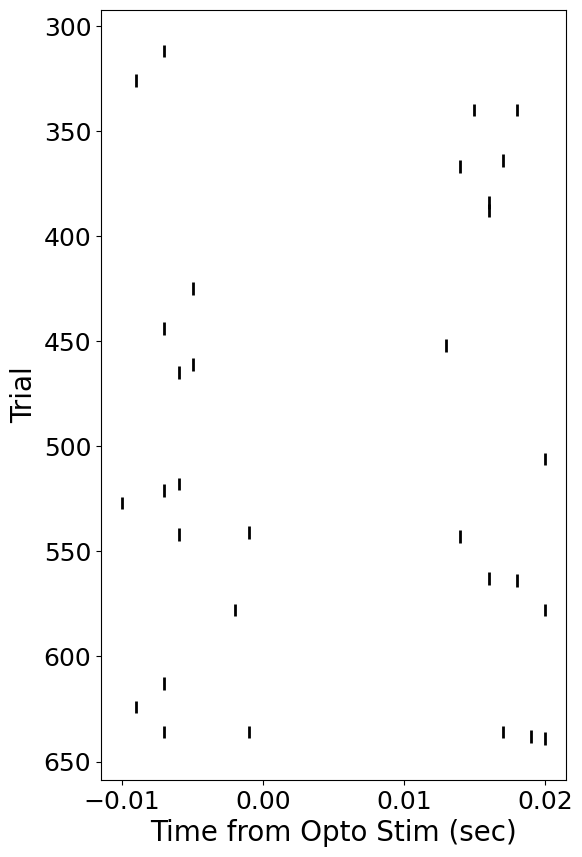

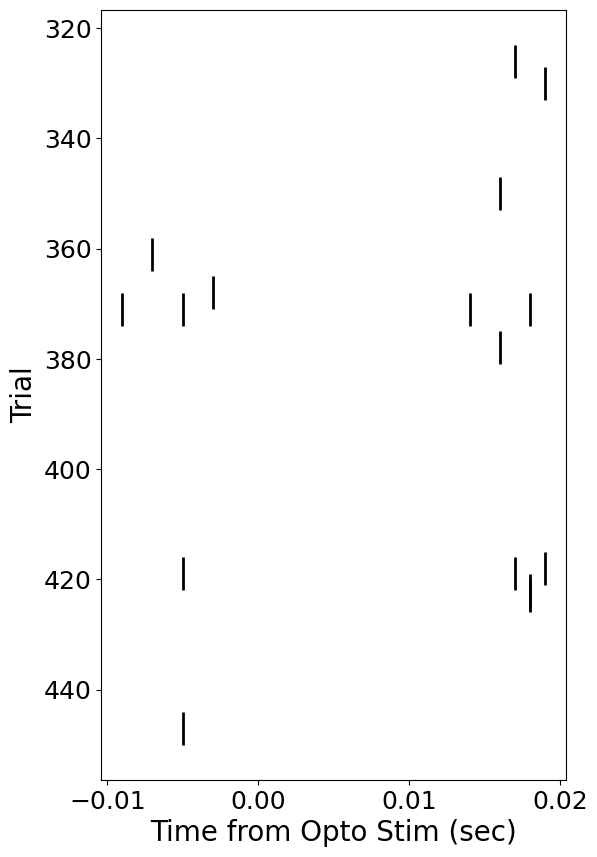

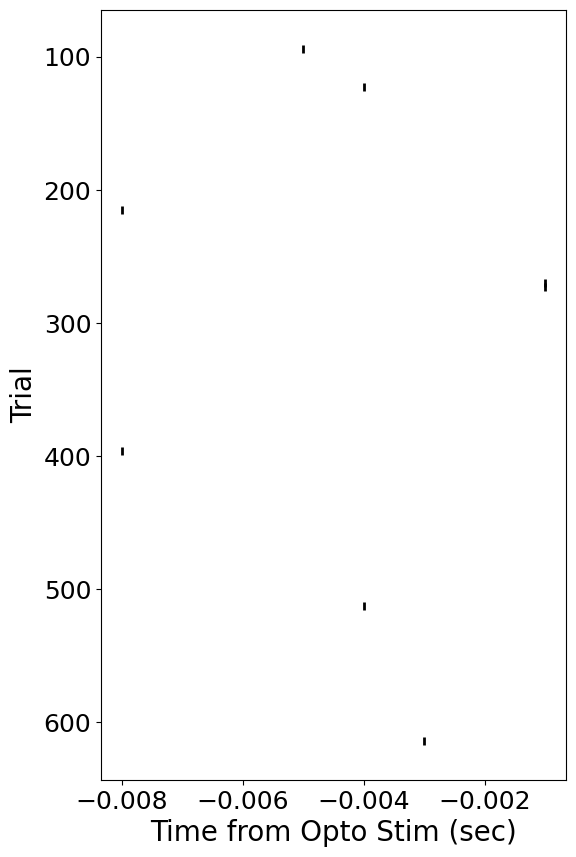

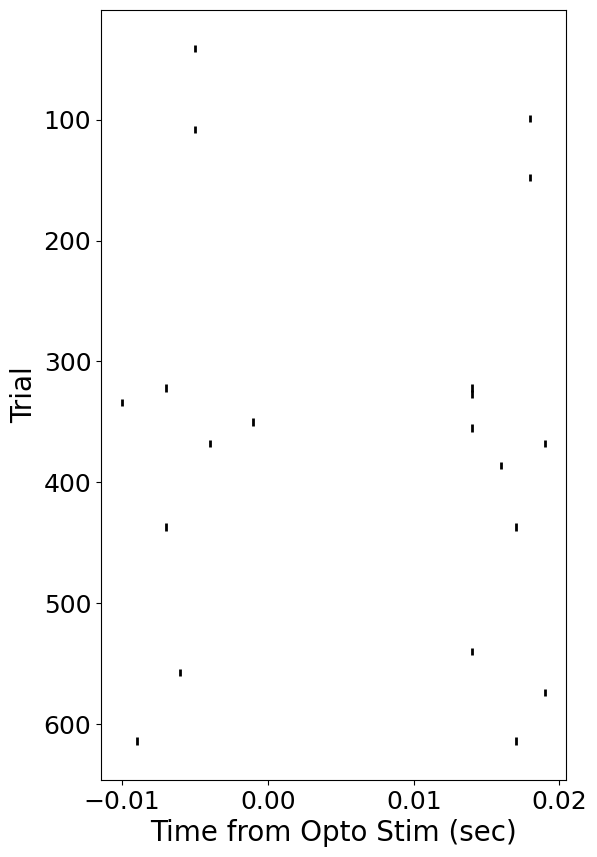

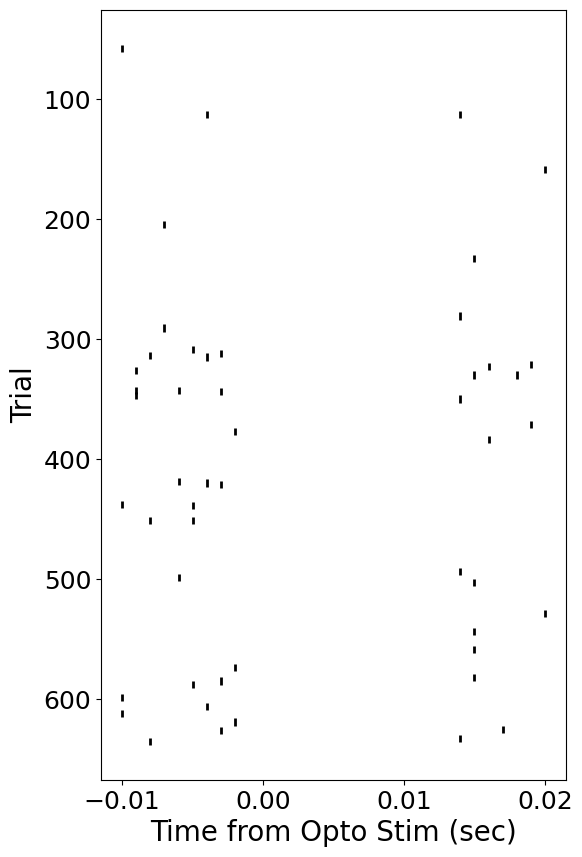

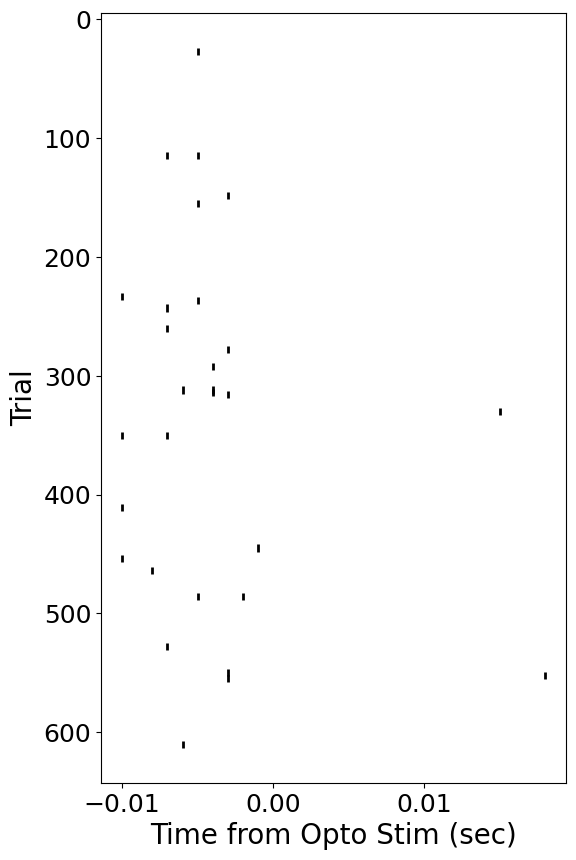

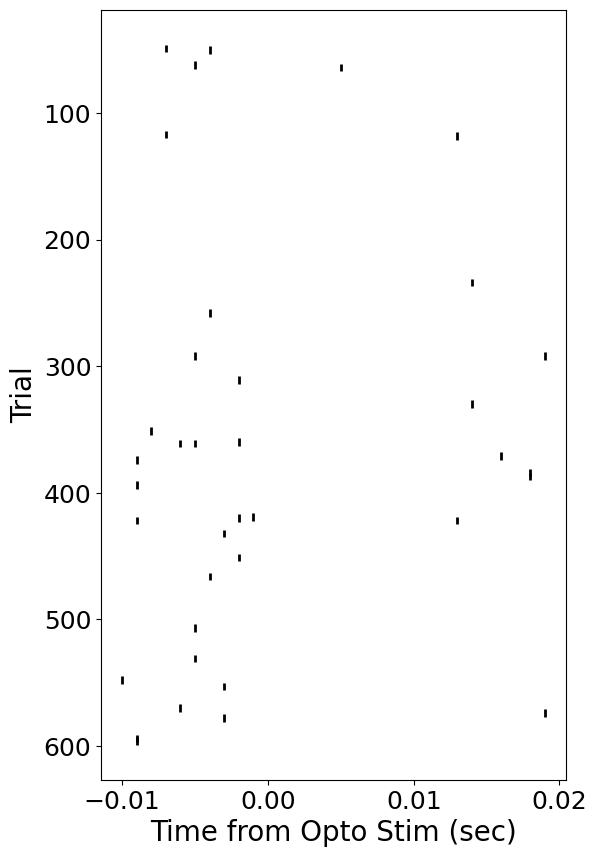

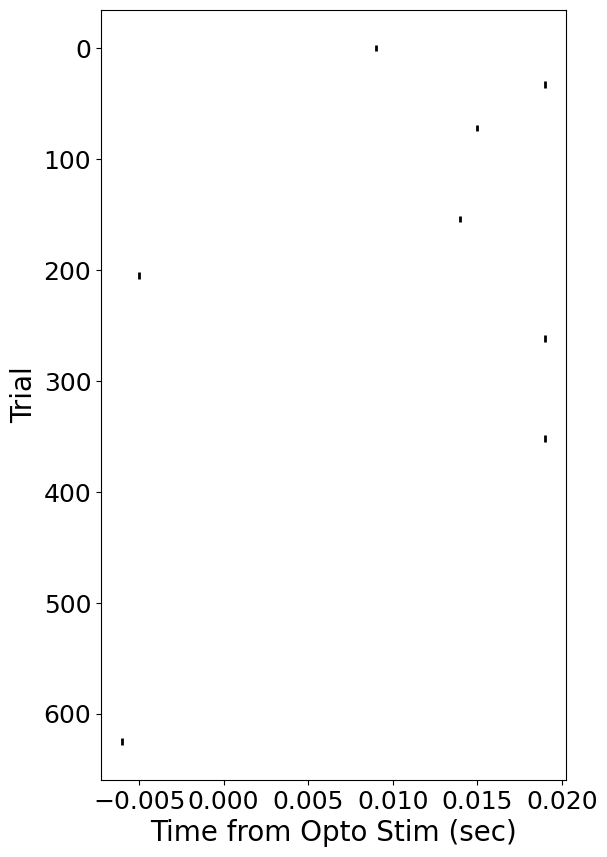

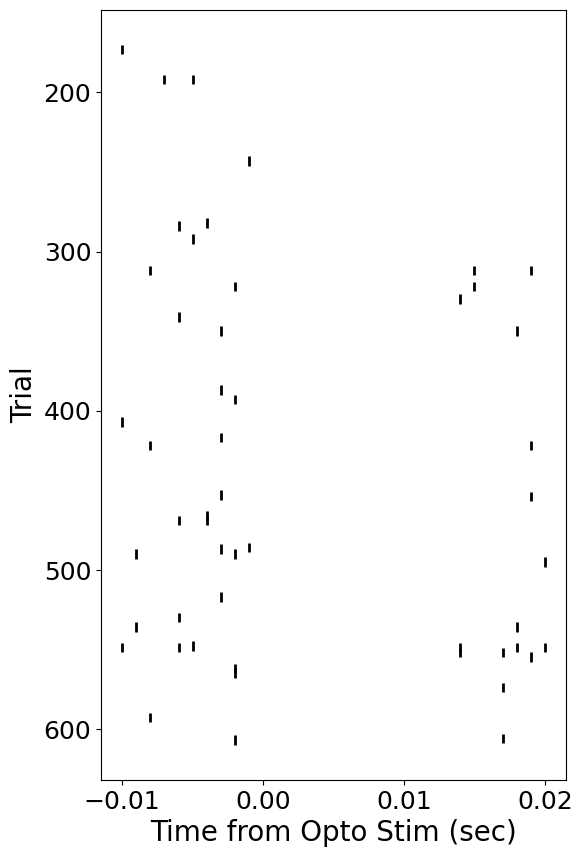

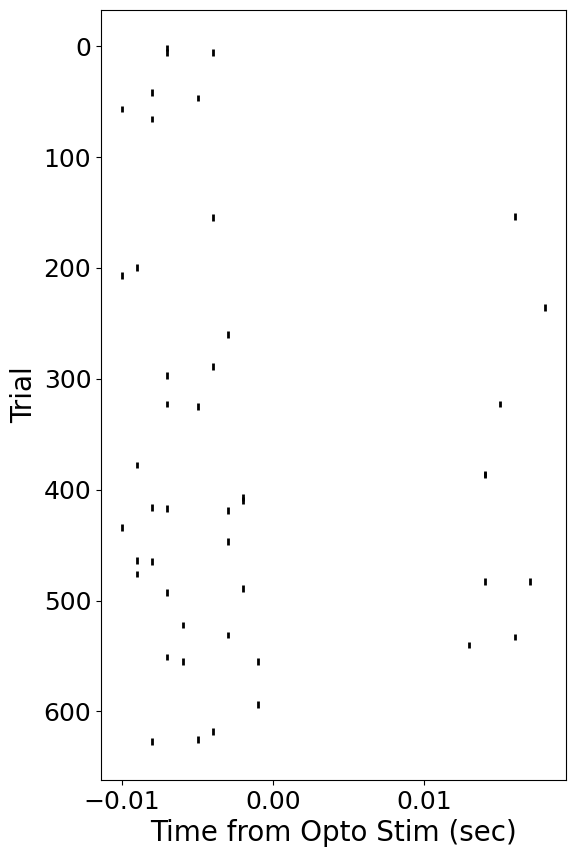

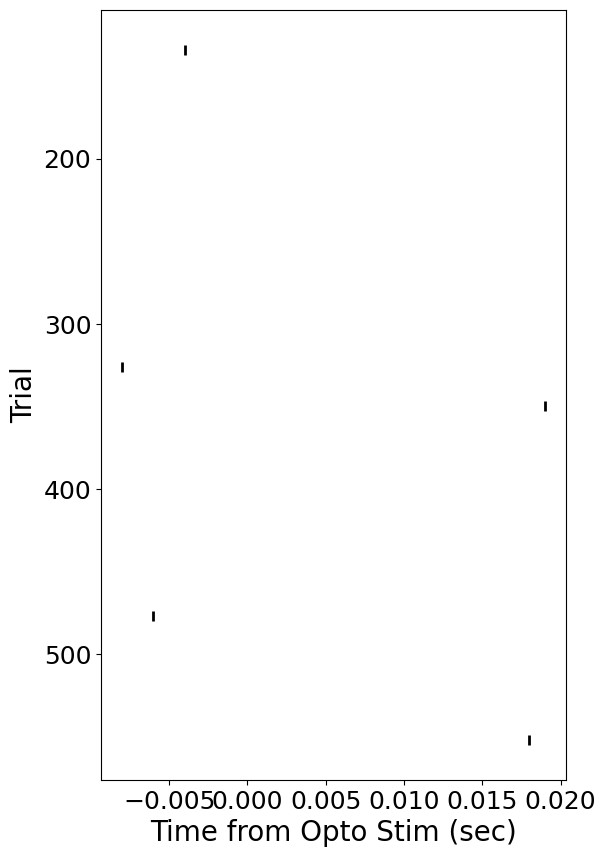

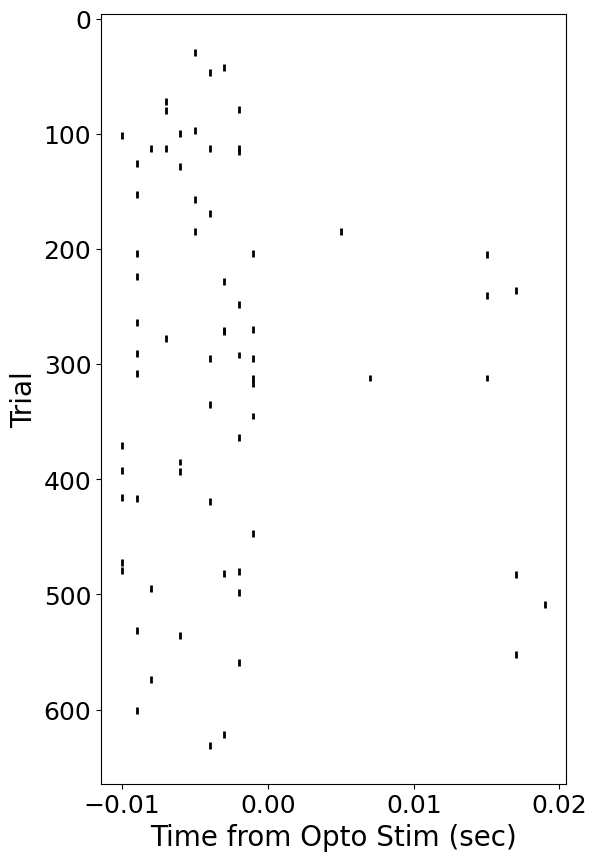

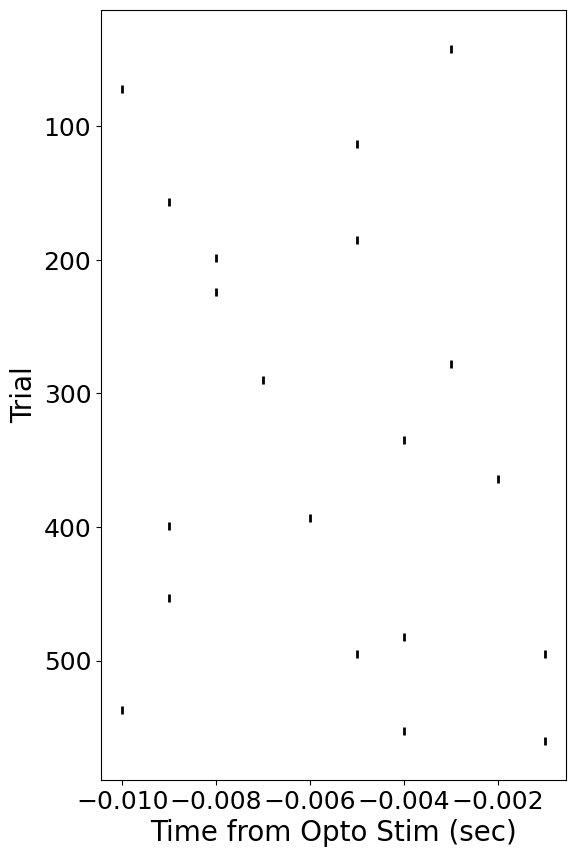

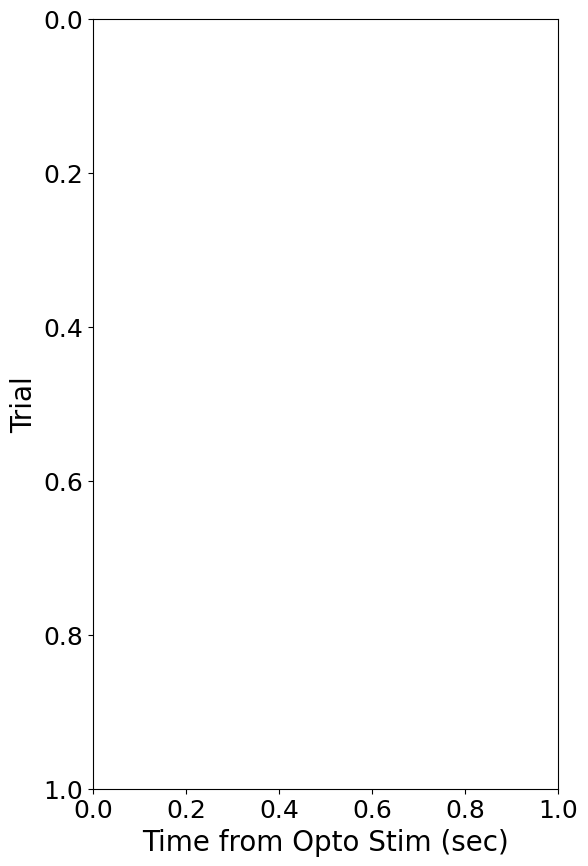

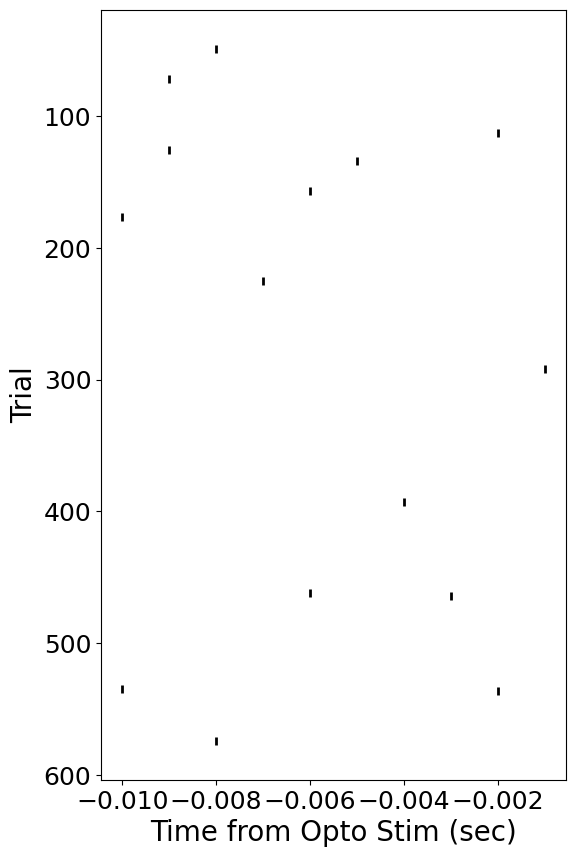

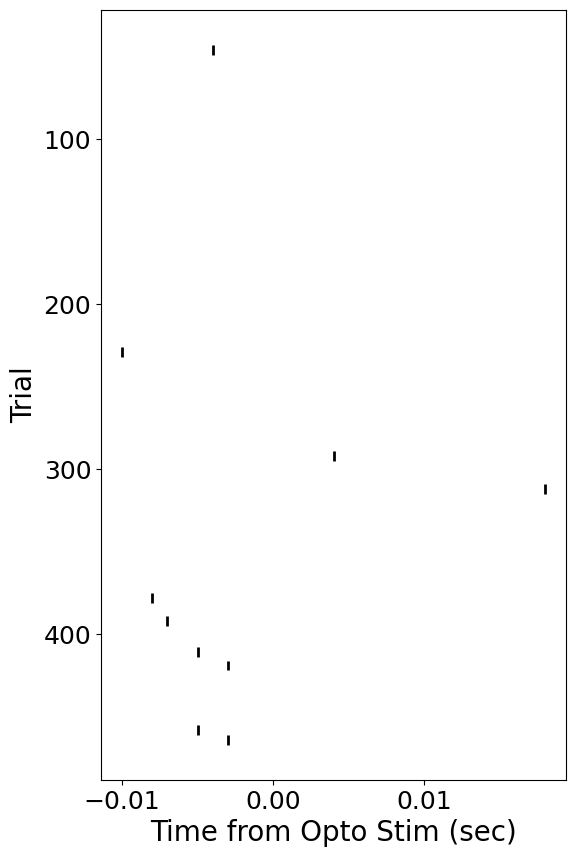

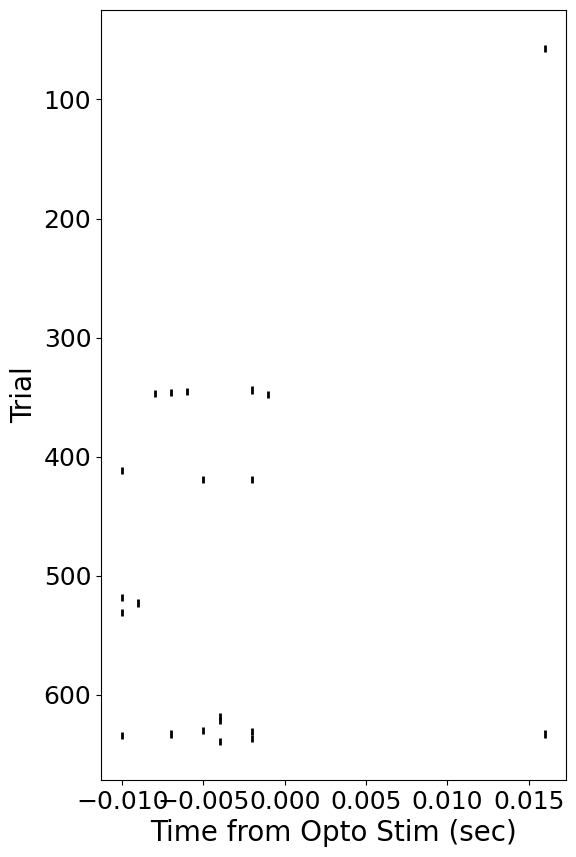

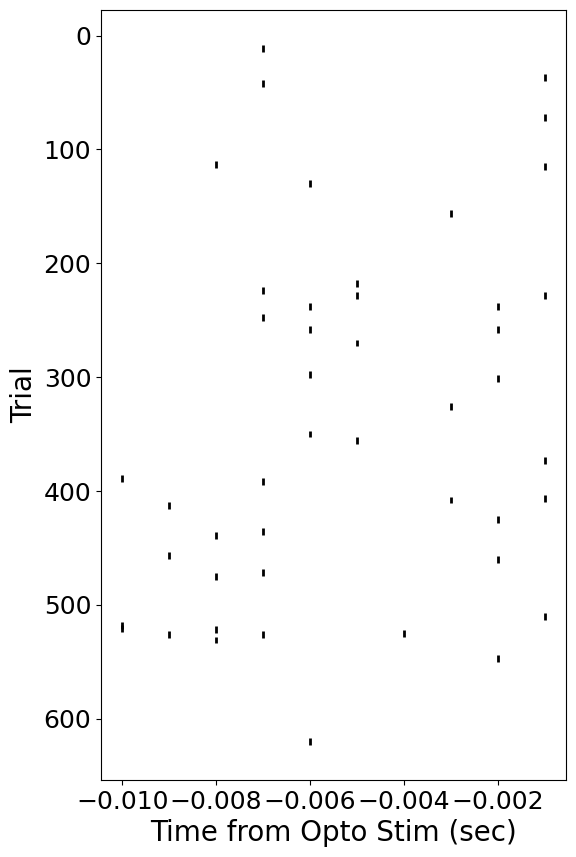

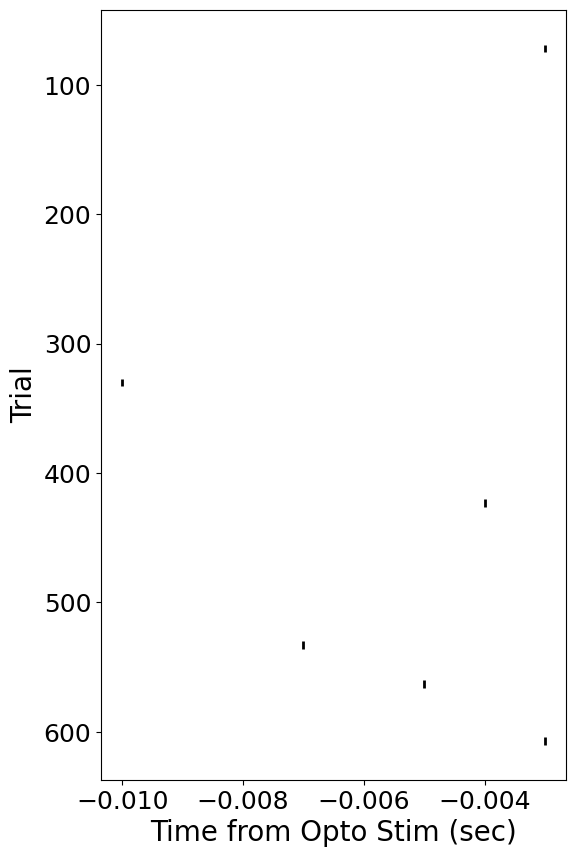

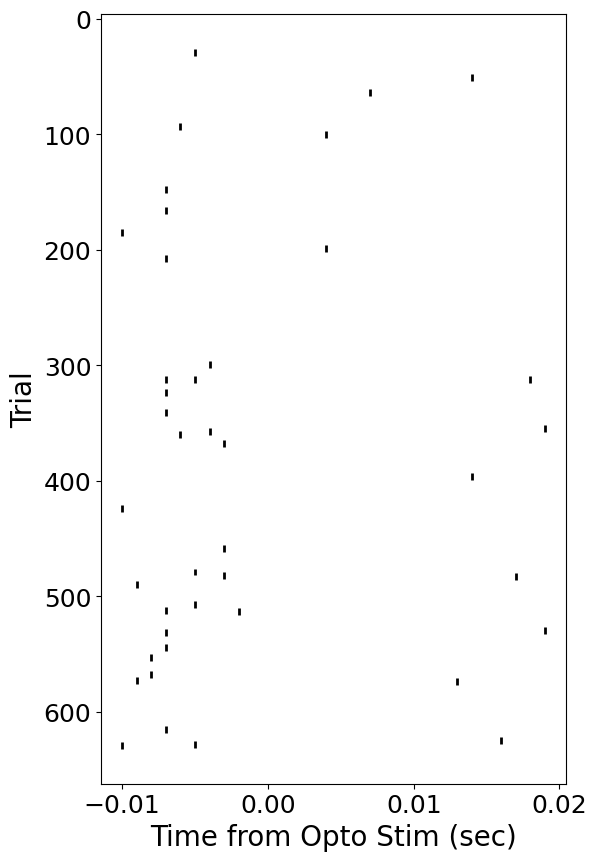

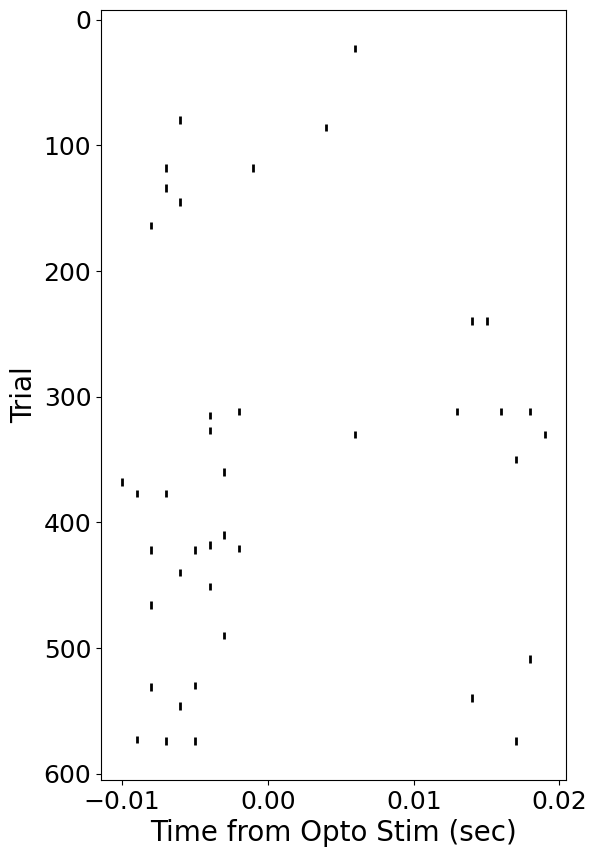

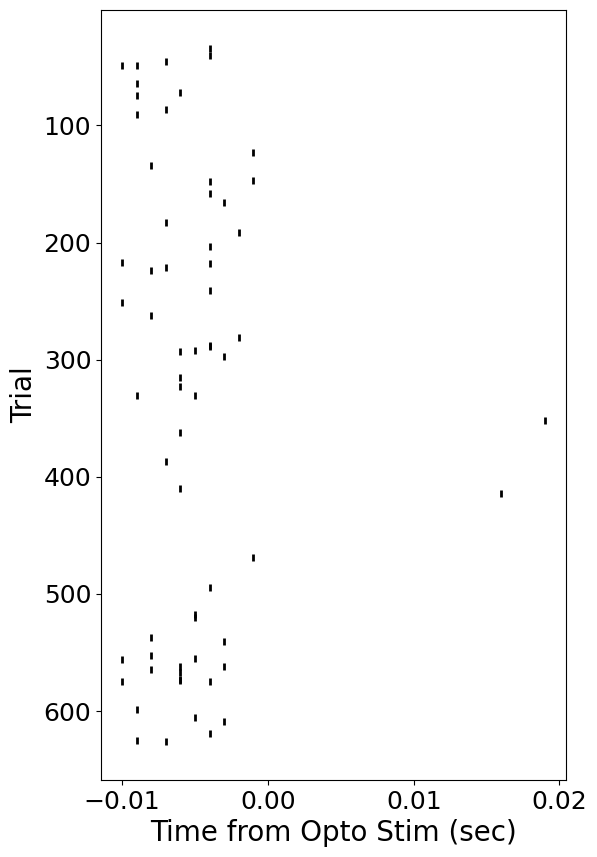

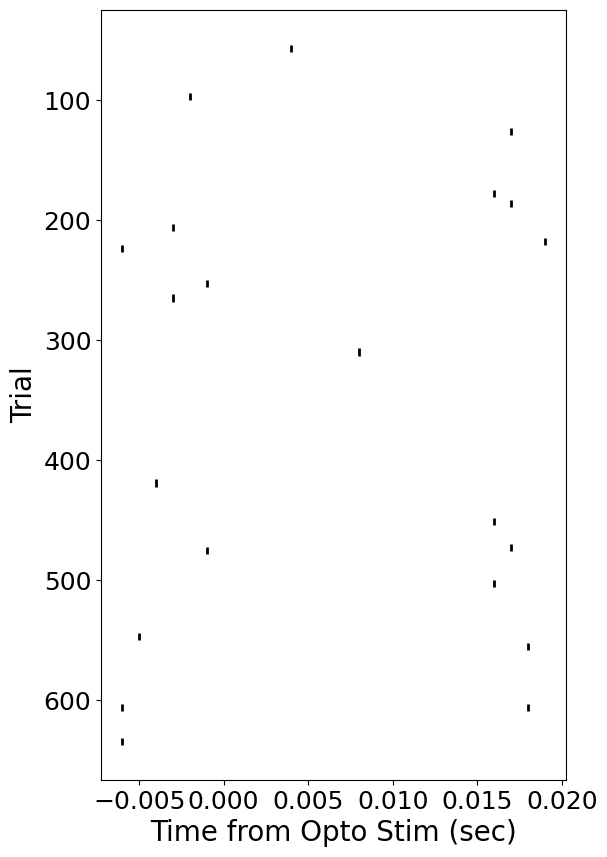

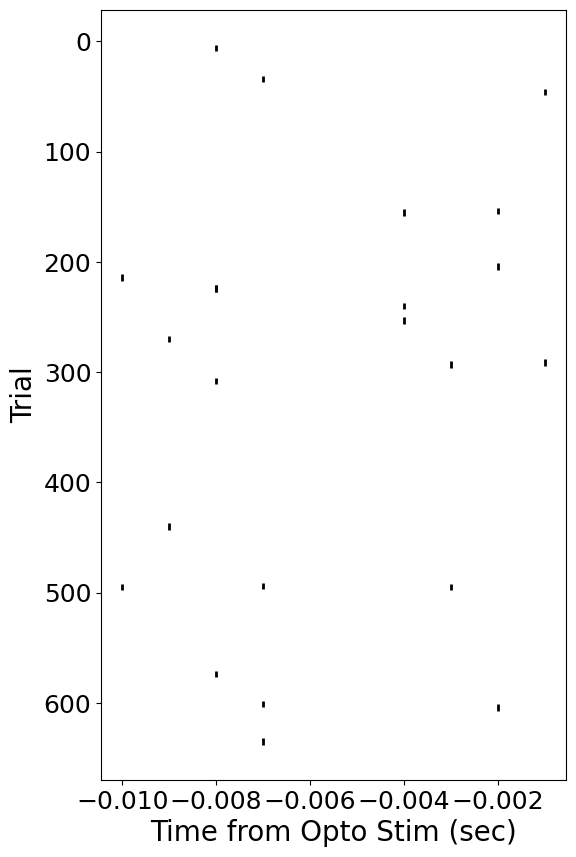

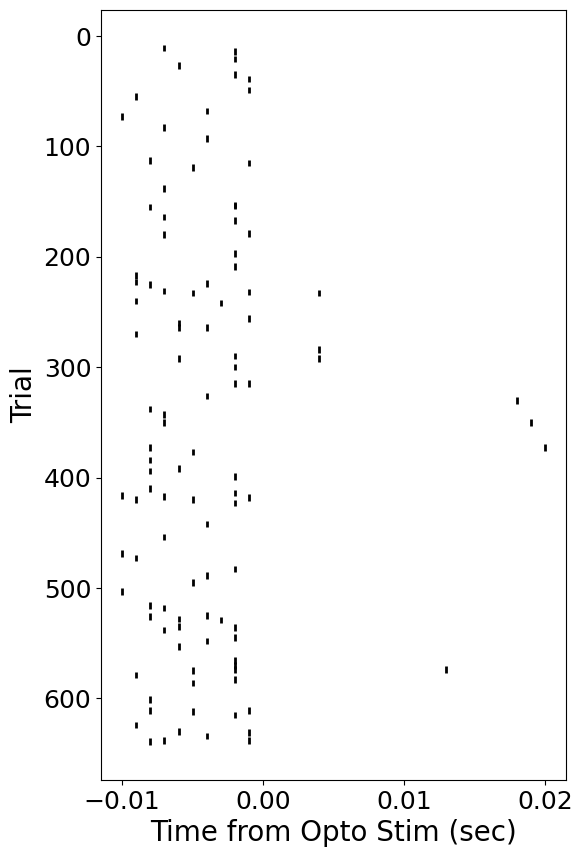

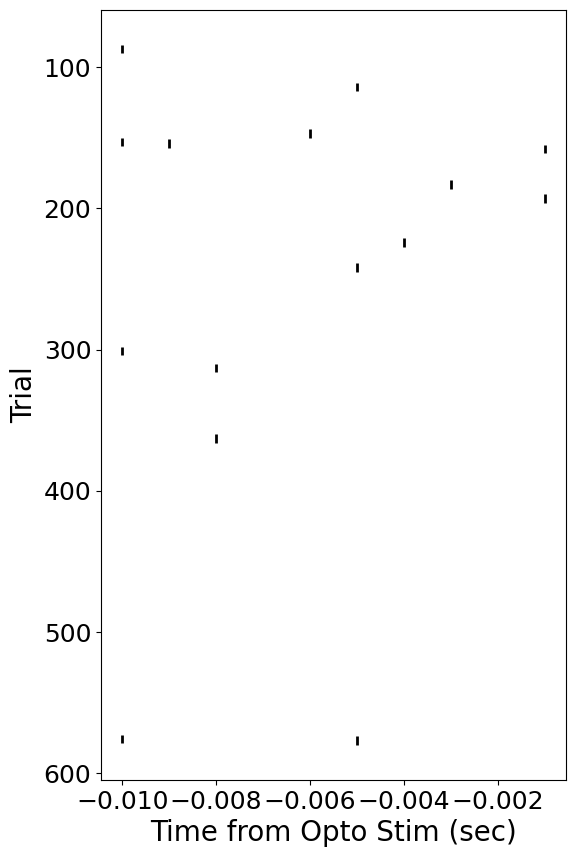

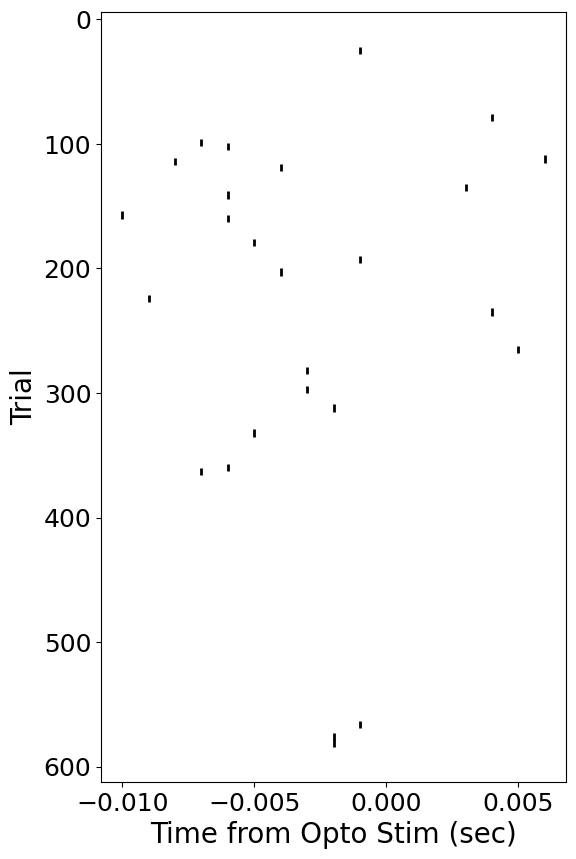

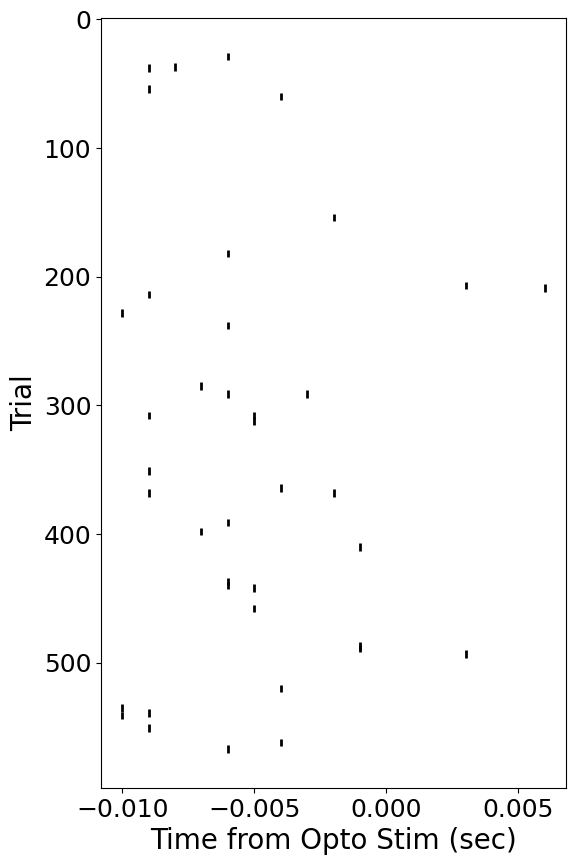

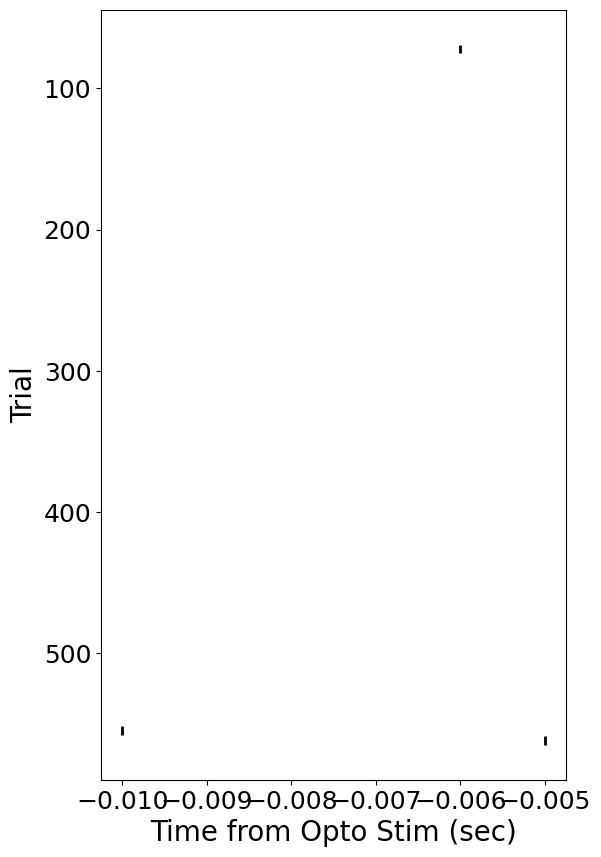

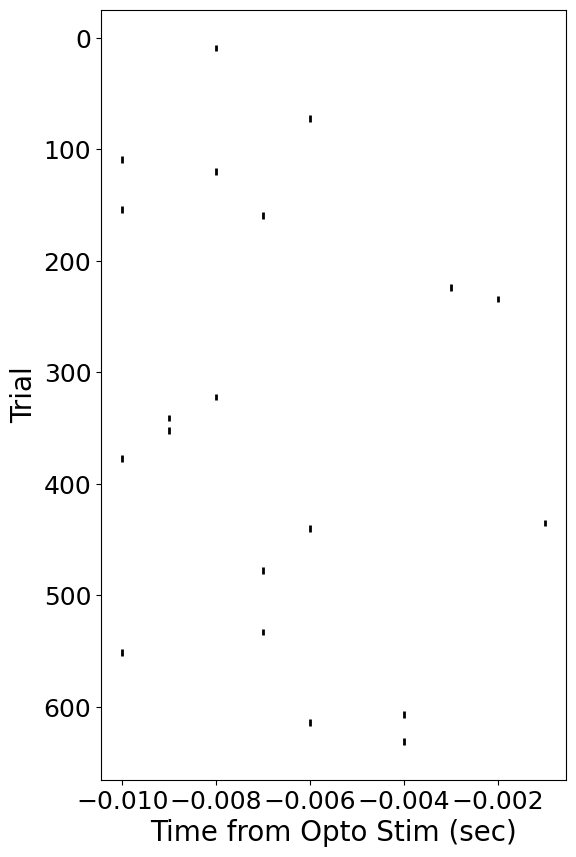

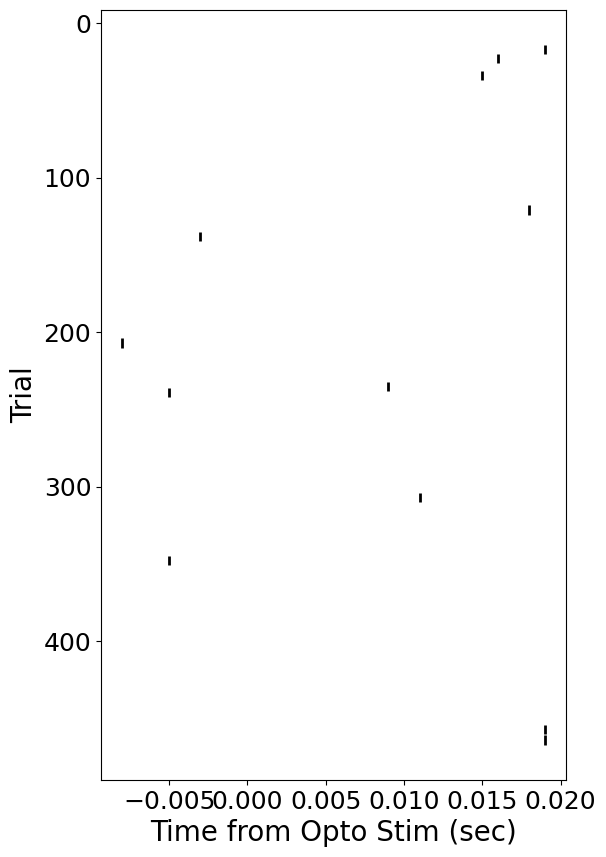

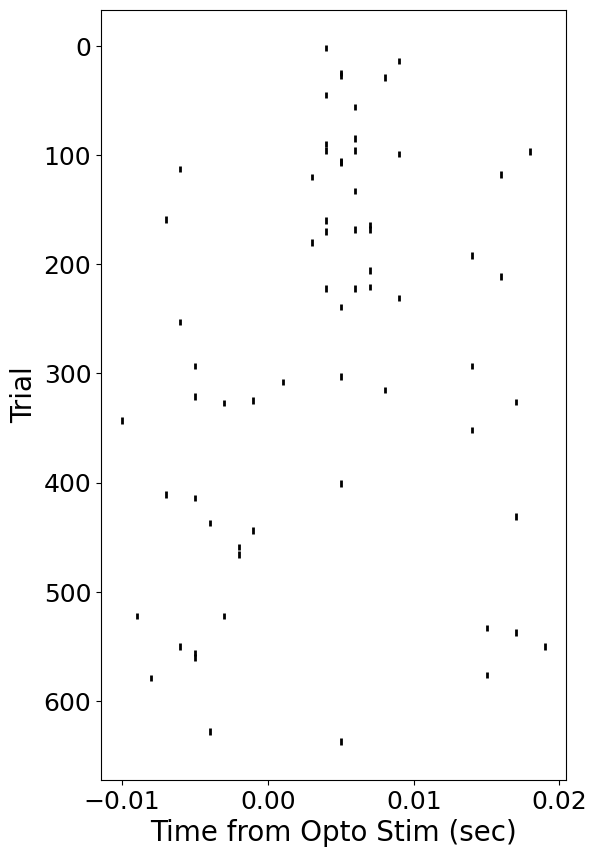

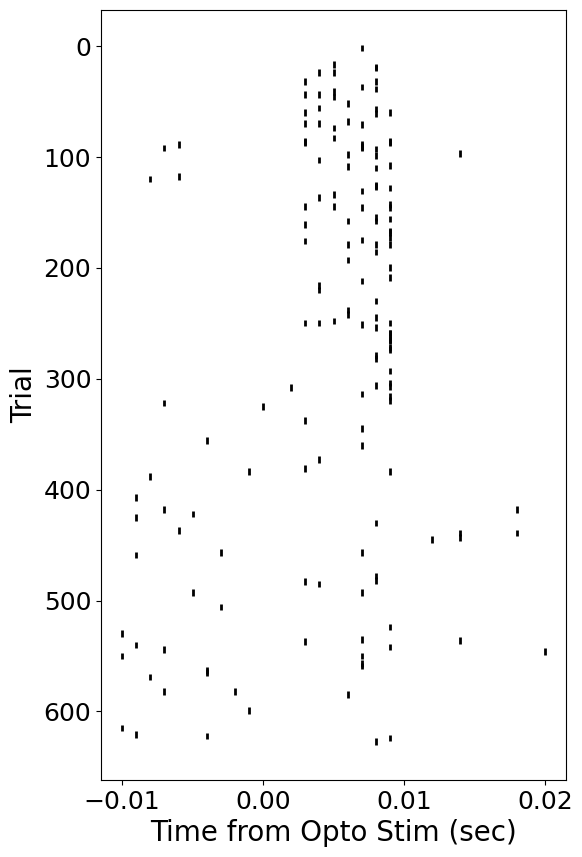

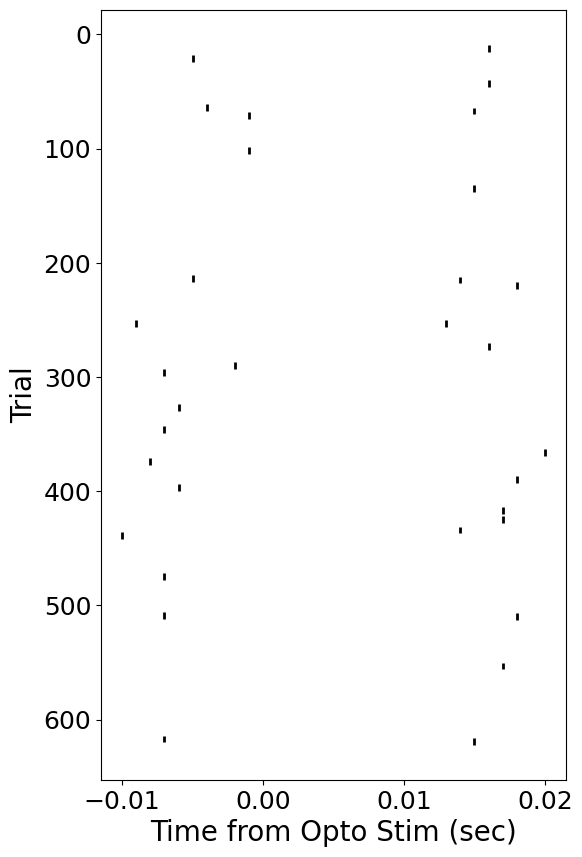

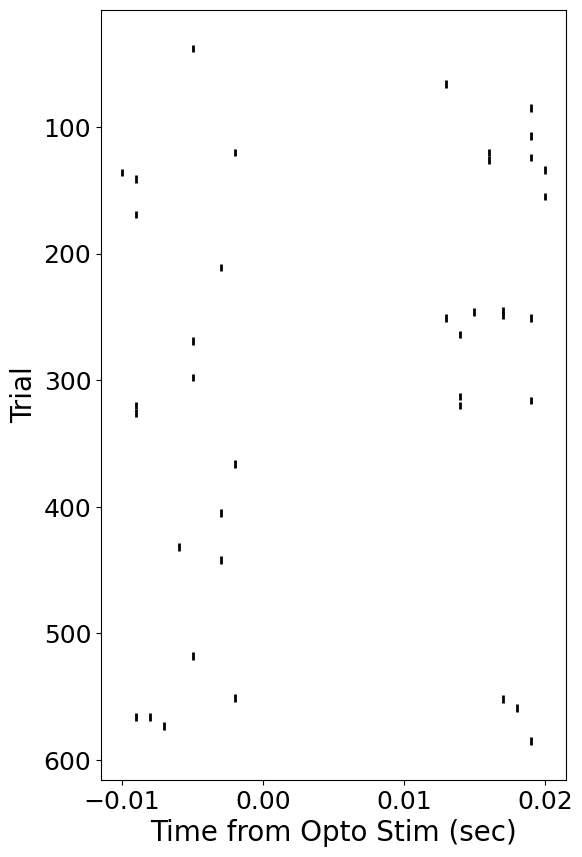

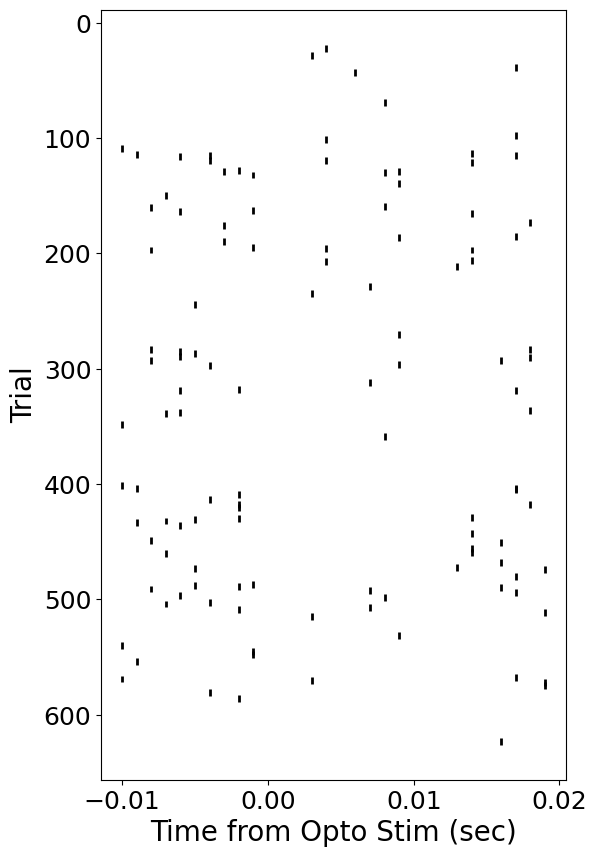

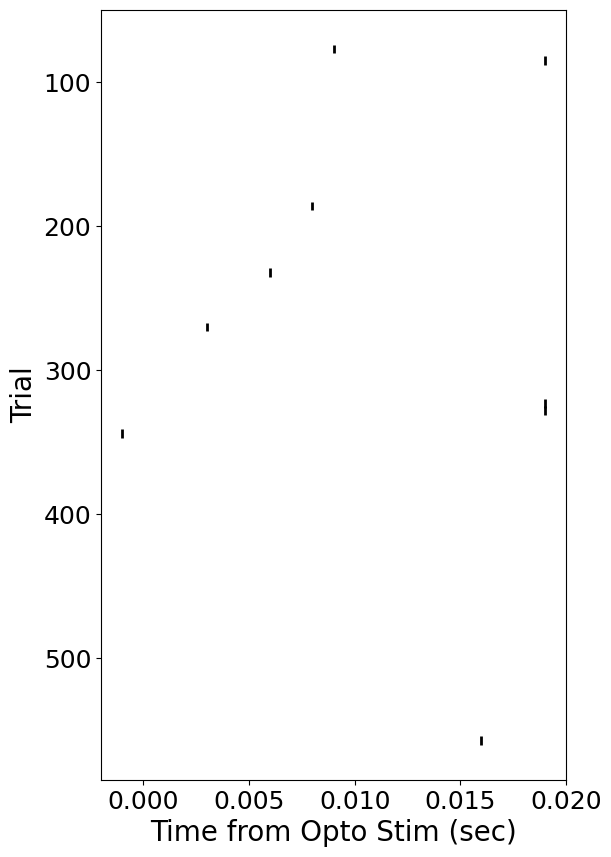

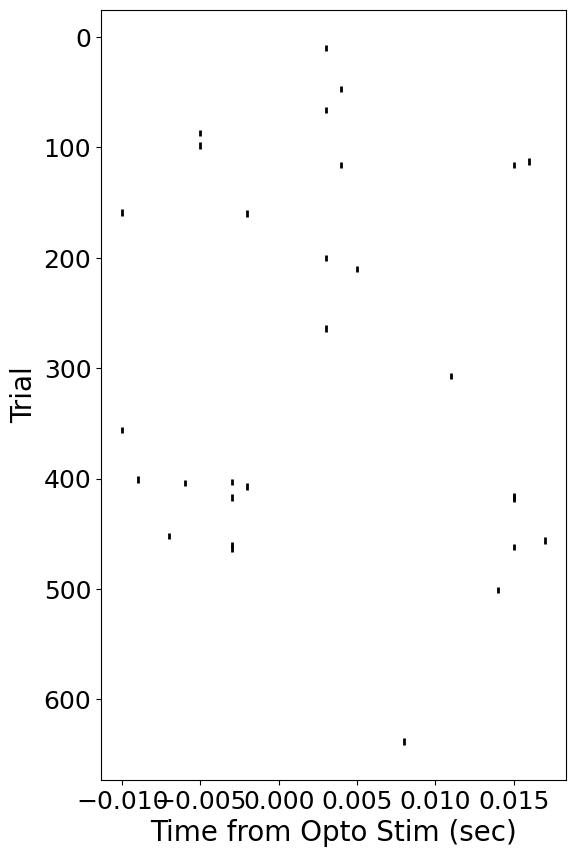

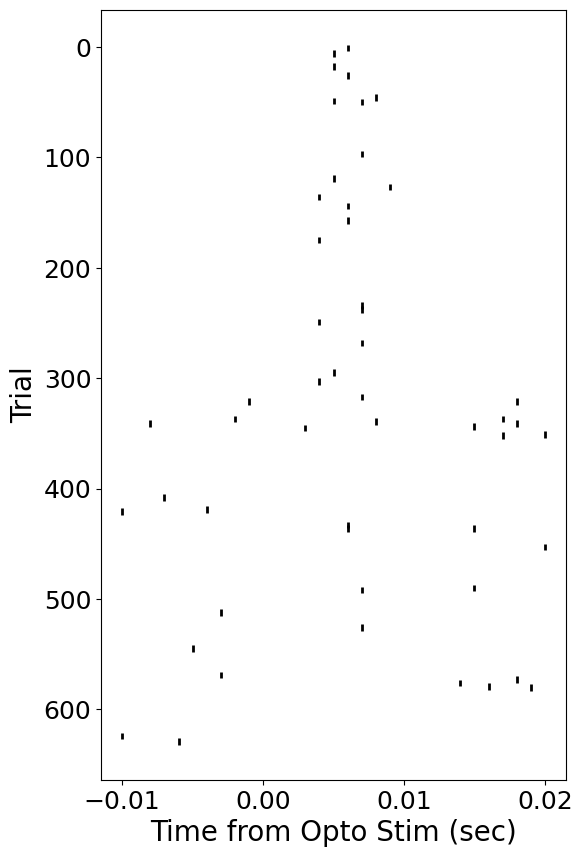

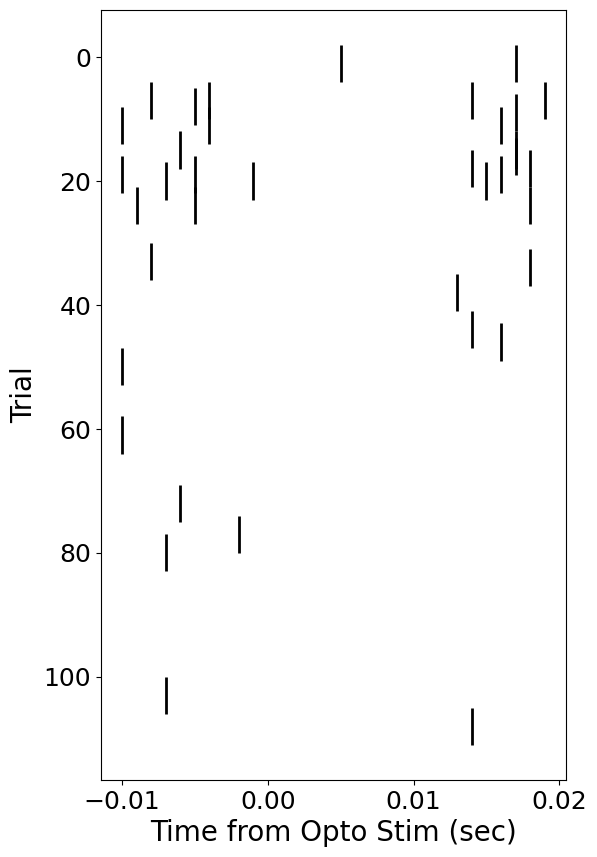

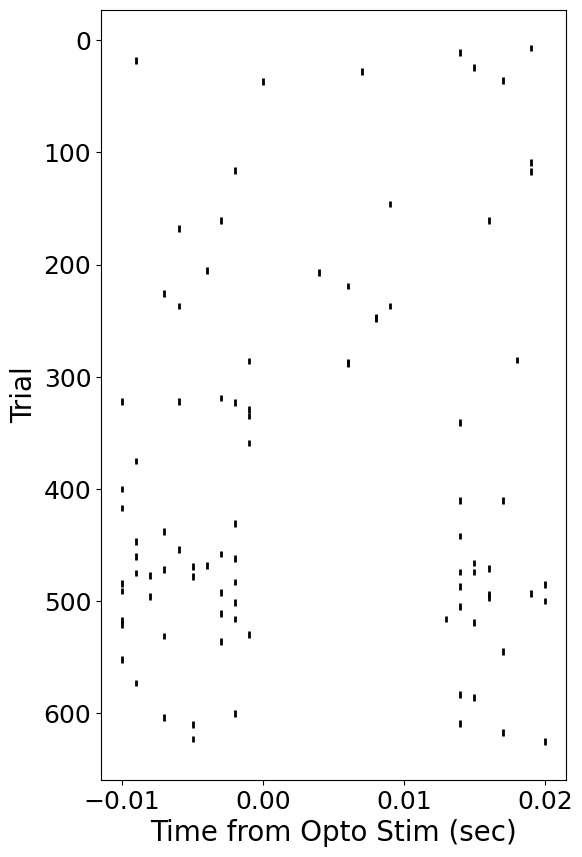

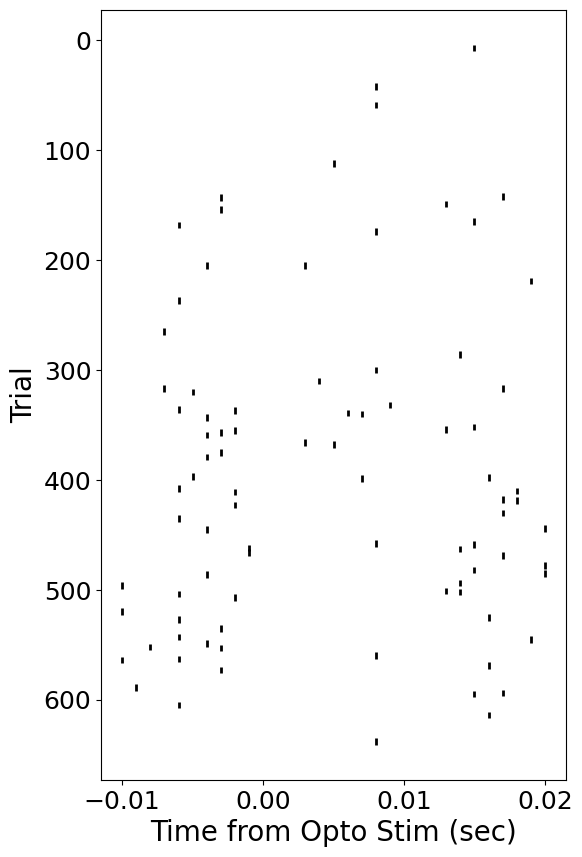

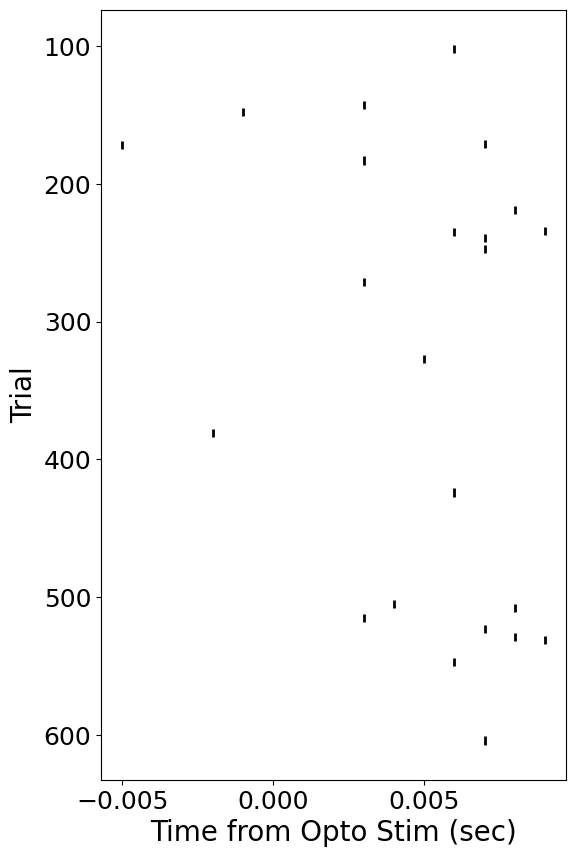

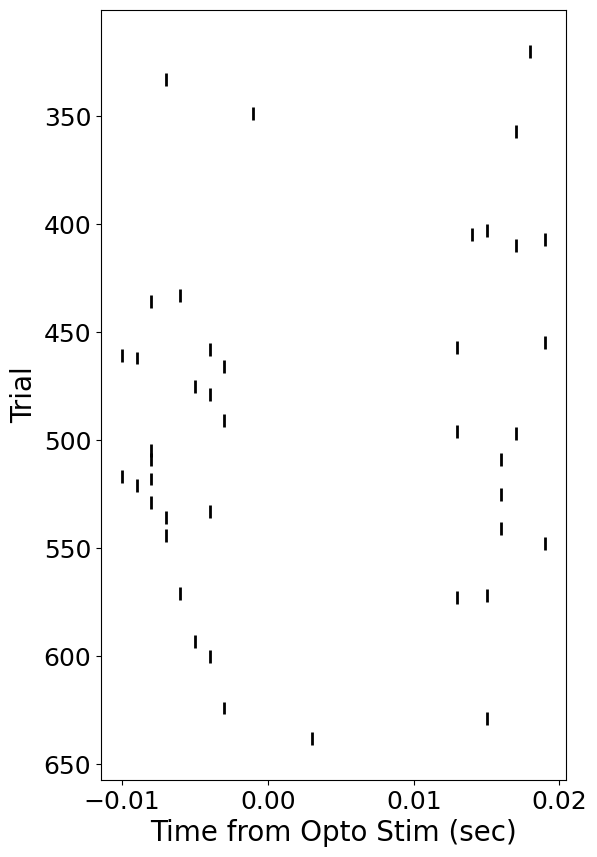

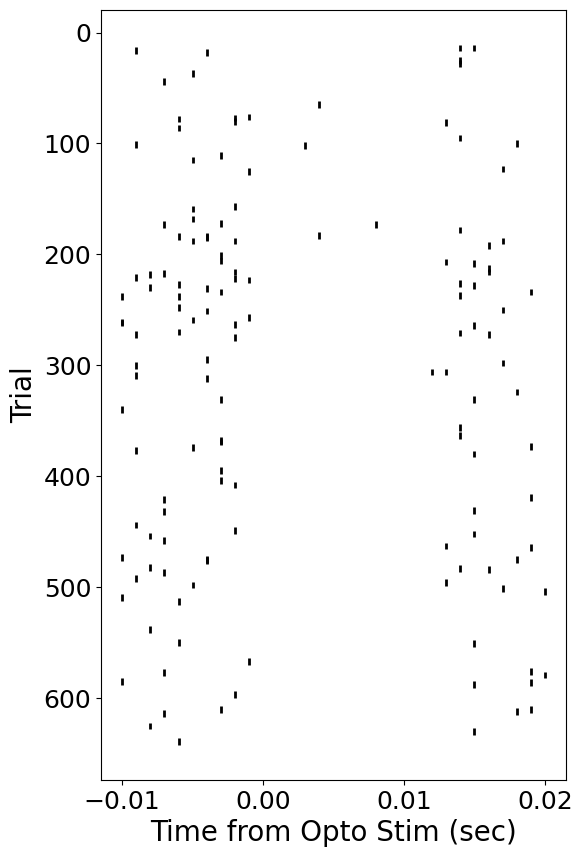

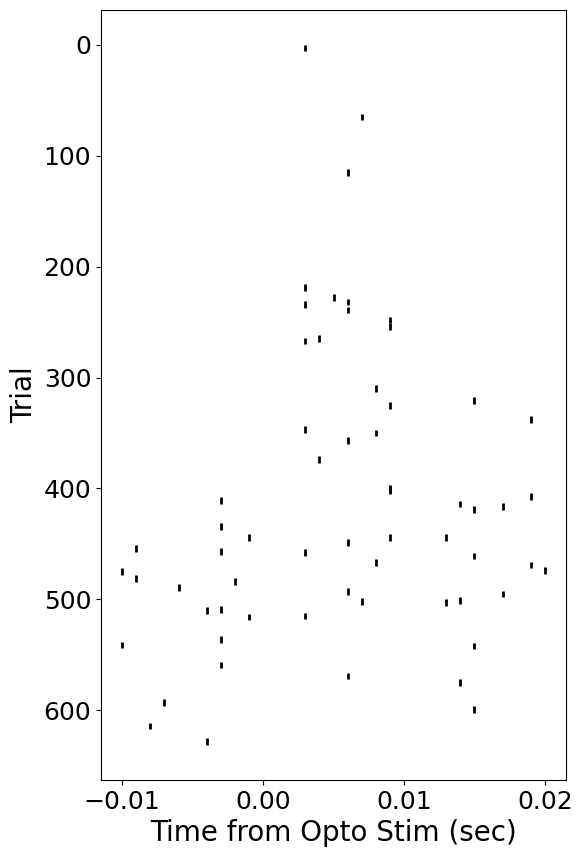

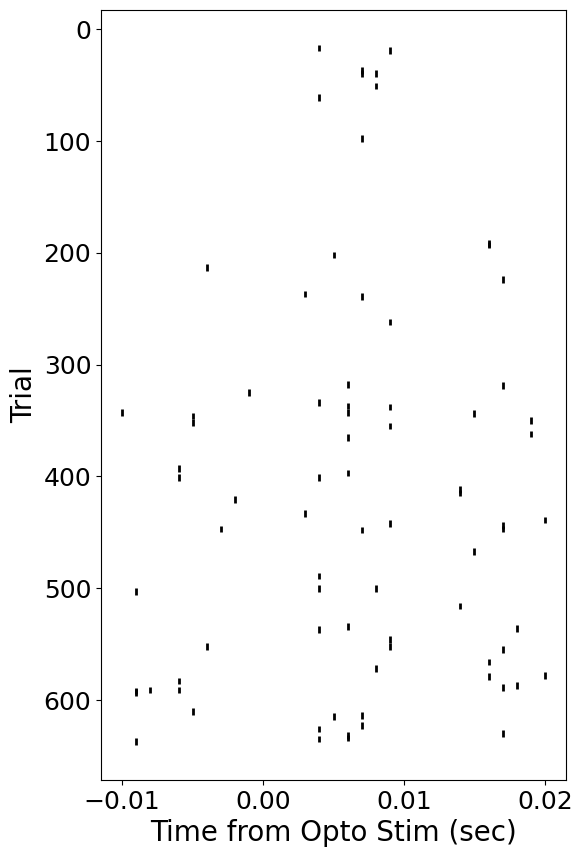

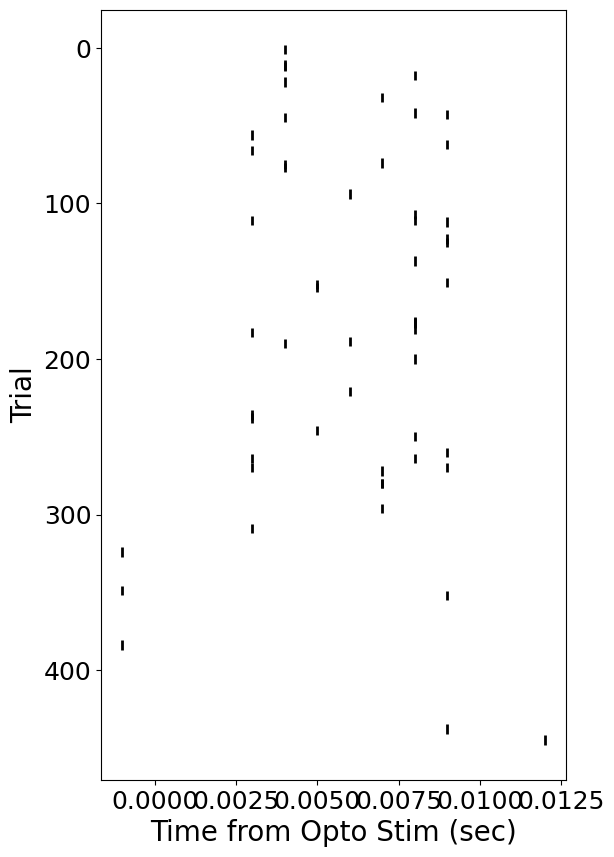

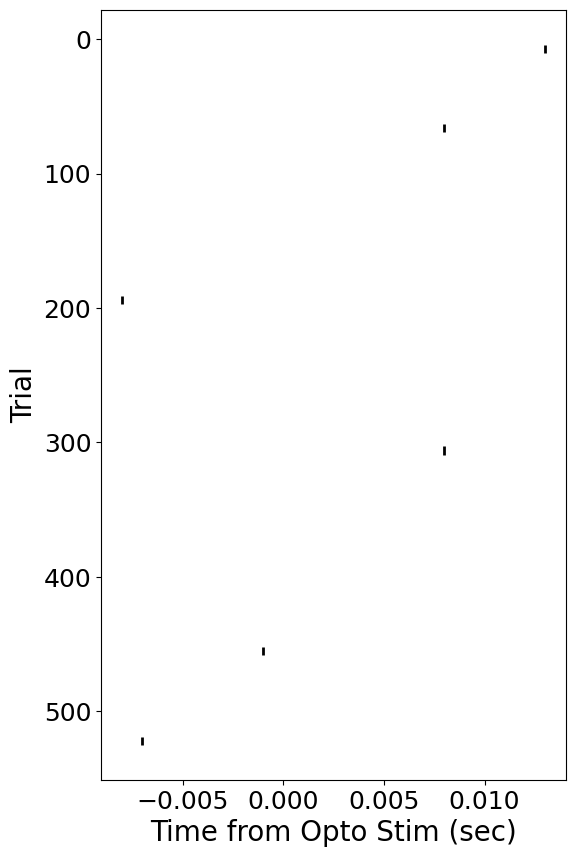

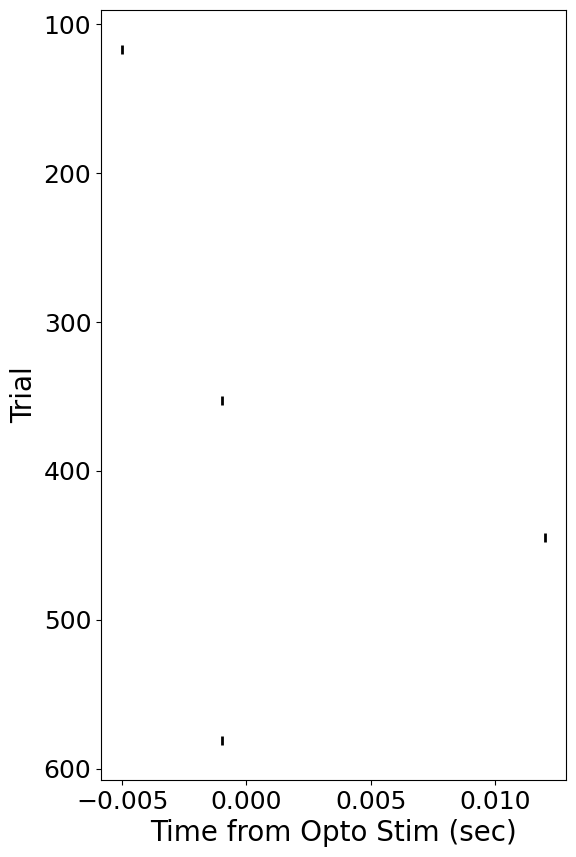

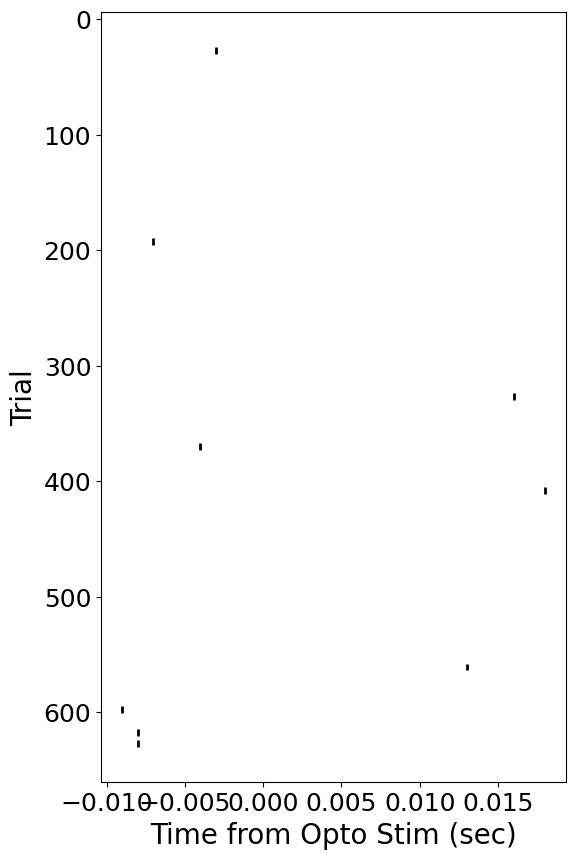

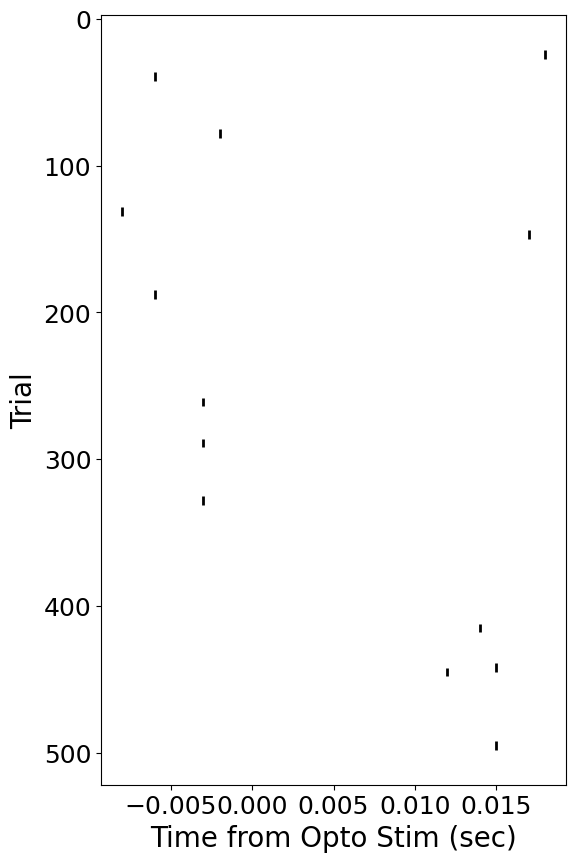

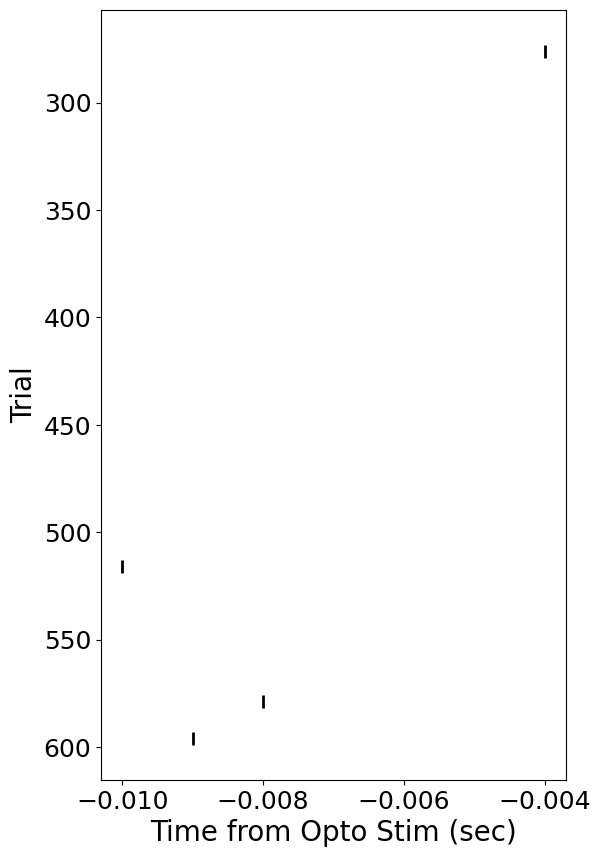

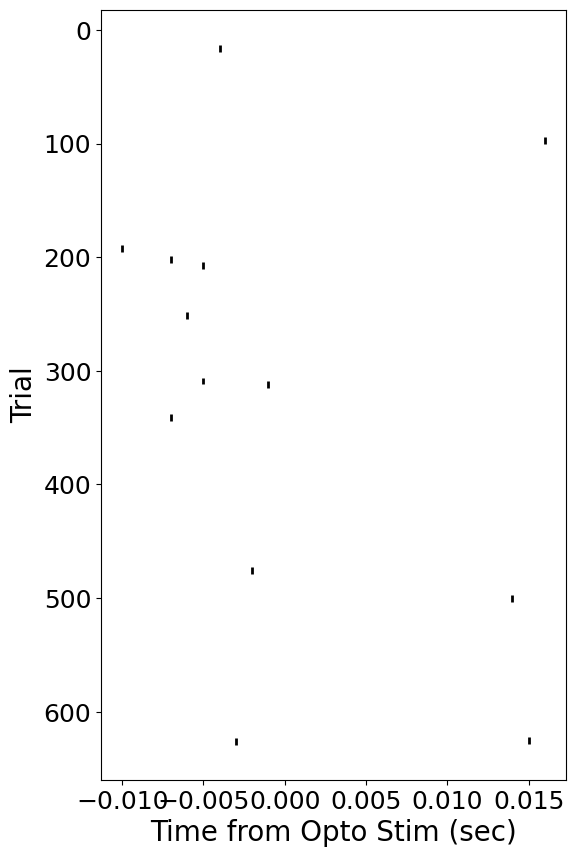

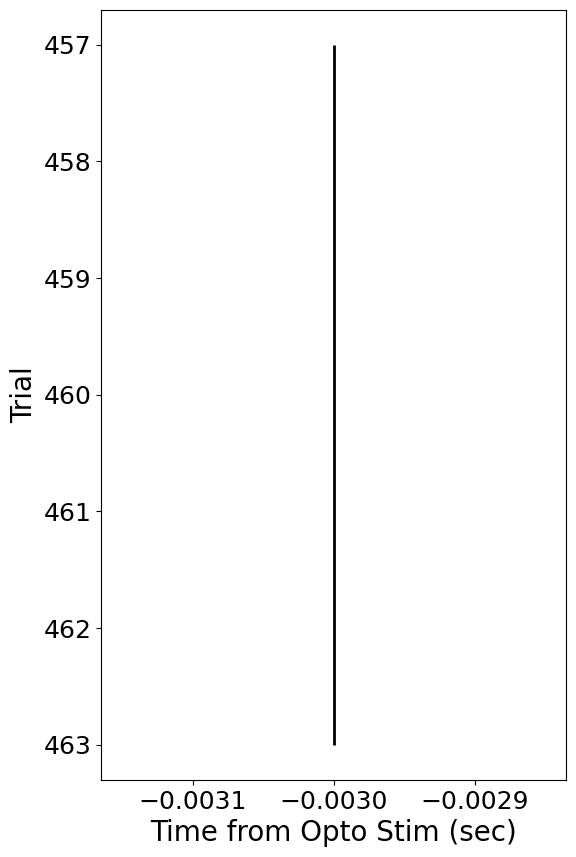

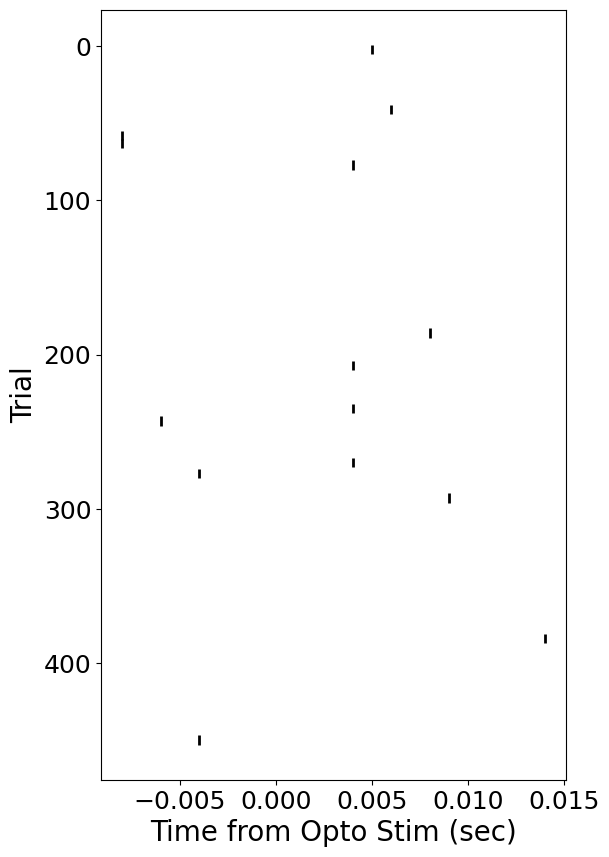

In [24]:
for unit in session._population():
    if unit.cluster not in qualityUnits:
        continue
    spikeTimes = unit.timestamps
    pl.plotRaster(optoTimes, spikeTimes, [-0.01, 0.02], 'Opto Stim')